Our client is a credit card company. They have brought us a dataset that includes some demographics and recent financial data (the past six months) for a sample of 30000 of their account holders. This data is at the credit account level; in other words, there is one row for each account. Rows are labeled by whether in the next month after the six month historical data period, an account owner has defaulted, or in other words, failed to make the minimum payment.
Your goal is to develop a predictive model for whether an account will default next month, given demographics and historical data.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns

# Import the functionality for splitting
from sklearn.model_selection import train_test_split

# Import plotting package
import matplotlib.pyplot as plt

# Render plotting automatically
%matplotlib inline

# Additional plotting functionality
import matplotlib as mpl

# High resolution figures
mpl.rcParams['figure.dpi'] = 400 


Verifying basic data integrity.
We will perform a basic check on whether our dataset contains what we expect and verify whether there are the correct number of samples. While there are 30000 rows, we should also check whether there are 30000 unique account IDs. To examine this, we can check if the number of unique account IDs is the same as the number of rows.
We have identified a data quality issue related to the metadata: we had been told that every sample from our dataset corresponded to a unique account ID, but found that this was not the case. We were able to use logical indexing and pandas to correct the issue.

In [3]:
# Import the dataset
df = pd.read_excel("Data/default_of_credit_card_clients__courseware_version_1_21_19.xls")

In [4]:
# Review the number of rows and columns
df.shape

(30000, 25)

In [5]:
# Examine all the column names
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [6]:
# Observe the first few rows of data
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
# Check if the number of unique account IDs is the same as the number of rows
df["ID"].nunique()

29687

In [8]:
# Identify duplicated IDs
id_counts = df["ID"].value_counts()
id_counts.head()

20050b52-5d6e    2
6870544f-459e    2
91321f74-e4a4    2
7c9b7473-cc2f    2
85bd7f39-2e9b    2
Name: ID, dtype: int64

In [9]:
# Display the number of grouped duplicated entries
id_counts.value_counts()

1    29374
2      313
Name: ID, dtype: int64

In [10]:
# Create a logical mask
dupe_mask = id_counts == 2
dupe_mask.head()

20050b52-5d6e    True
6870544f-459e    True
91321f74-e4a4    True
7c9b7473-cc2f    True
85bd7f39-2e9b    True
Name: ID, dtype: bool

In [11]:
# Display the first five rows
id_counts.index[0:5]

Index(['20050b52-5d6e', '6870544f-459e', '91321f74-e4a4', '7c9b7473-cc2f',
       '85bd7f39-2e9b'],
      dtype='object')

In [12]:
# Make a list of duplicate IDs
dupe_ids = id_counts.index[dupe_mask]
len(dupe_ids)

313

In [13]:
# Display the first five IDs
dupe_ids[0:5]

Index(['20050b52-5d6e', '6870544f-459e', '91321f74-e4a4', '7c9b7473-cc2f',
       '85bd7f39-2e9b'],
      dtype='object')

In [14]:
# Find the rows containing these IDs
df.loc[df["ID"].isin(dupe_ids[0:3]),:].head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
12508,20050b52-5d6e,150000,2,1,1,52,-1,3,2,0,...,2034,2140,6731,20,802,1705,1806,6427,16,1
12608,20050b52-5d6e,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15190,91321f74-e4a4,30000,2,2,2,24,3,2,2,7,...,300,300,300,0,0,0,0,0,0,0
15290,91321f74-e4a4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17340,6870544f-459e,200000,2,1,2,32,-2,-2,-2,-2,...,148287,146948,148772,0,1685,326974,5200,5500,6000,0
17440,6870544f-459e,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Create a Boolean matrix of the same size as the entire DataFrame
df_zero_mask = df == 0

In [16]:
# Create Boolean series
feature_zero_mask = df_zero_mask.iloc[:,1:].all(axis=1)
sum(feature_zero_mask)

315

In [17]:
# Clean the DataFrame by eliminating the rows with all zeros, except fo the ID
df_clean_1 = df.loc[~feature_zero_mask,:].copy()
df_clean_1.shape

(29685, 25)

In [18]:
# Obtain the number of unique IDs
df_clean_1["ID"].nunique()

29685

Exploring and cleaning the data.
We are ready to start examining the values of the features and response, the data we will use to develop our predictive model.

In [19]:
# Obtain the data type of the columns in the data
df_clean_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29685 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          29685 non-null  object
 1   LIMIT_BAL                   29685 non-null  int64 
 2   SEX                         29685 non-null  int64 
 3   EDUCATION                   29685 non-null  int64 
 4   MARRIAGE                    29685 non-null  int64 
 5   AGE                         29685 non-null  int64 
 6   PAY_1                       29685 non-null  object
 7   PAY_2                       29685 non-null  int64 
 8   PAY_3                       29685 non-null  int64 
 9   PAY_4                       29685 non-null  int64 
 10  PAY_5                       29685 non-null  int64 
 11  PAY_6                       29685 non-null  int64 
 12  BILL_AMT1                   29685 non-null  int64 
 13  BILL_AMT2                   29685 non-null  in

In [20]:
# Display the first five rows of "PAY_1"
df_clean_1["PAY_1"].head()

0     2
1    -1
2     0
3     0
4    -1
Name: PAY_1, dtype: object

The output below reveals the presence of two undocumented values: 0 and -2, as well as the reason this column was imported by pandas as an object data type, instead of int64 as we would expect for integer data.

In [21]:
# Obtain the value counts for the PAY_1 column
df_clean_1["PAY_1"].value_counts()

0                13087
-1                5047
1                 3261
Not available     3021
-2                2476
2                 2378
3                  292
4                   63
5                   23
8                   17
6                   11
7                    9
Name: PAY_1, dtype: int64

In [22]:
# Find all the rows that don't have missing data for the PAY_1
valid_pay_1_mask = df_clean_1["PAY_1"] != "Not available"
valid_pay_1_mask[0:5]

0    True
1    True
2    True
3    True
4    True
Name: PAY_1, dtype: bool

In [23]:
# Check how many rows have no missing data
sum(valid_pay_1_mask)

26664

In [24]:
# Clean the data by eliminating the rows with the missing values of PAY_1
df_clean_2 = df_clean_1.loc[valid_pay_1_mask,:].copy()
df_clean_2.shape

(26664, 25)

In [25]:
# Convert the data type for PAY_1 from object to int64
df_clean_2["PAY_1"] = df_clean_2["PAY_1"].astype("int64")
df_clean_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26664 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          26664 non-null  object
 1   LIMIT_BAL                   26664 non-null  int64 
 2   SEX                         26664 non-null  int64 
 3   EDUCATION                   26664 non-null  int64 
 4   MARRIAGE                    26664 non-null  int64 
 5   AGE                         26664 non-null  int64 
 6   PAY_1                       26664 non-null  int64 
 7   PAY_2                       26664 non-null  int64 
 8   PAY_3                       26664 non-null  int64 
 9   PAY_4                       26664 non-null  int64 
 10  PAY_5                       26664 non-null  int64 
 11  PAY_6                       26664 non-null  int64 
 12  BILL_AMT1                   26664 non-null  int64 
 13  BILL_AMT2                   26664 non-null  in

Data quality assurance and exploration.
We start our exploration of the data with the credit limit and age features. We will visualize them and get summary statistics to check that the data contained in these features is sensible. Then we will look at the education and marriage categorical features to see if the values there make sense, and correct them as necessary. We will use histograms to visualize numerical features and for the categorical features a look at the value counts is useful.

array([[<AxesSubplot:title={'center':'LIMIT_BAL'}>,
        <AxesSubplot:title={'center':'AGE'}>]], dtype=object)

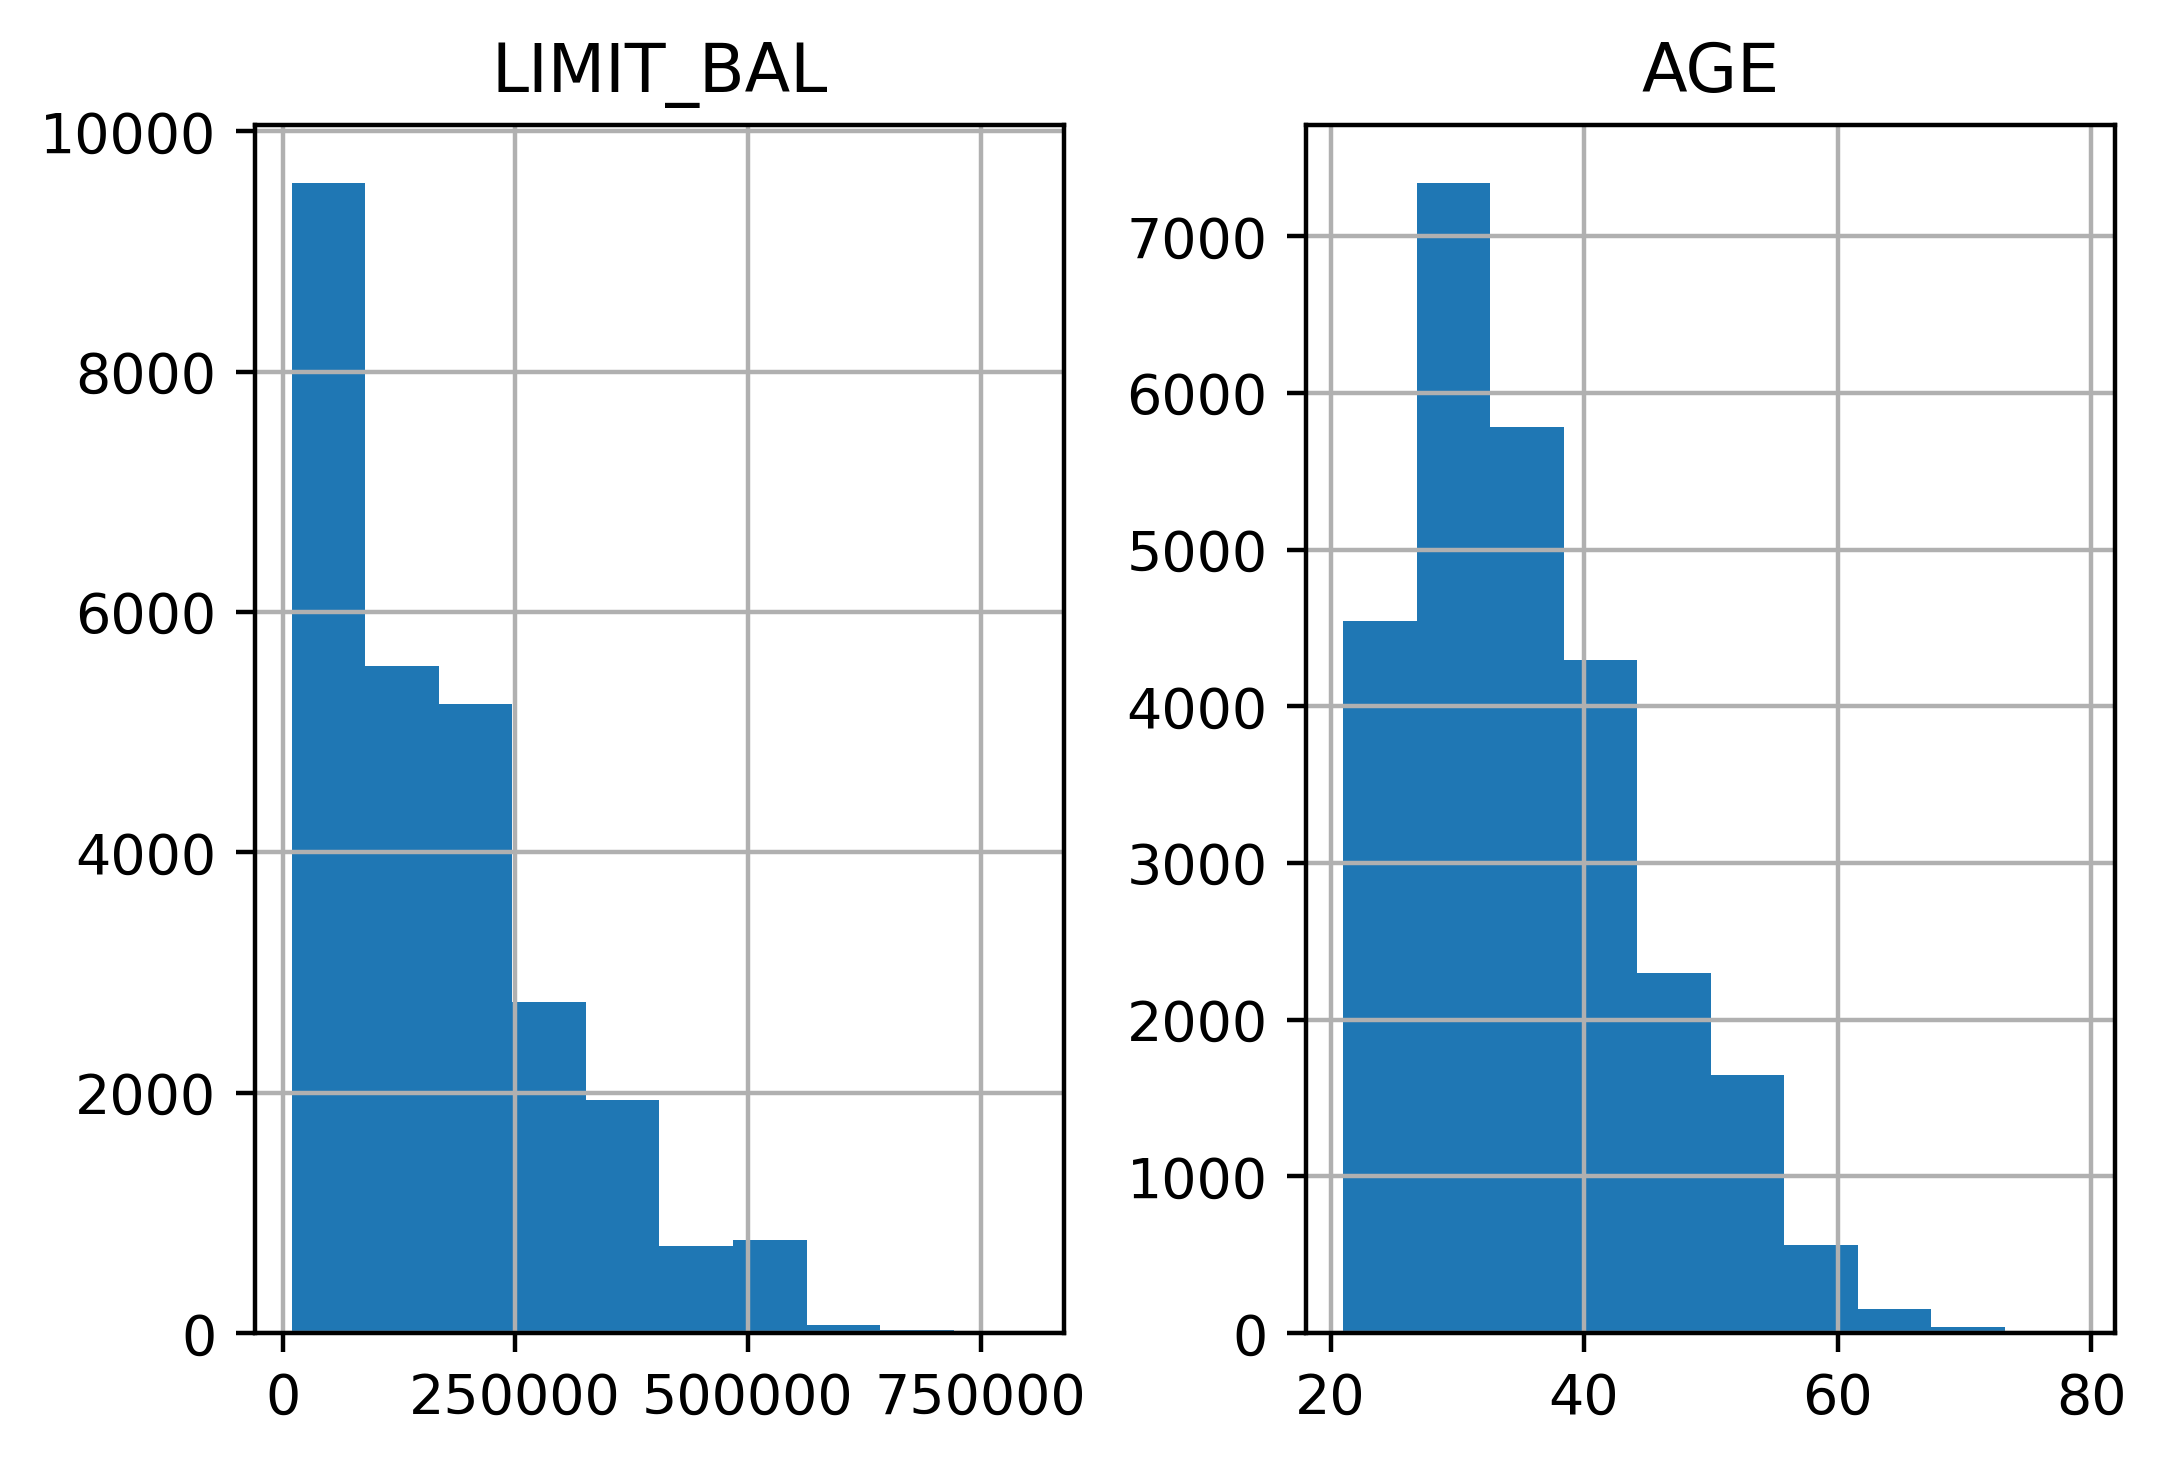

In [26]:
# Visual snapshot of AGE and LIMIT_BAL features
df_clean_2[["LIMIT_BAL", "AGE"]].hist()

In [27]:
# Generate a tabular report of summary statistics
df_clean_2[["LIMIT_BAL", "AGE"]].describe()

,LIMIT_BAL,AGE
count,26664.000000,26664.000000
mean,167919.054905,35.505213
std,129839.453081,9.227442
min,10000.000000,21.000000
25%,50000.000000,28.000000
50%,140000.000000,34.000000
75%,240000.000000,41.000000
max,800000.000000,79.000000


In [28]:
# Obtain the value counts for the EDUCATION feature
df_clean_2["EDUCATION"].value_counts()

2    12458
1     9412
3     4380
5      245
4      115
6       43
0       11
Name: EDUCATION, dtype: int64

We see undocumented education levels 0, 5, and 6. We will lump them in with the "other" category, which seems appropriate, with our client's blessing, of course.

In [29]:
# Combine the undocumented levels of the EDUCATION feature into the level for "others"
df_clean_2["EDUCATION"].replace(to_replace=[0, 5, 6], value=4, inplace=True)
df_clean_2["EDUCATION"].value_counts()

2    12458
1     9412
3     4380
4      414
Name: EDUCATION, dtype: int64

In [30]:
# Obtain the value counts for the MARRIAGE feature
df_clean_2["MARRIAGE"].value_counts()

2    14158
1    12172
3      286
0       48
Name: MARRIAGE, dtype: int64

The issue here is similar to that encountered for the EDUCATION feature; there is a value, 0, whch is not documented in the data dictionary.

In [31]:
# Combine the undocumented levels of the MARRIAGE feature into the level for "others"
df_clean_2["MARRIAGE"].replace(to_replace=0, value=3, inplace=True)
df_clean_2["MARRIAGE"].value_counts()

2    14158
1    12172
3      334
Name: MARRIAGE, dtype: int64

In [32]:
# Save the latest DataFrame to CSV
df_clean_2.to_csv('Data/cleaned_data.csv', index=False)

Exploring the financial history features in the dataset.
The remaining features to be examined are the financial history features. They fall naturally into three groups: the status of the monthly payments for the last six months, and the billed and paid amounts for the same period. 

In [33]:
# Load a DataFrame from CSV file
df = pd.read_csv('Data/cleaned_data.csv')

# Create a list for the status of the monthly payments for the last six months
pay_feats = ["PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]

# Examine summary statistics
df[pay_feats].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000
mean,-0.017777,-0.133363,-0.167679,-0.225023,-0.269764,-0.293579
std,1.126769,1.198640,1.199165,1.167897,1.131735,1.150229
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [34]:
# Check values of PAY_1
df[pay_feats[0]].value_counts().sort_index()

-2     2476
-1     5047
 0    13087
 1     3261
 2     2378
 3      292
 4       63
 5       23
 6       11
 7        9
 8       17
Name: PAY_1, dtype: int64

<AxesSubplot:>

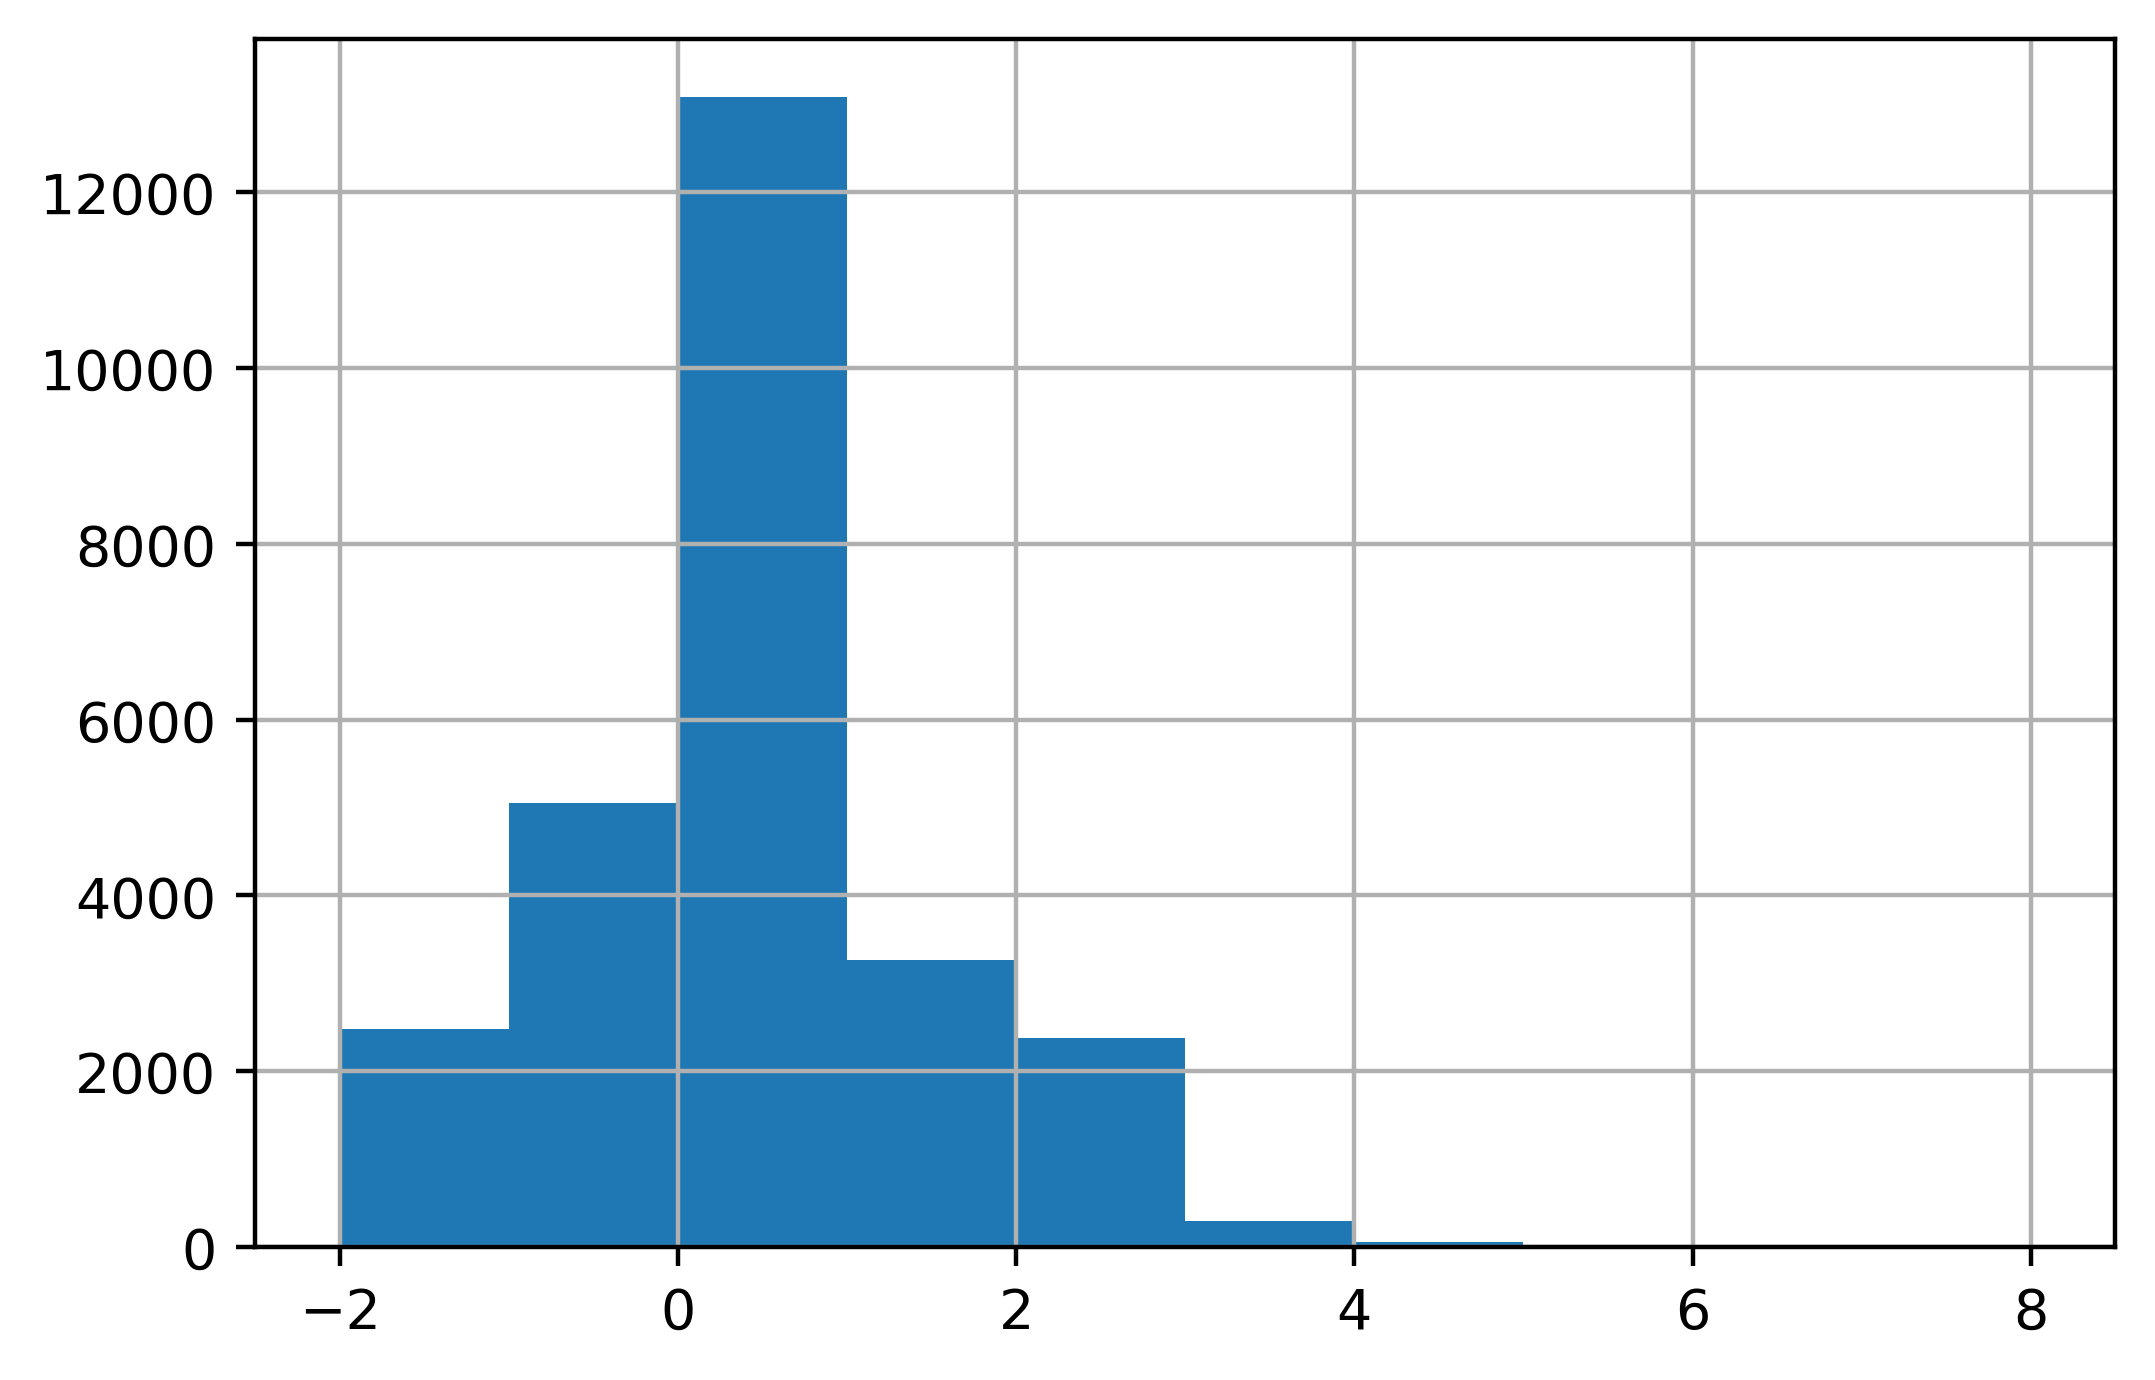

In [35]:
# Visual snapshot of PAY_1 feature
df[pay_feats[0]].hist()

Text(0, 0.5, 'Number of accounts')

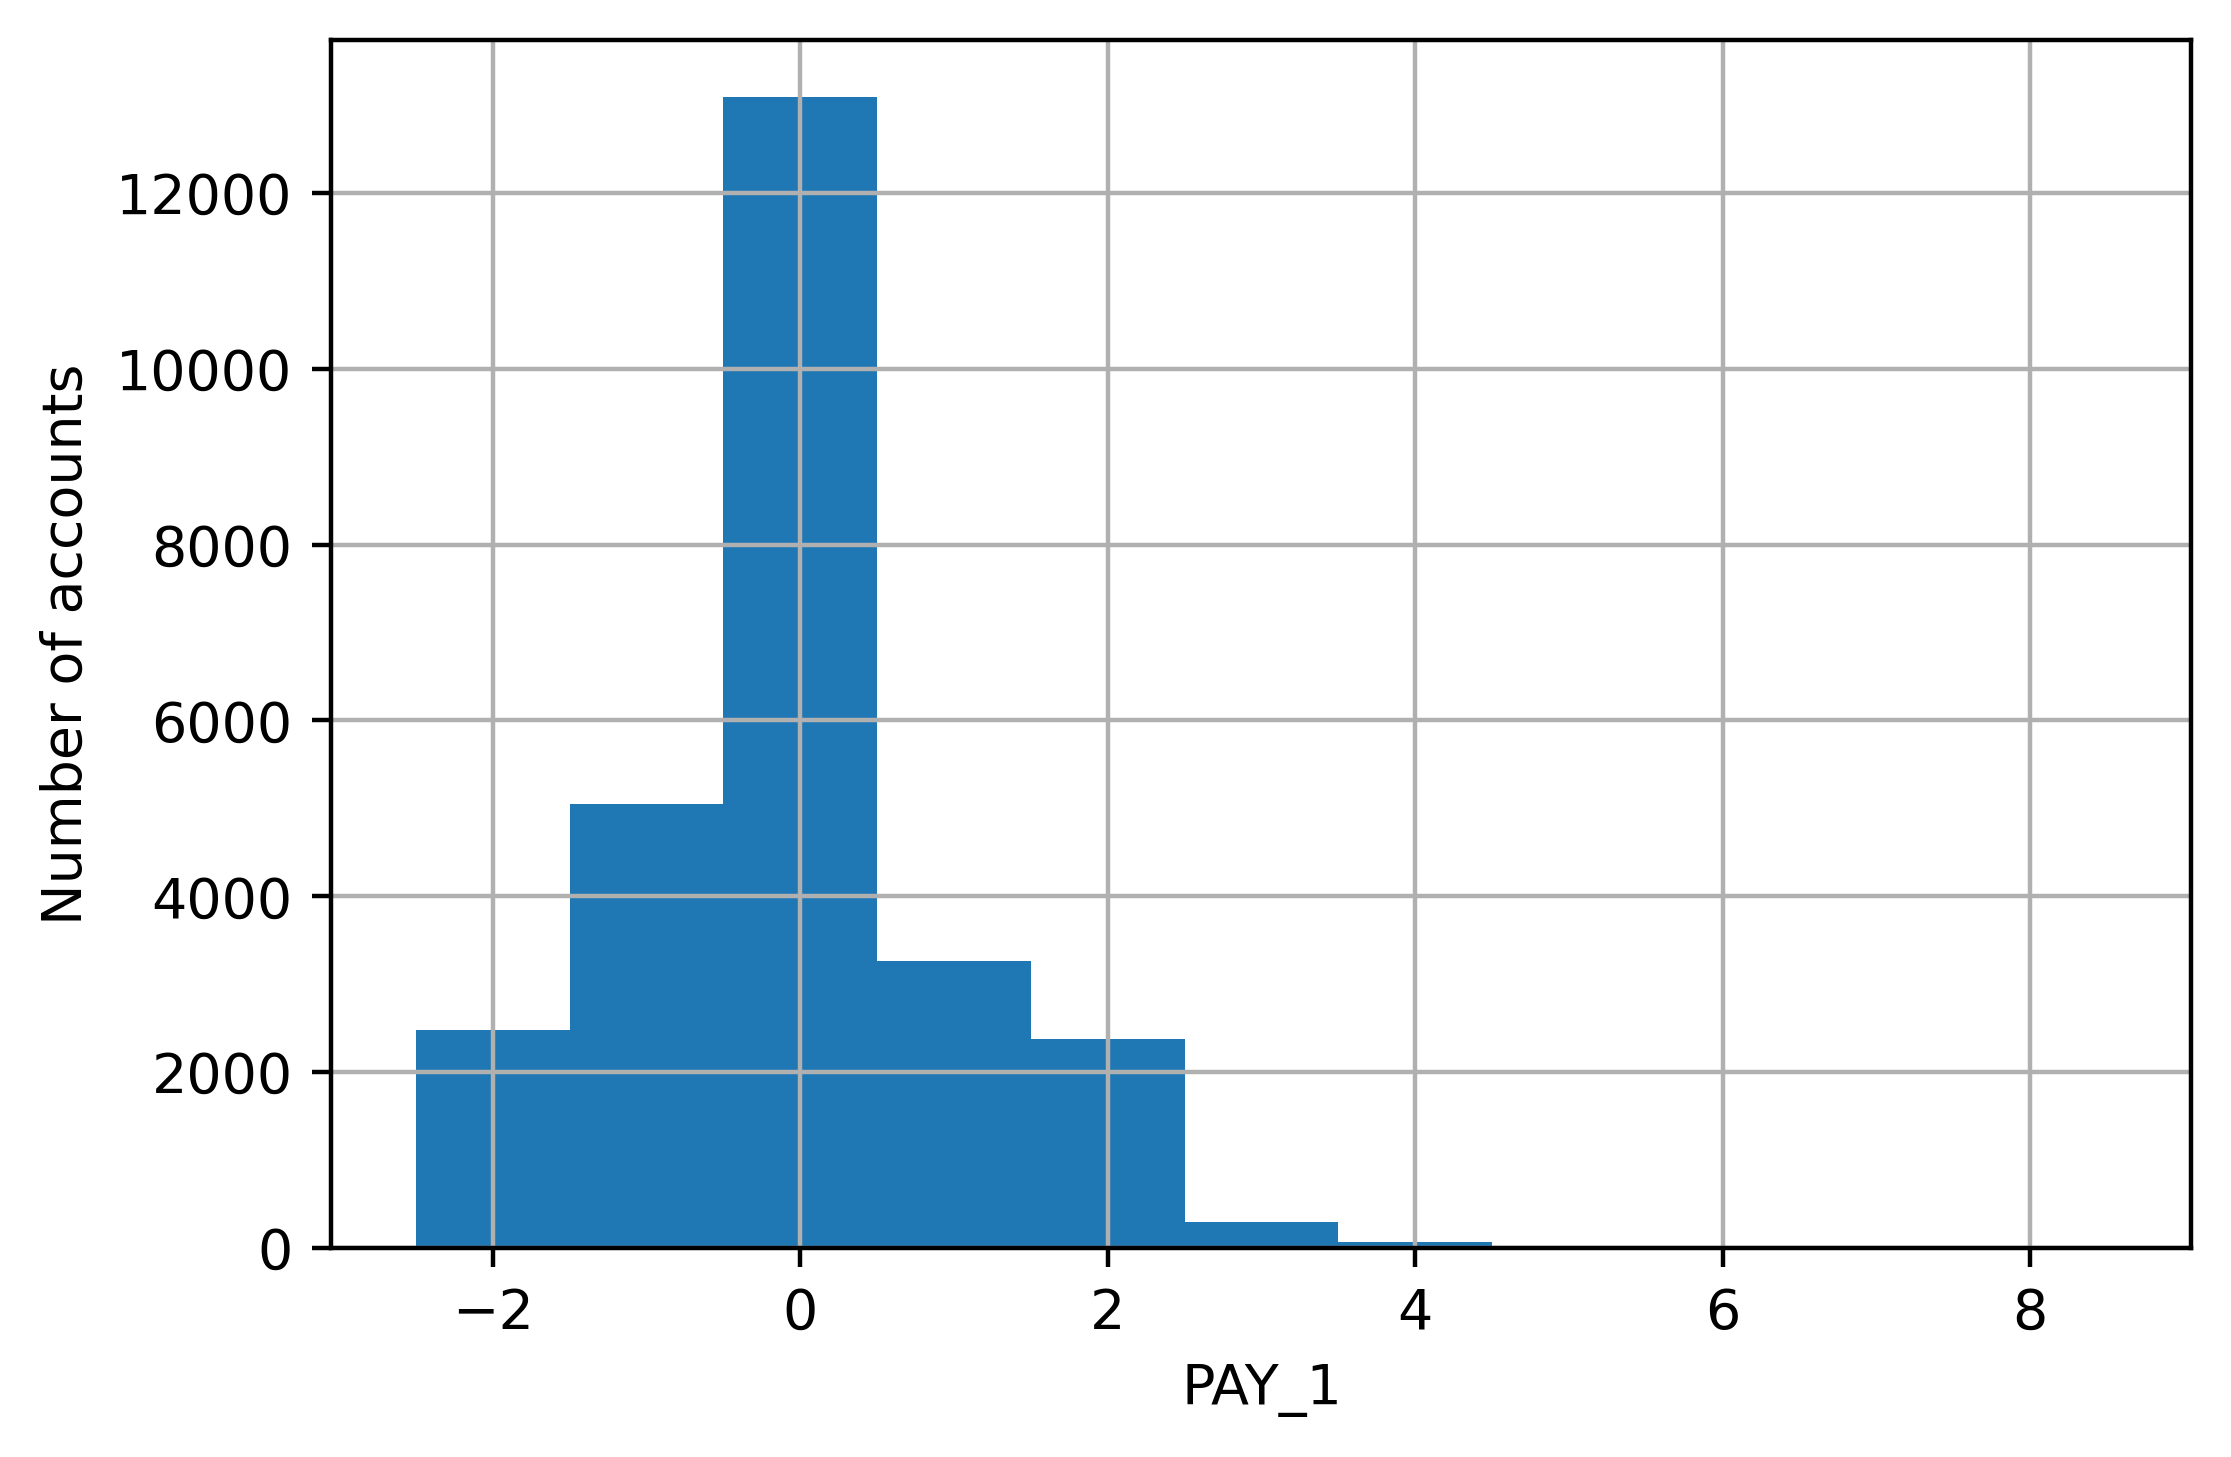

In [36]:
# Specify histogram bin edges
pay_1_bins = np.array(range(-2,10)) - 0.5
pay_1_bins

# Create and label histogram
df[pay_feats[0]].hist(bins=pay_1_bins)
plt.xlabel("PAY_1")
plt.ylabel("Number of accounts")

array([[<AxesSubplot:title={'center':'PAY_1'}>,
        <AxesSubplot:title={'center':'PAY_2'}>,
        <AxesSubplot:title={'center':'PAY_3'}>],
       [<AxesSubplot:title={'center':'PAY_4'}>,
        <AxesSubplot:title={'center':'PAY_5'}>,
        <AxesSubplot:title={'center':'PAY_6'}>]], dtype=object)

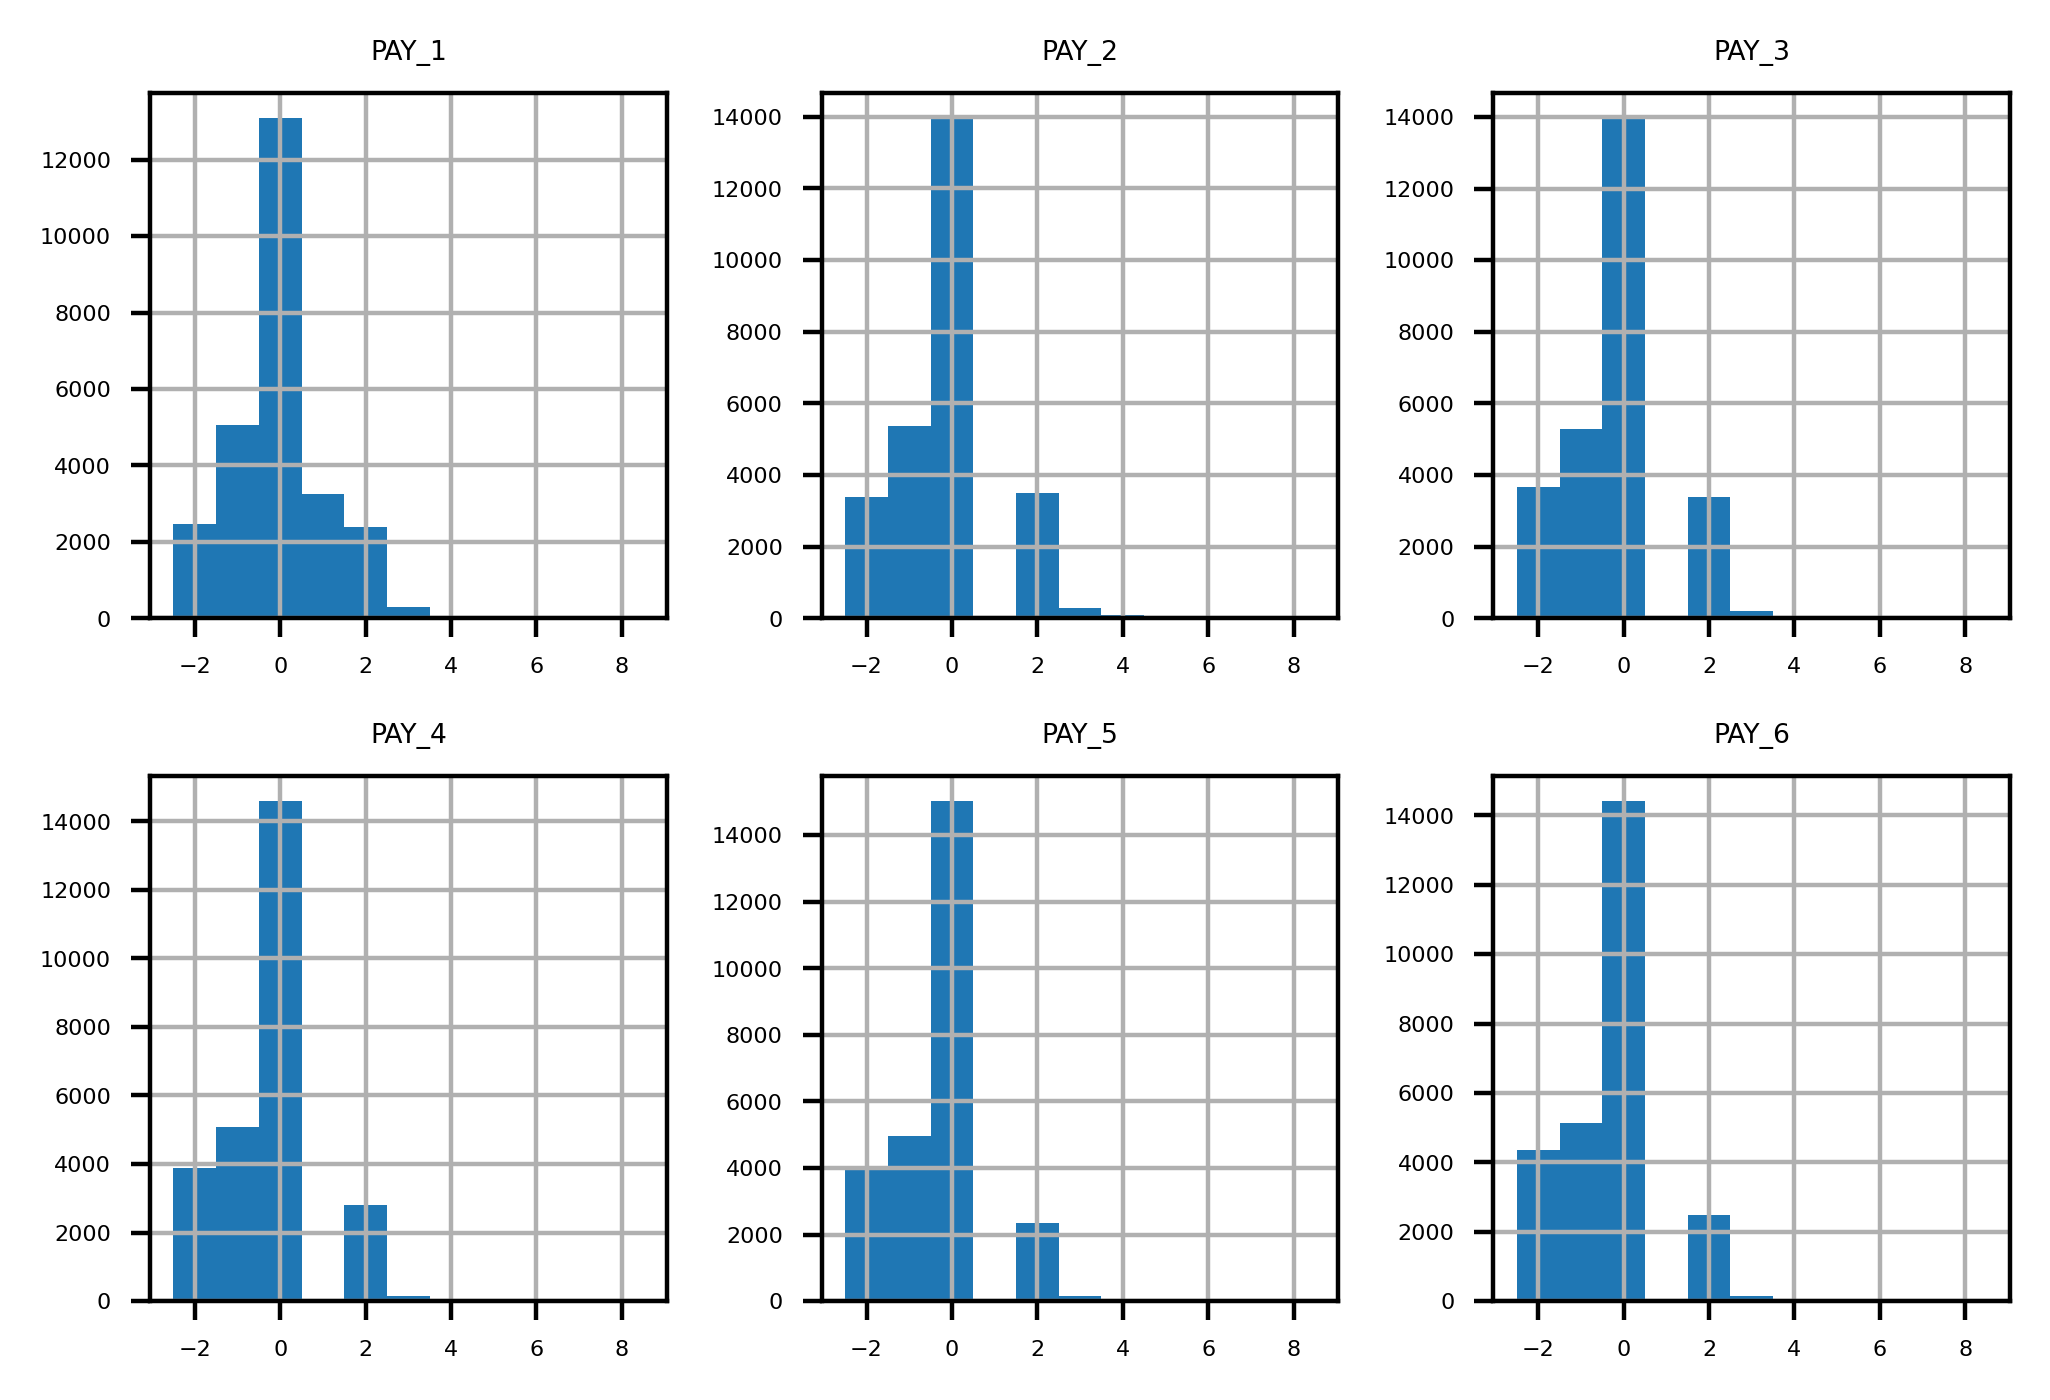

In [37]:
# Plot multiple histograms together and visualize the payment status features for each of the last six months
mpl.rcParams["font.size"] = 4
df[pay_feats].hist(bins=pay_1_bins, layout=(2,3))

In July (PAY_3), there are very few accounts that had 1-month payment delay. However, in August (PAY-2), there are suddenly thousands of accounts with a 2-month payment delay. This does not make sense: the number of accounts with a 2-month delay in a given month should be less than or equal to the number of accounts with a 1-month delay in the previous month. The client lets us know that they had been having problems with pulling the most recent month of data, leading to faulty reporting for accounts that had a 1-month delay in payment. Because of this, only the most recent month of our payment status data is correct. Only PAY_1 is representative of future data, those that will be used to make predictions with the model we develop.

In [38]:
# Create lists of feature names for the remaining financial features
bill_feats = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
pay_amt_feats = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [39]:
# Examine statistical summaries of the bill amount features
df[bill_feats].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000
mean,51405.730723,49300.001500,47026.340047,43338.894539,40338.136701,38889.872337
std,73633.687106,70934.549534,68705.359524,64275.250740,60705.944083,59432.541657
min,-165580.000000,-69777.000000,-157264.000000,-170000.000000,-81334.000000,-339603.000000
25%,3580.000000,2999.750000,2627.250000,2341.750000,1745.000000,1256.000000
50%,22361.000000,21150.000000,20079.500000,19037.000000,18066.000000,17005.000000
75%,67649.750000,64395.500000,60360.000000,54727.500000,50290.500000,49253.750000
max,746814.000000,671563.000000,855086.000000,706864.000000,823540.000000,699944.000000


array([[<AxesSubplot:title={'center':'BILL_AMT1'}>,
        <AxesSubplot:title={'center':'BILL_AMT2'}>,
        <AxesSubplot:title={'center':'BILL_AMT3'}>],
       [<AxesSubplot:title={'center':'BILL_AMT4'}>,
        <AxesSubplot:title={'center':'BILL_AMT5'}>,
        <AxesSubplot:title={'center':'BILL_AMT6'}>]], dtype=object)

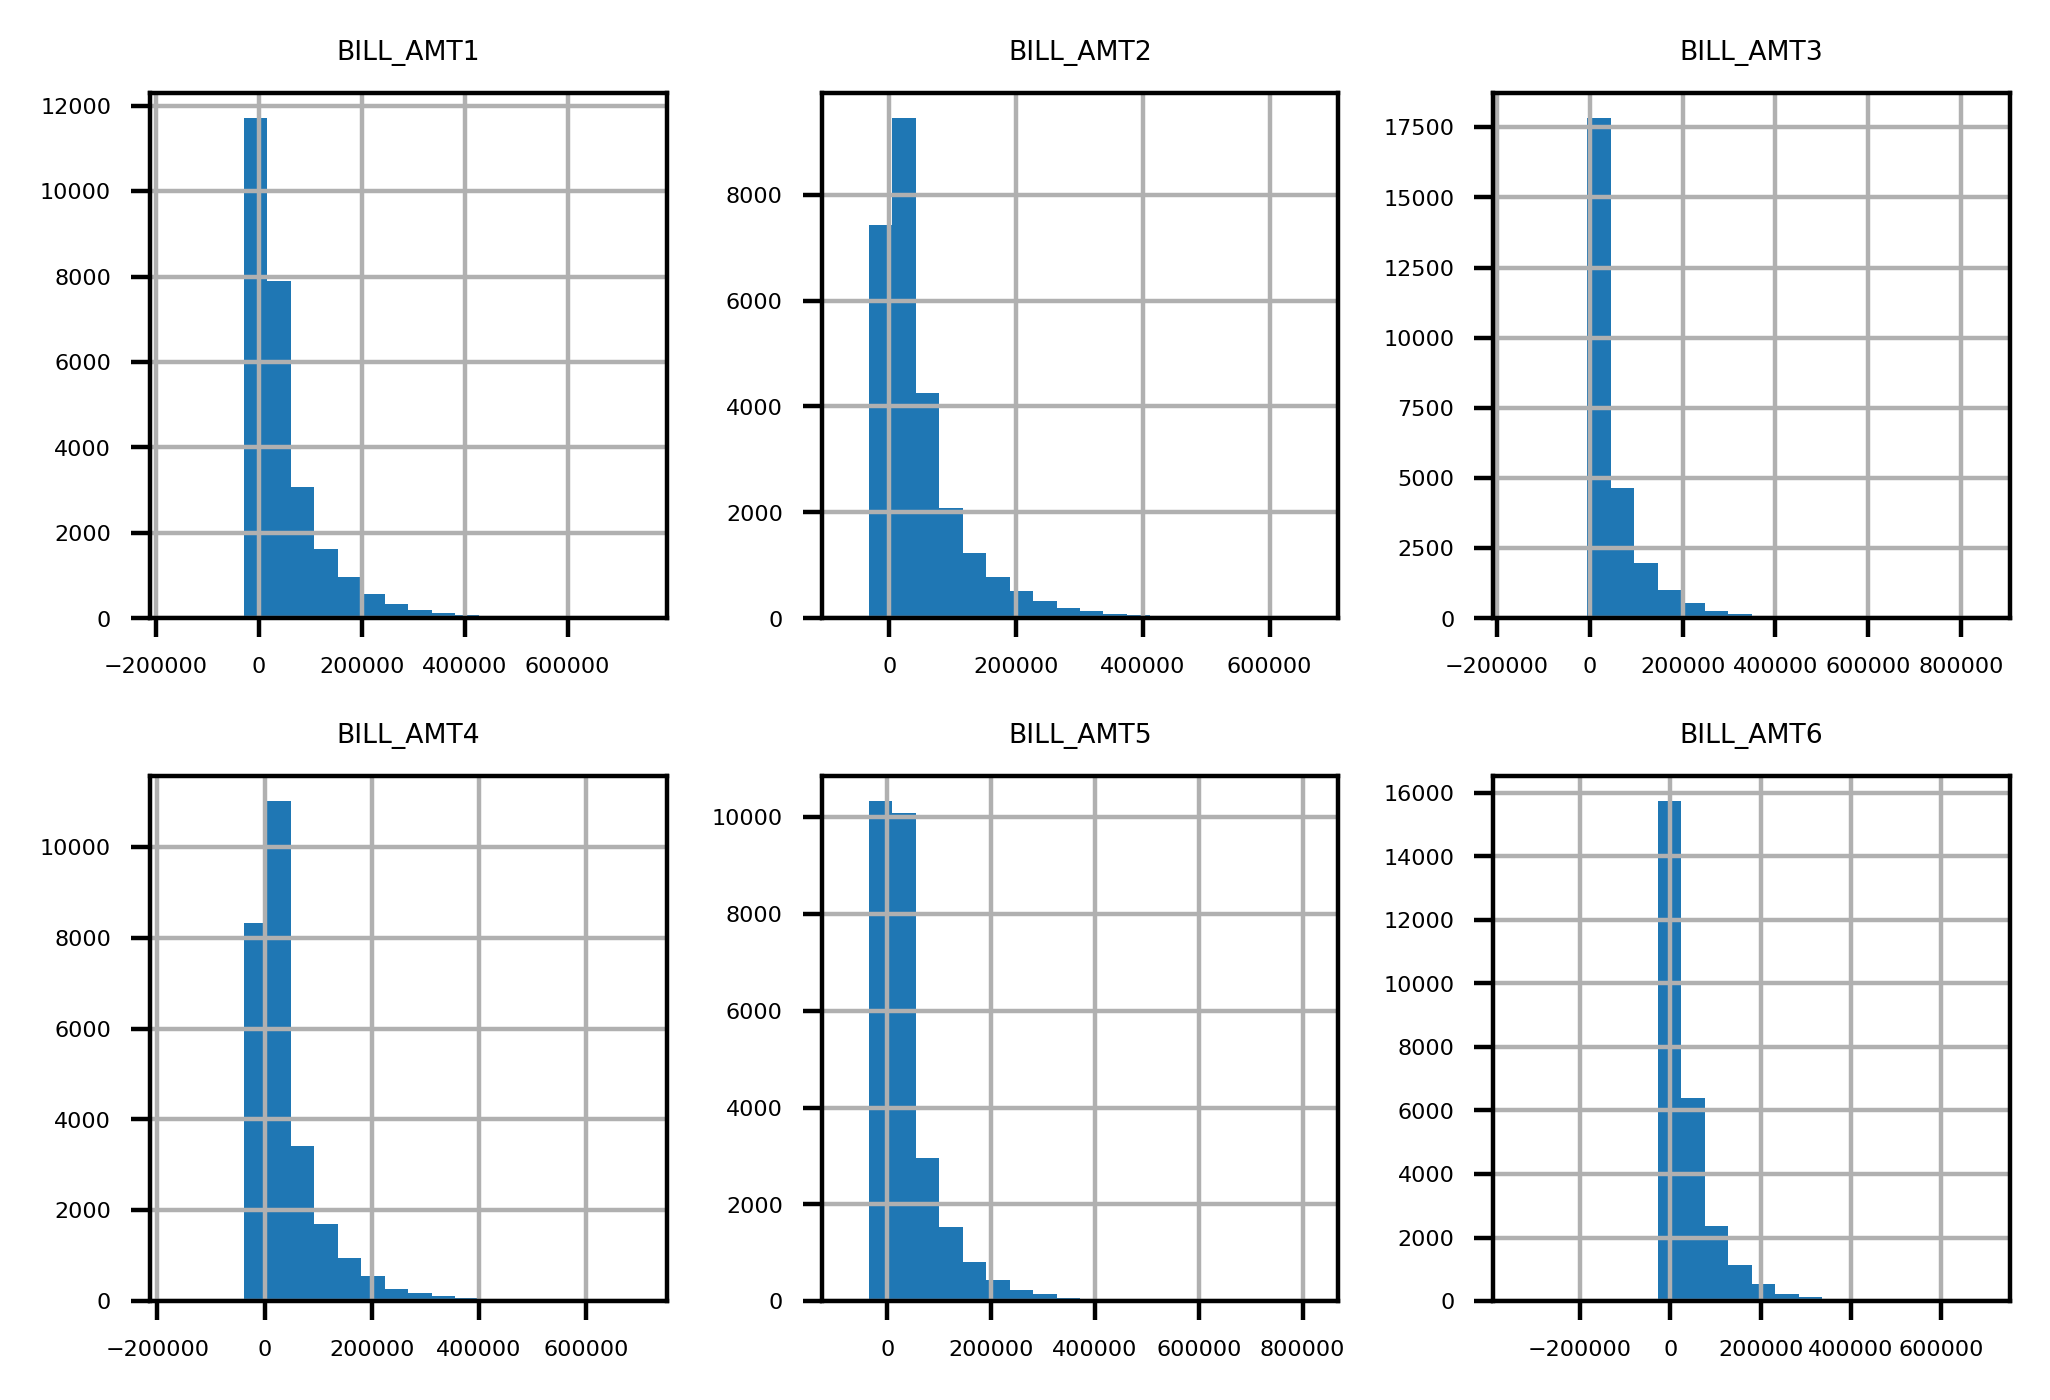

In [40]:
# Visualize the bill amount features
mpl.rcParams["font.size"] = 4
df[bill_feats].hist(bins=20, layout=(2,3))

In [41]:
# Examine statistical summaries of the payment amount features
df[pay_amt_feats].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,26664.000000,2.666400e+04,26664.000000,26664.000000,26664.000000,26664.000000
mean,5704.085771,5.881110e+03,5259.514964,4887.048717,4843.729973,5257.843047
std,16699.398632,2.121431e+04,17265.439561,15956.349371,15311.721795,17635.468185
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,8.020000e+02,390.000000,294.750000,242.750000,111.000000
50%,2114.500000,2.007000e+03,1822.000000,1500.000000,1500.000000,1500.000000
75%,5027.000000,5.000000e+03,4556.250000,4050.500000,4082.750000,4015.000000
max,873552.000000,1.227082e+06,889043.000000,621000.000000,426529.000000,528666.000000


array([[<AxesSubplot:title={'center':'PAY_1'}>,
        <AxesSubplot:title={'center':'PAY_2'}>,
        <AxesSubplot:title={'center':'PAY_3'}>],
       [<AxesSubplot:title={'center':'PAY_4'}>,
        <AxesSubplot:title={'center':'PAY_5'}>,
        <AxesSubplot:title={'center':'PAY_6'}>]], dtype=object)

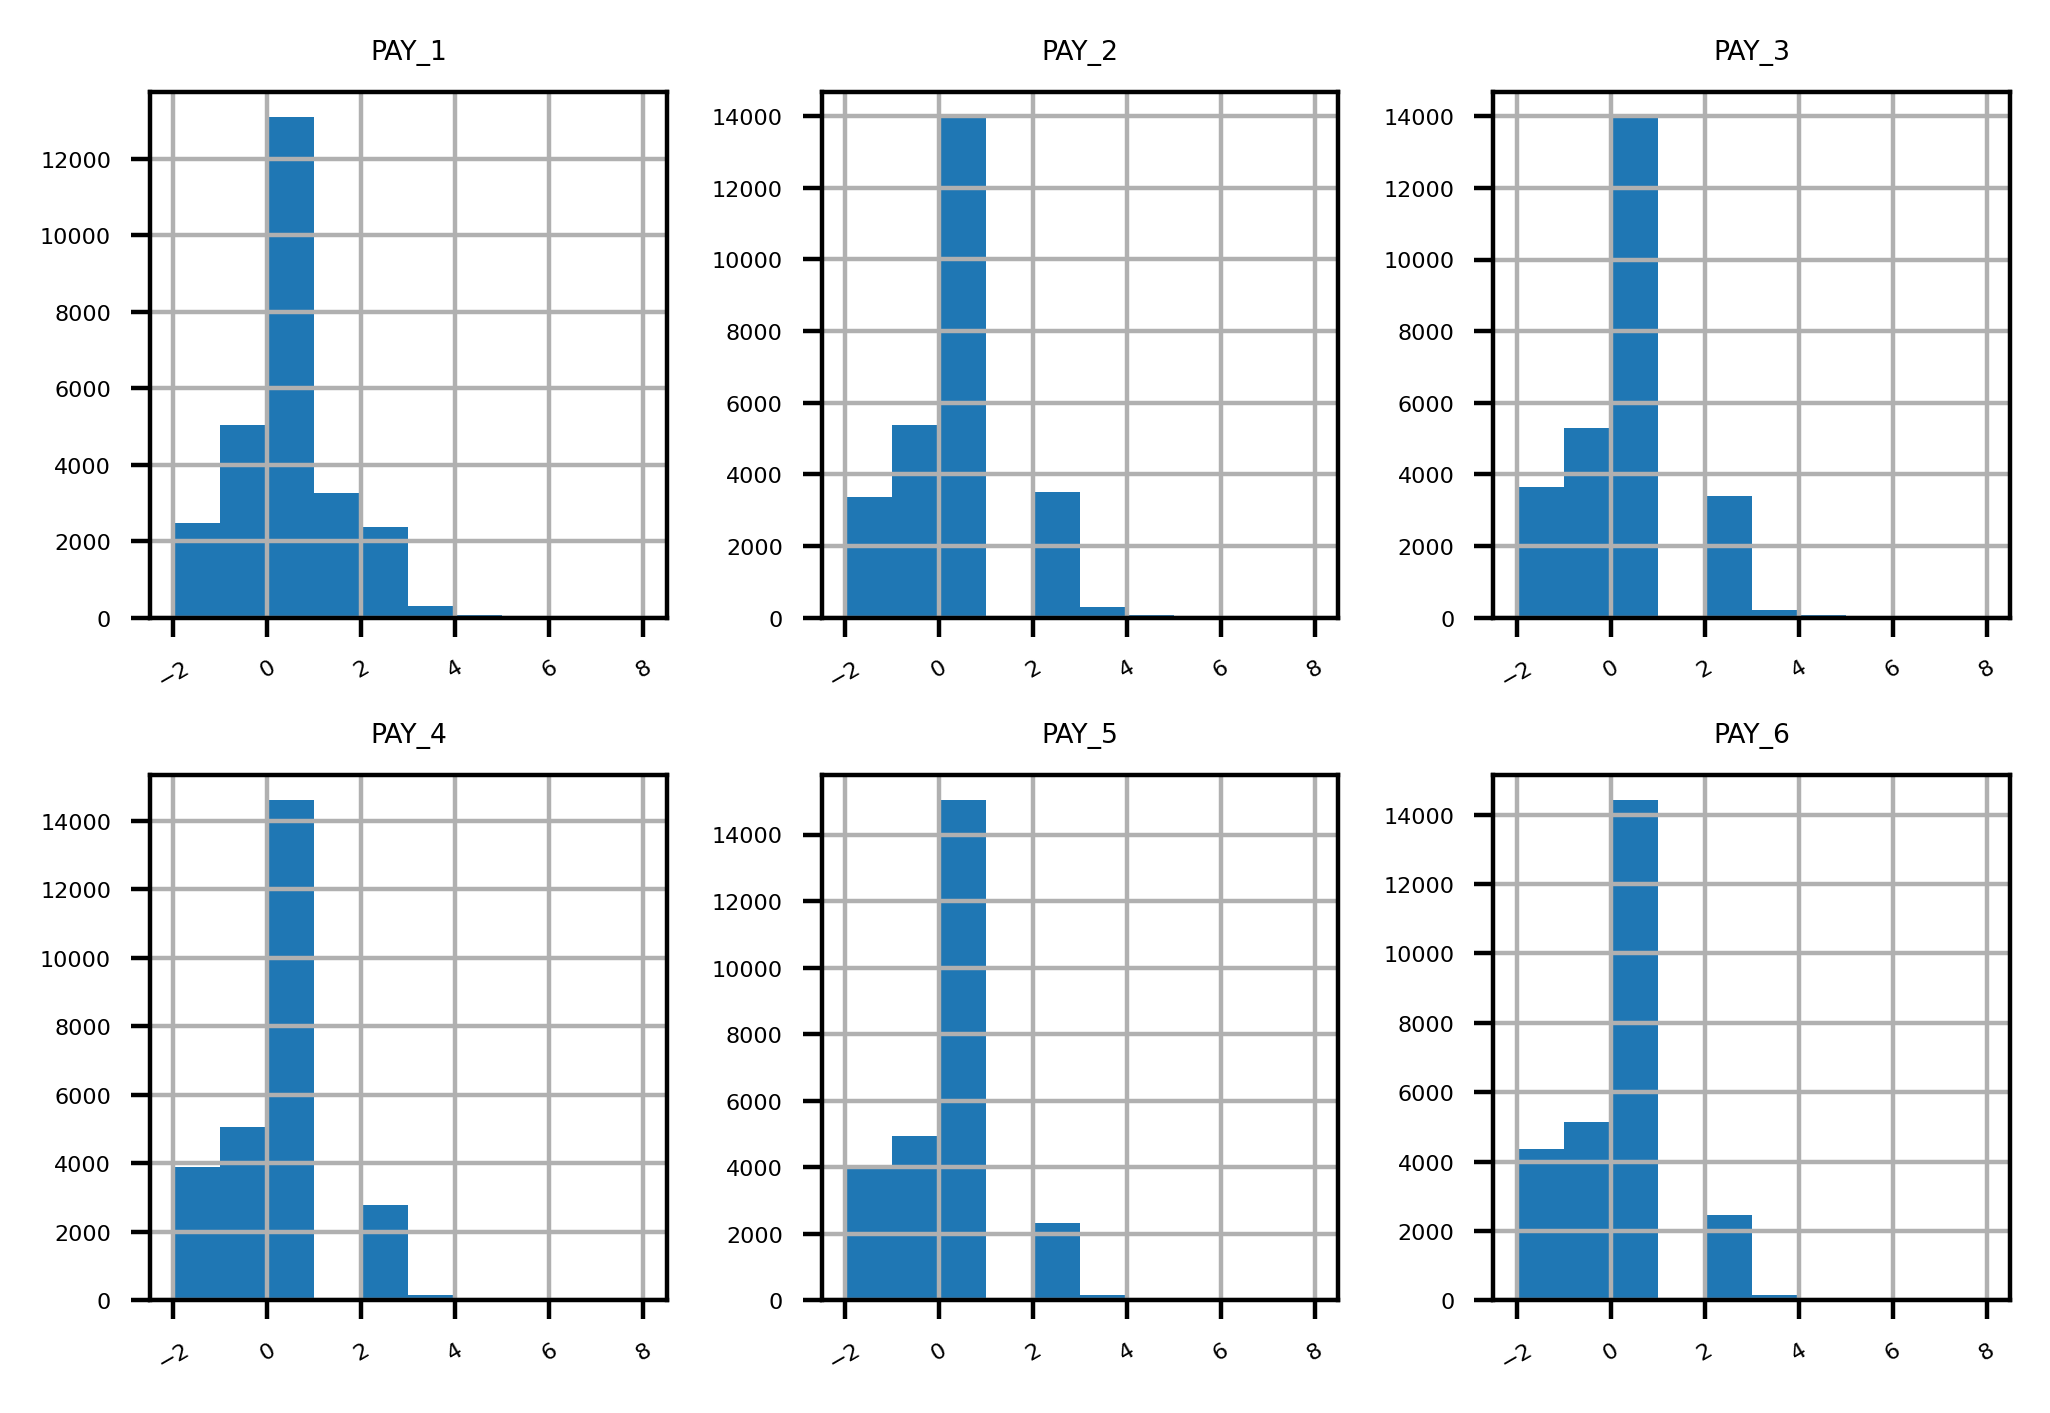

In [42]:
# Visualize the payment amount features
mpl.rcParams["font.size"] = 4
df[pay_feats].hist(layout=(2,3), xrot=30)

In [43]:
# Use a Boolean mask to see how many of the payment amount data are exactly equal to 0
pay_zero_mask = df[pay_amt_feats] == 0
pay_zero_mask.head()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,True,False,True,True,True,True
1,True,False,False,False,True,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False


In [44]:
pay_zero_mask.sum()

PAY_AMT1    4656
PAY_AMT2    4833
PAY_AMT3    5293
PAY_AMT4    5697
PAY_AMT5    5981
PAY_AMT6    6373
dtype: int64

array([[<AxesSubplot:title={'center':'PAY_AMT1'}>,
        <AxesSubplot:title={'center':'PAY_AMT2'}>,
        <AxesSubplot:title={'center':'PAY_AMT3'}>],
       [<AxesSubplot:title={'center':'PAY_AMT4'}>,
        <AxesSubplot:title={'center':'PAY_AMT5'}>,
        <AxesSubplot:title={'center':'PAY_AMT6'}>]], dtype=object)

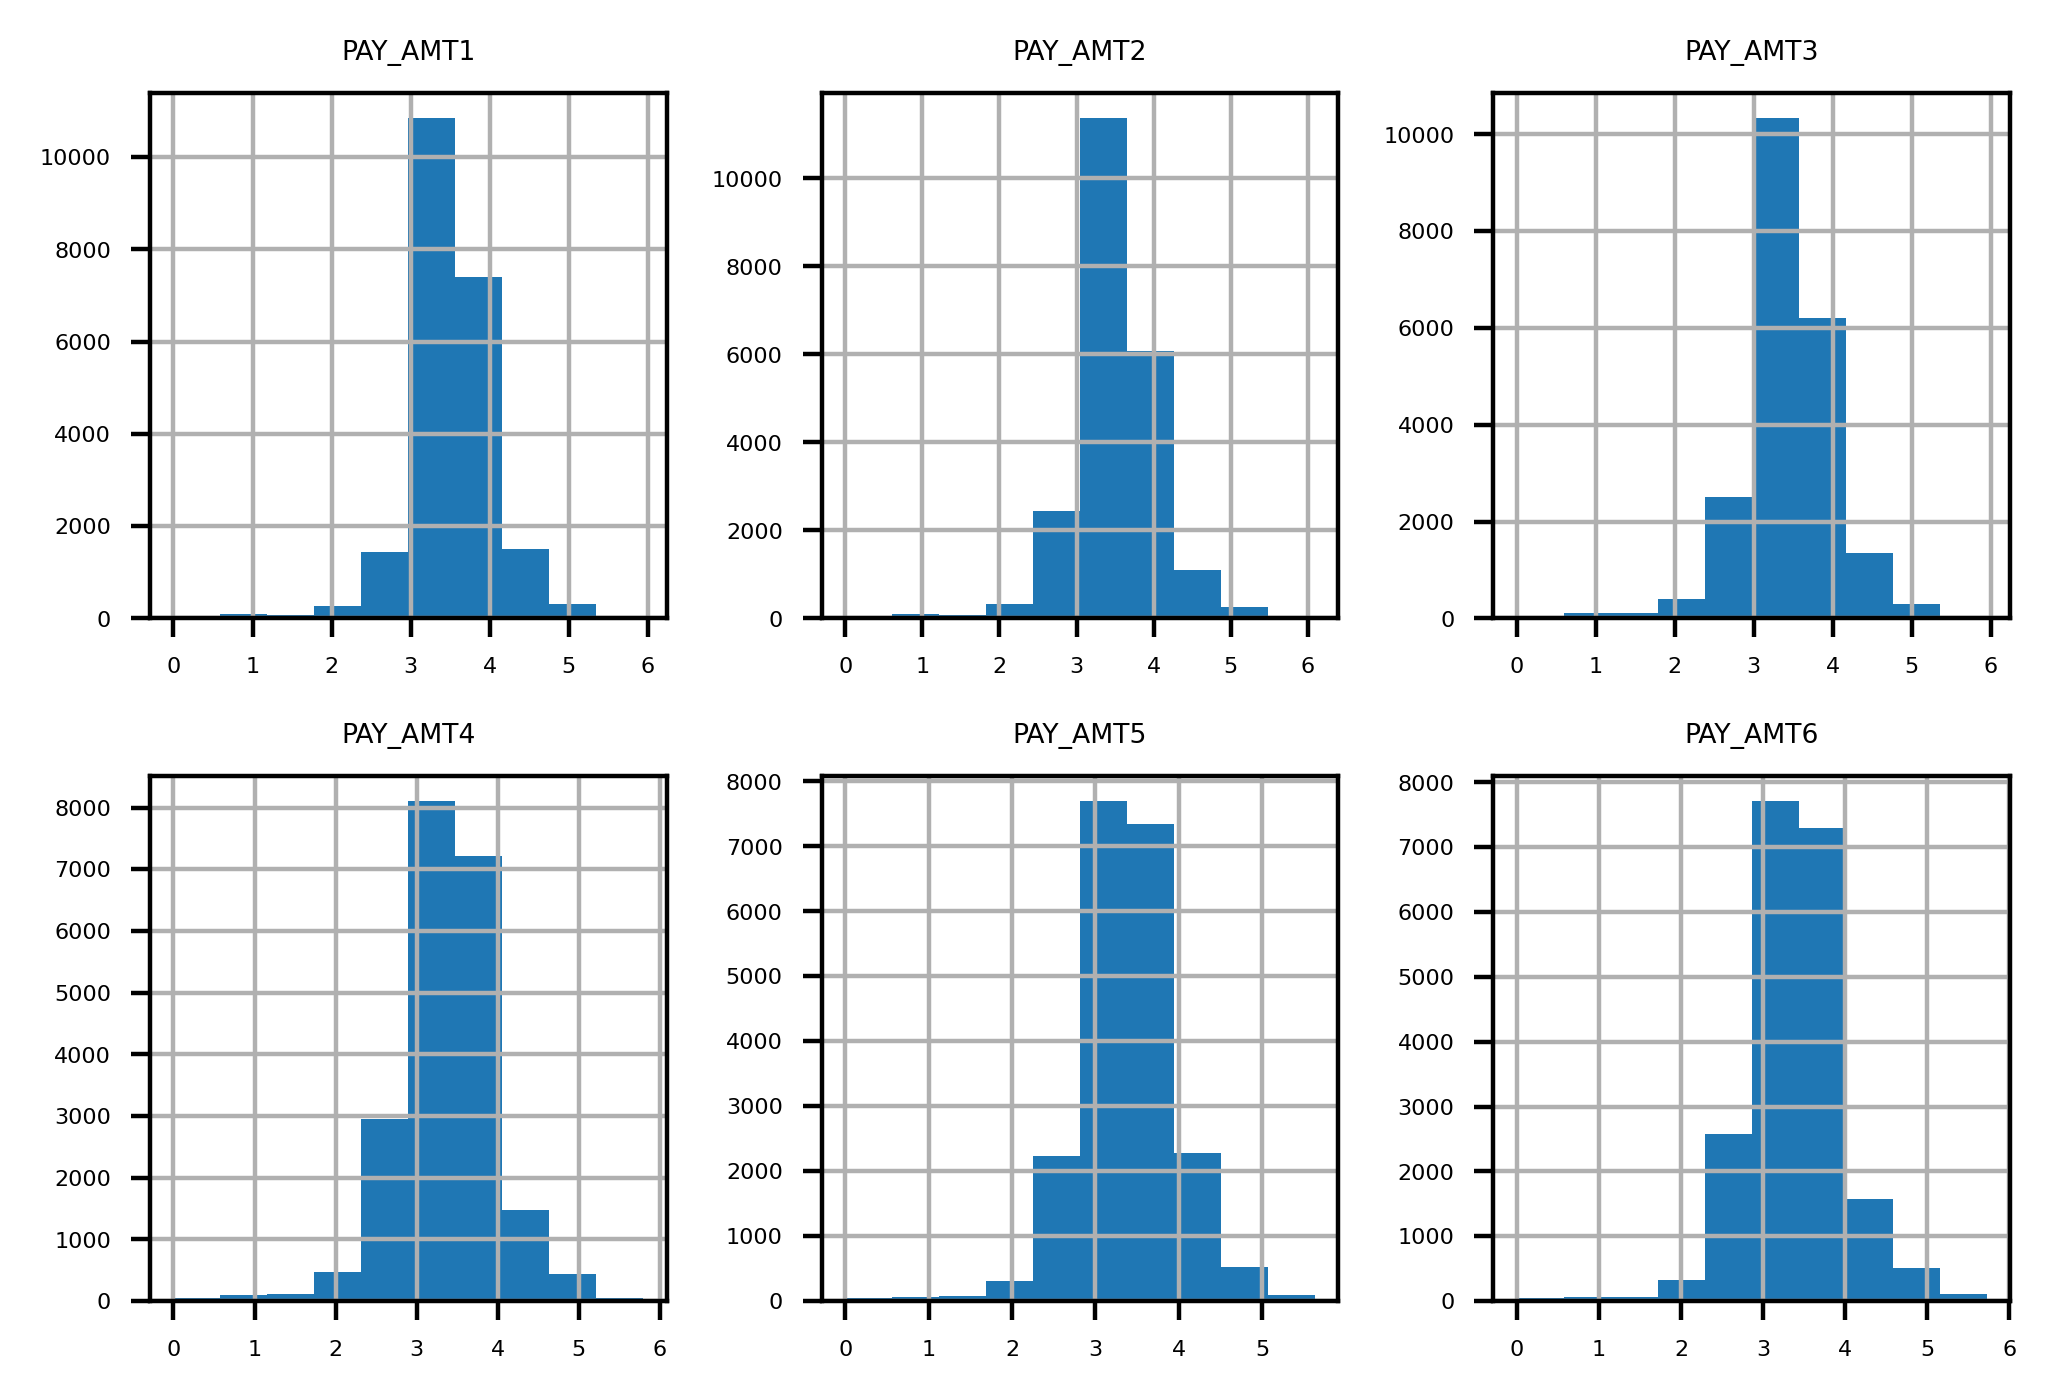

In [45]:
# Plot histograms of logarithmic transformations of the non-zero payments
df[pay_amt_feats][~pay_zero_mask].apply(np.log10).hist(layout=(2,3))

Exploring the response variable and concluding the initial exploration.
We finish our exploration of the data by examining the response variable. The key piece of information to examine regarding the response of a binary classification problem is: what is the proportion of the positive class?

In [46]:
# Find the proportion of the positive class (default rate)
df["default payment next month"].mean()

0.2217971797179718

In [47]:
#  Check the number of samples in each class
df.groupby("default payment next month")["ID"].count()

default payment next month
0    20750
1     5914
Name: ID, dtype: int64

In [48]:
features_response = df.columns.tolist()
features_response

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

Feature exploration. We will start to develop techniques that can be used to assess features one by one. This will enable making a quick pass over all the features to see which ones could be expected to be useful for predictive modeling. For the most promising features, we will see how to create visual summaries that serve as useful communication tools.
We are not to use the gender variable due to ethical concerns, and PAY_2, PAY_3, ..., PAY_6 are incorrect and should be ignored. It makes no sense to use ID as a feature, since this is simply a unique account identifier and has nothing to do with the response variable.

In [49]:
# Make a list of column names we want to exclude
items_to_remove = ["ID", "SEX", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]

In [50]:
# Reassing the features_response variable with a list containing everything that's not in the list of strings we wish to remove
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [51]:
# Pearson correlation is used to measure the strength and direction (positive or negative) of the linear relationship between two variables
corr = df[features_response].corr()
corr.iloc[0:5, 0:5]

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_1
LIMIT_BAL,1.000000,-0.232688,-0.111873,0.149157,-0.273396
EDUCATION,-0.232688,1.000000,-0.137097,0.179035,0.112653
MARRIAGE,-0.111873,-0.137097,1.000000,-0.412828,0.019759
AGE,0.149157,0.179035,-0.412828,1.000000,-0.044277
PAY_1,-0.273396,0.112653,0.019759,-0.044277,1.000000


<AxesSubplot:>

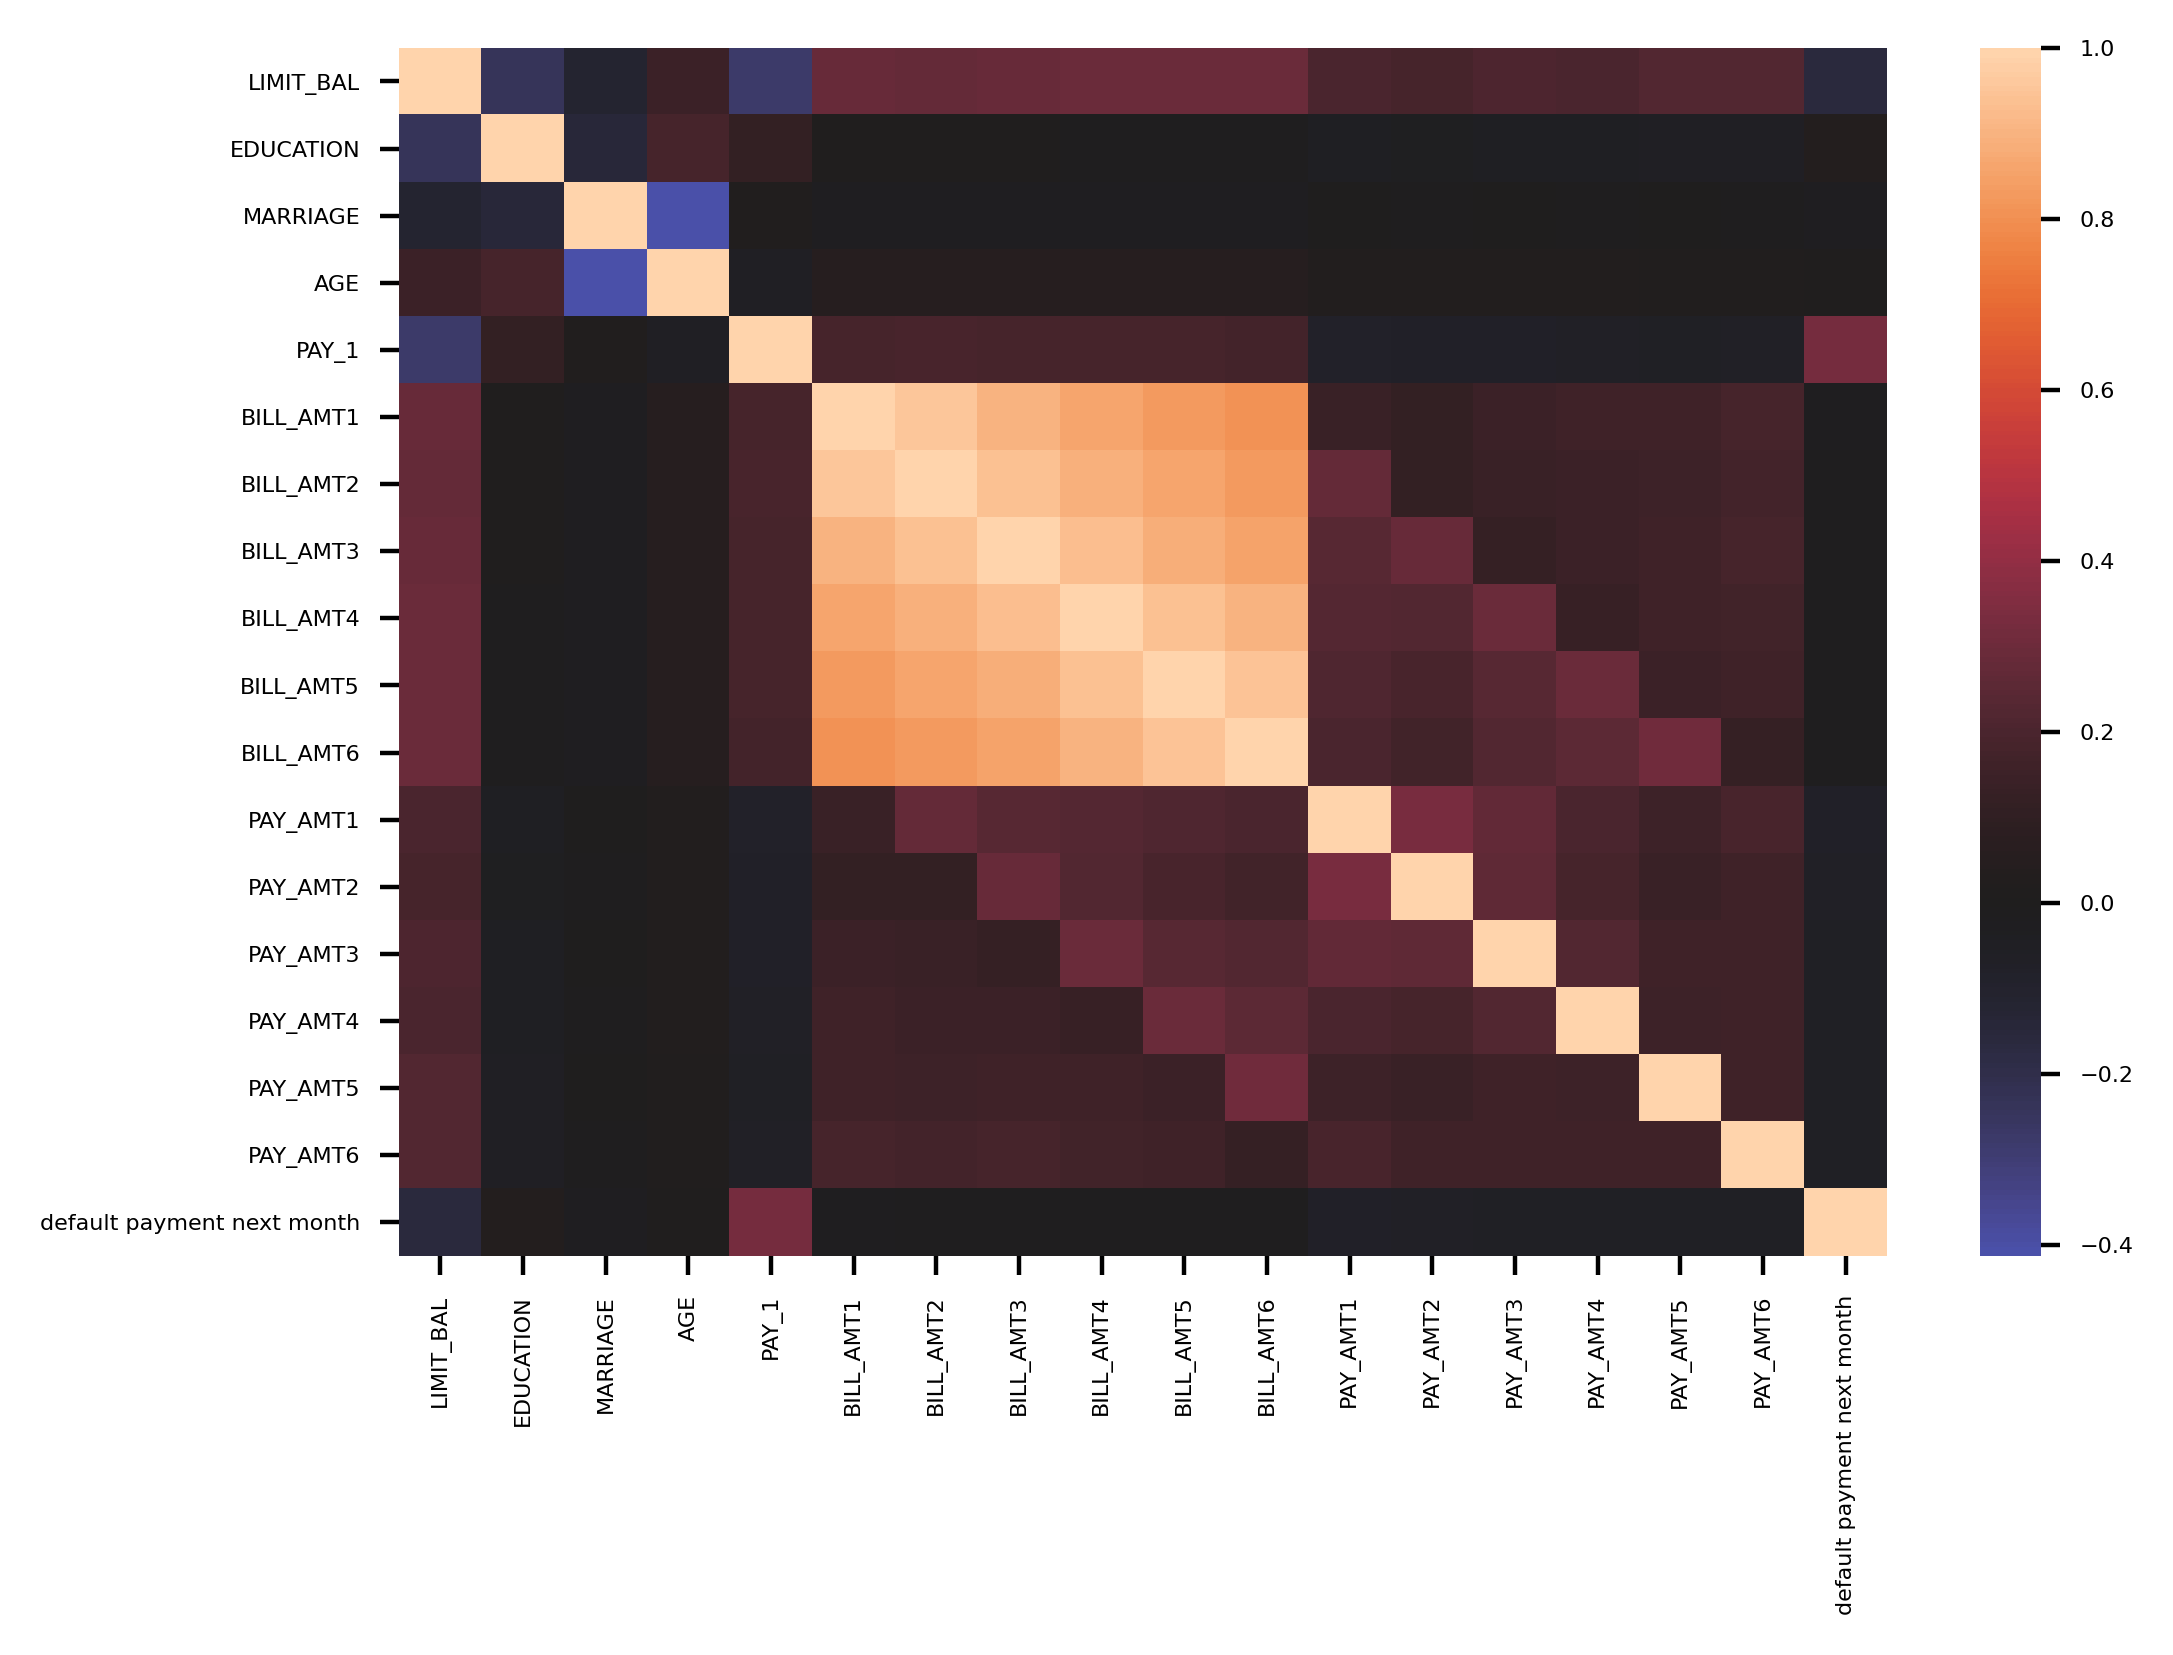

In [52]:
# Plot the correlation matrix (heatmap)
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, center=0)

PAY_1 is likely going to be the best, most predictive feature for our model. The other feature that looks like it maybe important is LIMIT_BAL, which is negatively correlated.

Next we will use the F-test to examine the relation between features and response.

In [53]:
# Separate out the features and response as NumPy arrays
X = df[features_response].iloc[:,:-1].values
y = df[features_response].iloc[:,-1].values
print(X.shape, y.shape)

(26664, 17) (26664,)


In [54]:
# Import the f_classif function and feed in the features and response
from sklearn.feature_selection import f_classif
[f_stat, f_p_value] = f_classif(X, y)

In [55]:
# Create a DataFrame of feature names, F-statistics, and p-values, and show it sorted on p-value
f_test_df = pd.DataFrame({"Feature" :features_response[:-1], "F statistic" :f_stat, "p value" :f_p_value})
f_test_df.sort_values("p value")

,Feature,F statistic,p value
4,PAY_1,3156.672300,0.000000e+00
0,LIMIT_BAL,651.324071,5.838366e-142
11,PAY_AMT1,140.612679,2.358354e-32
12,PAY_AMT2,101.408321,8.256124e-24
13,PAY_AMT3,90.023873,2.542641e-21
15,PAY_AMT5,85.843295,2.090120e-20
16,PAY_AMT6,80.420784,3.219565e-19
14,PAY_AMT4,79.640021,4.774112e-19
1,EDUCATION,32.637768,1.122175e-08
2,MARRIAGE,18.078027,2.127555e-05


PAY_1 and LIMIT_BAL appear to be the most useful features. They have the smallest p-values, indicating the average values of these features between the positive and negative classes are significantly different, and these features will help predict which class a sample belongs to. PAY_1 is the payment status of the account, in the most recent month. This should make sense: people who have defaulted before are probably at the highest risk of defaulting again. As for LIMIT_BAL we may expect to see a higher probability of default for accounts with lower values. By visualizing the relationships between the features and the response variable, we can determine whether our ideas are compatible with what we can see in the data.

In [56]:
# Calculate a baseline for the response variable of the default rate across the whole dataset
overall_default_rate = df["default payment next month"].mean()
overall_default_rate

0.2217971797179718

In [57]:
# Create a groupby/mean aggregation
group_by_pay_mean_y = df.groupby("PAY_1").agg({"default payment next month":np.mean})
group_by_pay_mean_y

,default payment next month
PAY_1,
-2,0.131664
-1,0.170002
0,0.128295
1,0.336400
2,0.694701
3,0.773973
4,0.682540
5,0.434783
6,0.545455


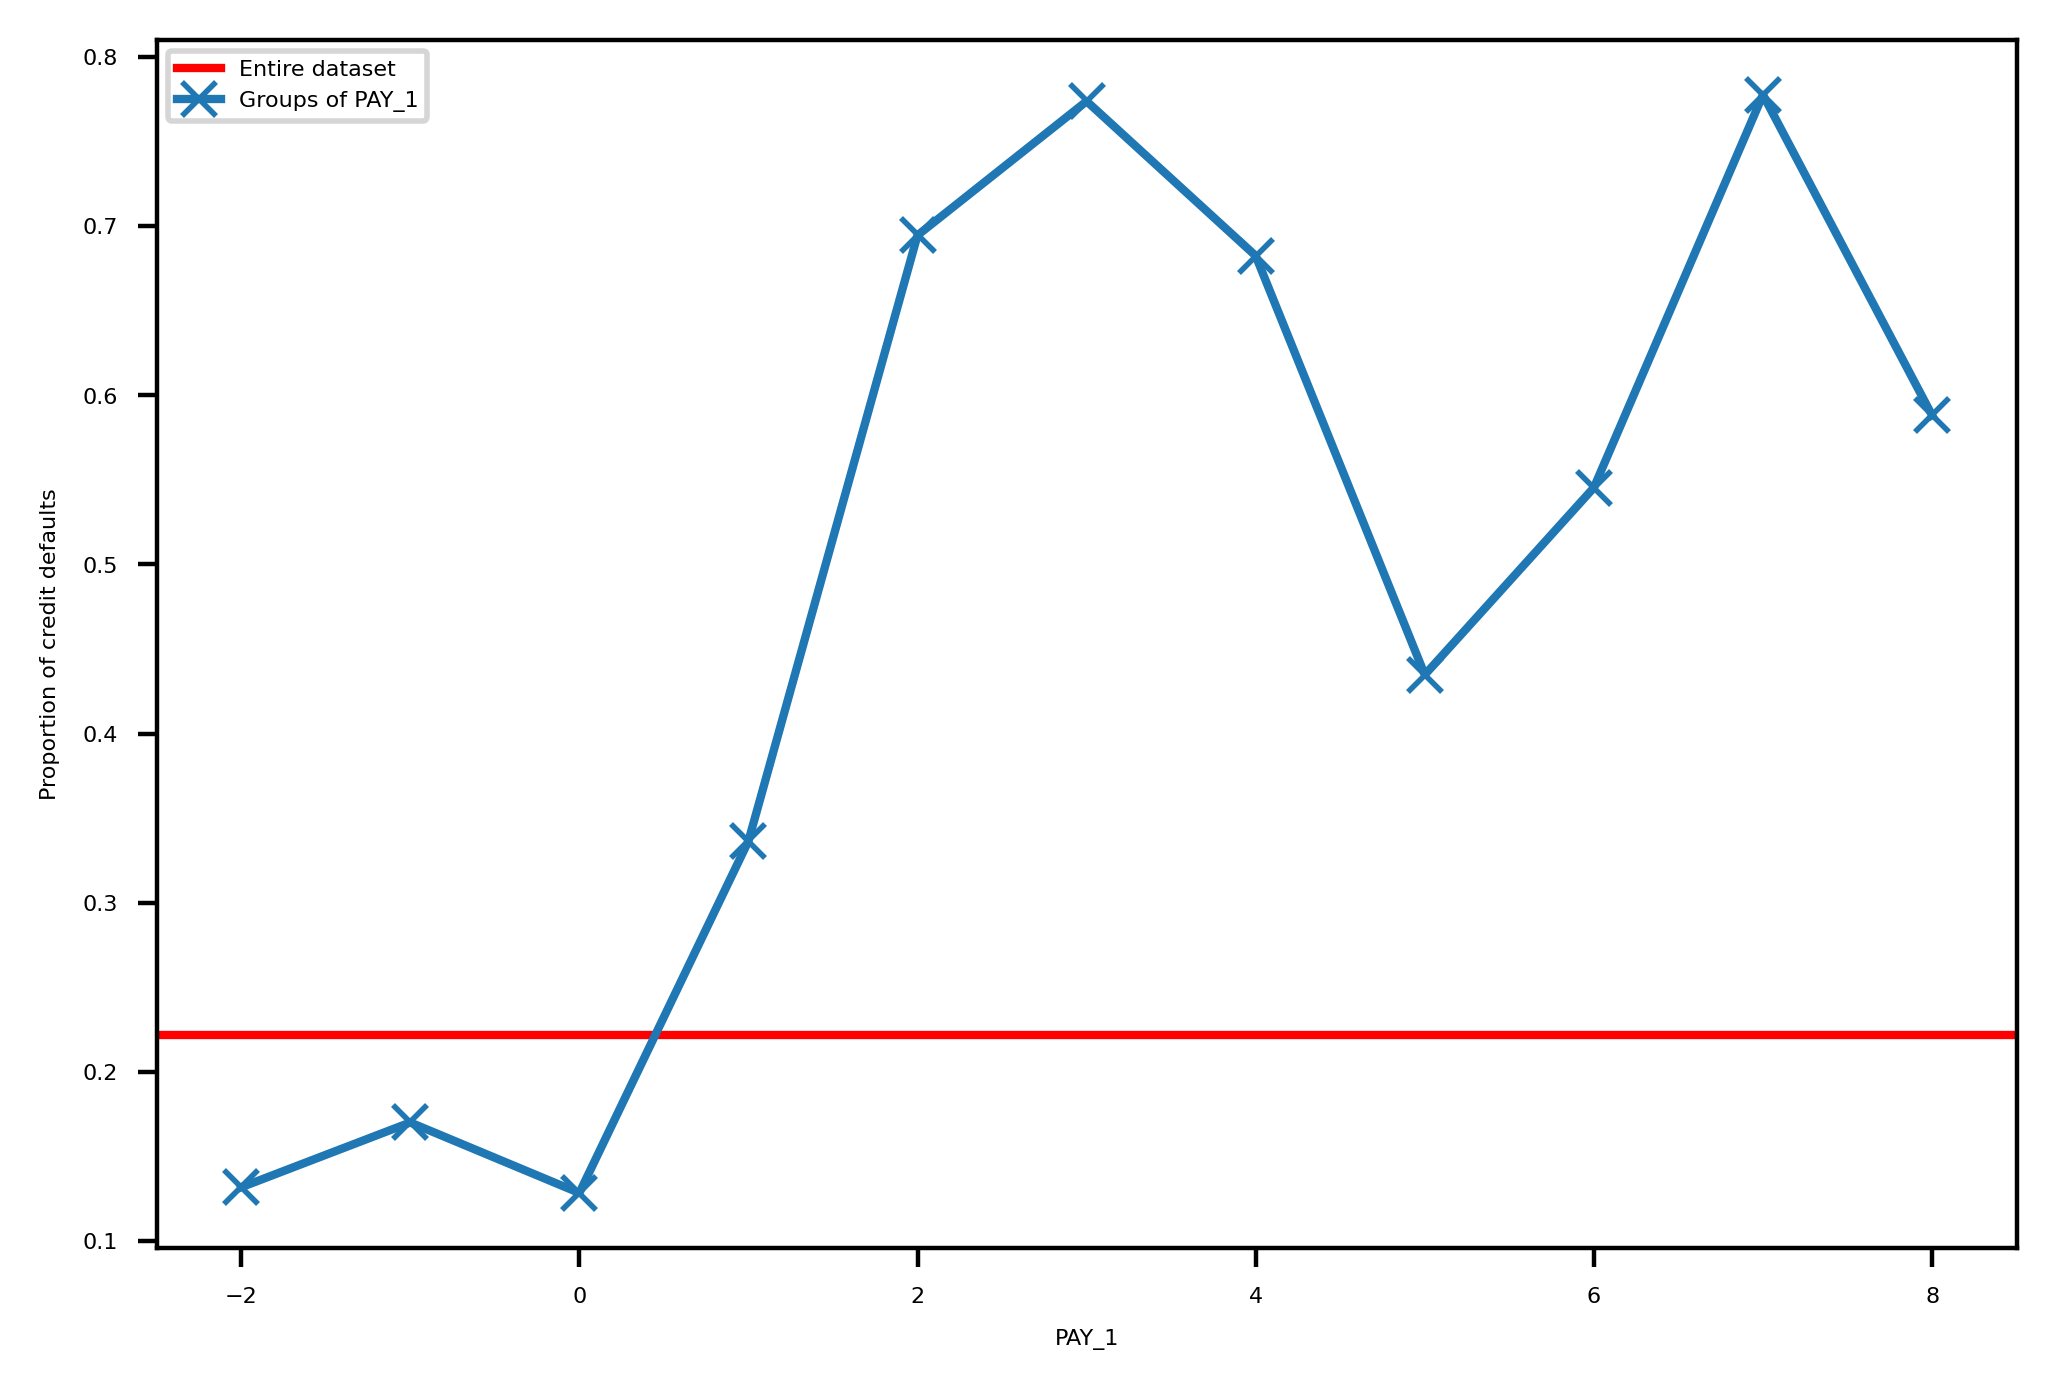

In [58]:
# Create an axes object
axes = plt.axes()
# Plot the overall default rate as a red horizontal line
axes.axhline(overall_default_rate, color="red")
# Plot grouped data
group_by_pay_mean_y.plot(marker="x", legend=False, ax=axes)
# Create a legend instance
axes.set_ylabel("Proportion of credit defaults")
axes.legend(["Entire dataset", "Groups of PAY_1"])

Those who defaulted before, are in fact more likely to default again. The default rate of accounts in good standing is below the overall default rate, which is about 22%. At least 30% of the accounts that were in default last month will be in default again next month.

In [59]:
# Create logical masks for positive and negative samples
pos_mask = y==1
neg_mask = y==0

In [60]:
# Create a histogram bin edges
bin_edges = list(range(0,850000,50000))
print(bin_edges[-1])

800000


<ipython-input-61-444a3cadad9e>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.round(y_ticks*50000,2))


Text(0.5, 1.0, 'Normalized distribution of credit limits by response variable')

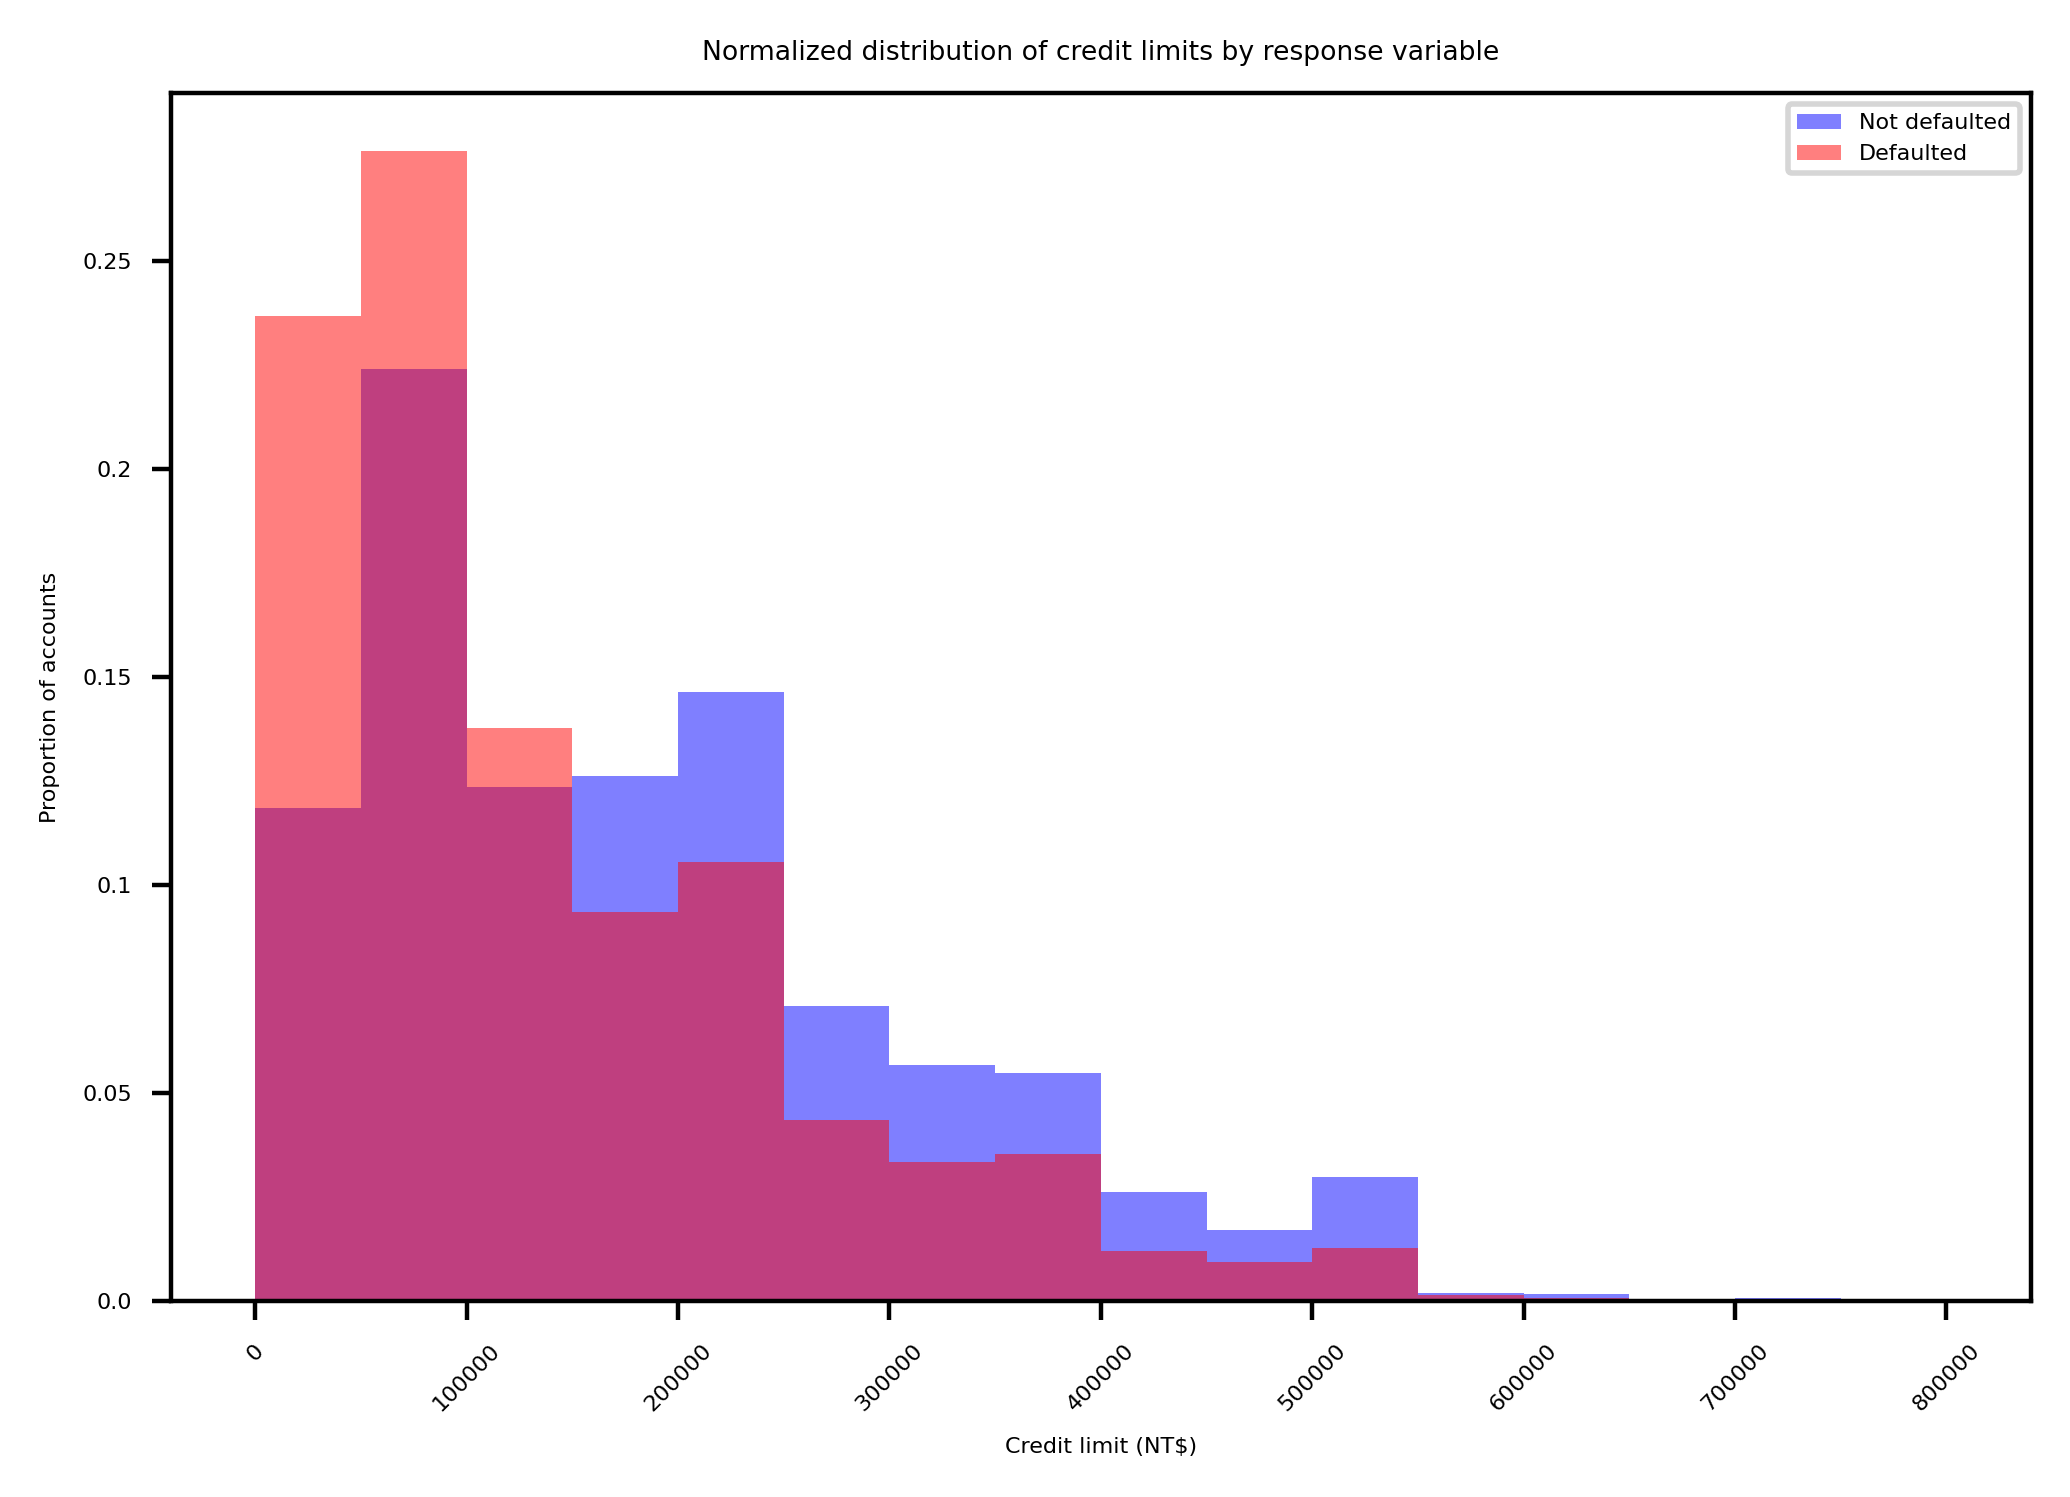

In [61]:
# Produce normalized histograms
mpl.rcParams["figure.dpi"] = 400
axes = plt.axes()
axes.hist(df.loc[neg_mask, "LIMIT_BAL"], bins=bin_edges, alpha=0.5, density=True, color="blue")
axes.hist(df.loc[pos_mask, "LIMIT_BAL"], bins=bin_edges, alpha=0.5, density=True, color="red")
axes.tick_params(axis="x", labelrotation=45)
axes.set_xlabel("Credit limit (NT$)")
axes.set_ylabel("Proportion of accounts")
y_ticks = axes.get_yticks()
axes.set_yticklabels(np.round(y_ticks*50000,2))
axes.legend(["Not defaulted", "Defaulted"])
axes.set_title("Normalized distribution of credit limits by response variable")

It looks like the accounts that default tend to have a higher proportion of lower credit limits. Accounts with credit limits less than NT$150000 are relatively more likely to default, while the opposite is true for accounts with limits higher than this. Our hypothesis was that the client would give riskier accounts lower limits. This intuition is compatible with the higher proportions of defaulters with lower credit limits that we observe here.

Logistic regression with L1 regularization ROC AUC on training set 0.718

In [62]:
# Select the features
features = features_response[:-1]
features

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [63]:
# Make a train/test split
from sklearn.model_selection import train_test_split
X = df[features].values
y = df["default payment next month"].values
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.2, random_state=24)
print(X_train.shape)
print(X_test.shape)

(21331, 17)
(5333, 17)


In [64]:
# Instantiate the MinMaxScaler to scale the data
from sklearn.preprocessing import MinMaxScaler
min_max_sc = MinMaxScaler()

In [65]:
# Instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='saga', penalty='l1', max_iter=1000)
lr

LogisticRegression(max_iter=1000, penalty='l1', solver='saga')

In [66]:
# Import the Pipeline class and create a Pipeline with the scaler and the logistic regression model
from sklearn.pipeline import Pipeline
scale_lr_pipeline = Pipeline(steps=[('scaler', min_max_sc), ('model', lr)])
scale_lr_pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('model', LogisticRegression(max_iter=1000, penalty='l1', solver='saga'))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'model': LogisticRegression(max_iter=1000, penalty='l1', solver='saga'),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 1000,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l1',
 'model__random_state': None,
 'model__solver': 'saga',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [67]:
# Create a range of C values to test with crossvalidation
C_val_exponents = np.linspace(2,-3,6)
C_vals = np.float(10)**C_val_exponents
C_vals

array([1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03])

In [68]:
# Use the cross-validation procedure in order to find a good value for the hyperparameter C
from sklearn.model_selection import StratifiedKFold
n_folds = 4
k_folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def cross_val_C_search_pipe(k_folds, C_vals, pipeline, X, Y):

    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)

    for c_val_counter in range(len(C_vals)):
        # Set the C value for the model object
        pipeline.set_params(model__C = C_vals[c_val_counter])
        # Count folds for each value of C
        fold_counter = 0
        # Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            # Subset the features and response for training and testing data for this fold:
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]
            
            # Fit the model on the training data
            pipeline.fit(X_cv_train, y_cv_train)

            # Get the training ROC AUC
            y_cv_train_predict_proba = pipeline.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])

            # Get the testing ROC AUC
            y_cv_test_predict_proba = pipeline.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])

            # Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)

            # Increment the fold counter
            fold_counter += 1
        
        # Indicate progress
        print("Done with C = {}".format(pipeline.get_params()['model__C']))
    
    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc



In [69]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline, X_train, y_train)

Done with C = 100.0
Done with C = 10.0
Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


Text(0.5, 1.0, 'Cross validation on Case Study problem')

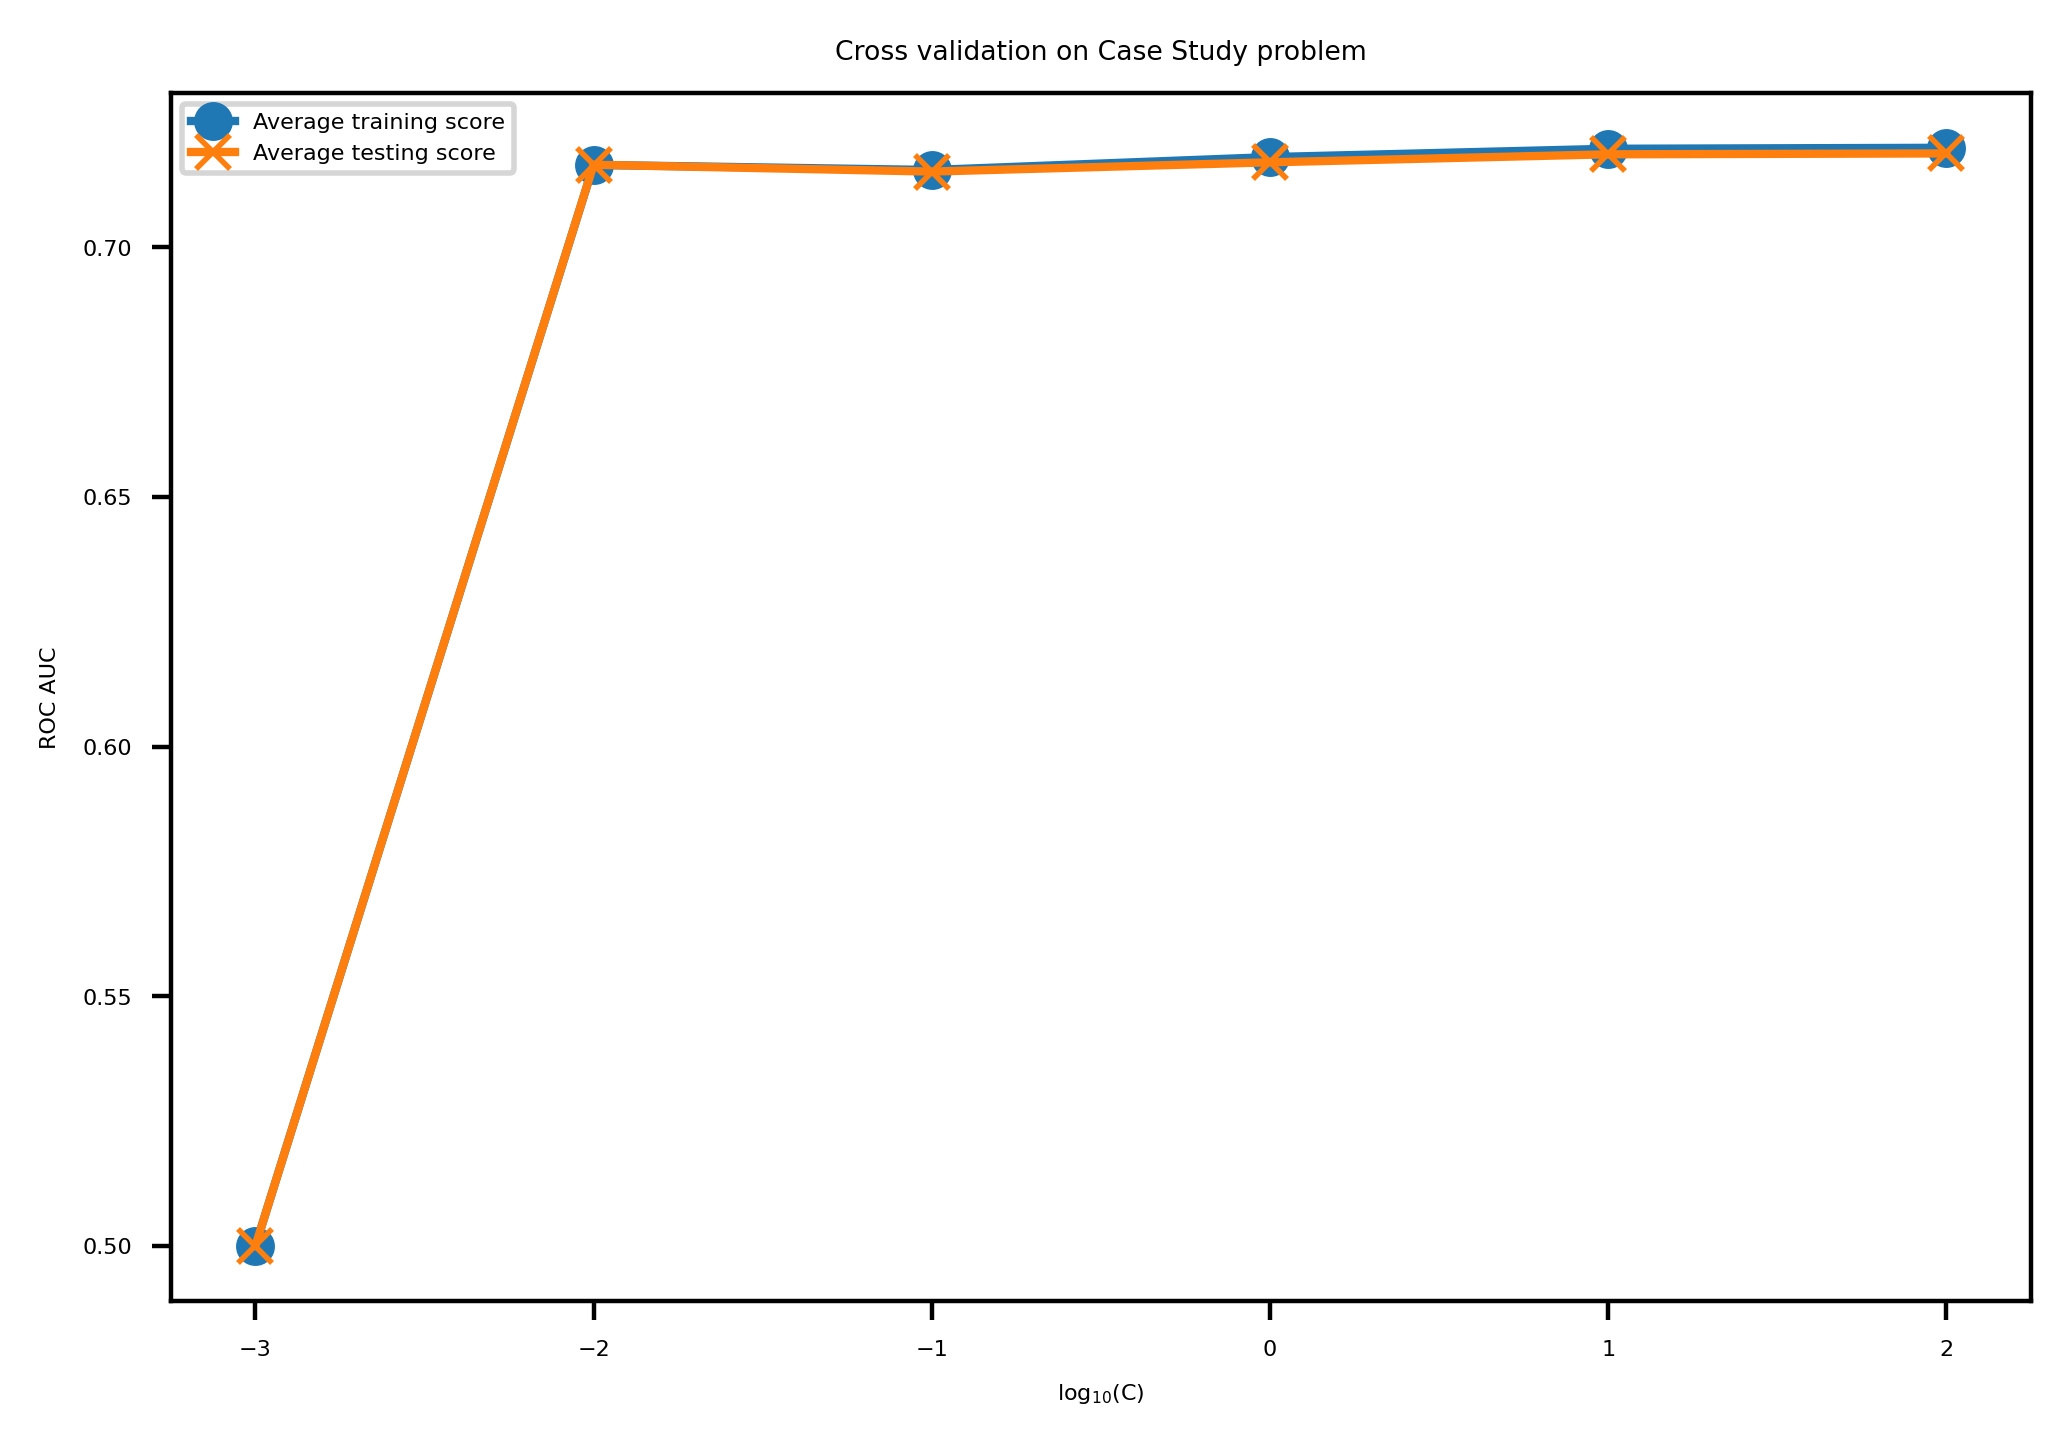

In [70]:
# Plot the average training and testing ROC AUC across folds, for each C value
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation on Case Study problem')

In [71]:
np.mean(cv_test_roc_auc, axis=0)

array([0.71874799, 0.71857034, 0.71696843, 0.71511249, 0.7164791 ,
       0.5       ])

Logistic regression with L1 regularization and engineered interaction features ROC AUC on training set 0.740

In [72]:
# Doesn't look like overfitting is happening. Our model may be underfitting. Let's try to engineer some new features to see if we can improve performance.
from sklearn.preprocessing import PolynomialFeatures
make_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interact = make_interactions.fit_transform(X)
X_interact.shape

X_train, X_test, y_train, y_test = train_test_split(X_interact, y, test_size=0.2, random_state=24)
print(X_train.shape)
print(X_test.shape)

(21331, 153)
(5333, 153)


In [73]:
# Repeat the cross-validation procedure
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline, X_train, y_train)

/Users/ulyanakastko/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/ulyanakastko/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/ulyanakastko/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/ulyanakastko/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Done with C = 100.0


/Users/ulyanakastko/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/ulyanakastko/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/ulyanakastko/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/ulyanakastko/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Done with C = 10.0


/Users/ulyanakastko/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/ulyanakastko/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/ulyanakastko/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


Text(0.5, 1.0, 'Cross validation on Case Study problem')

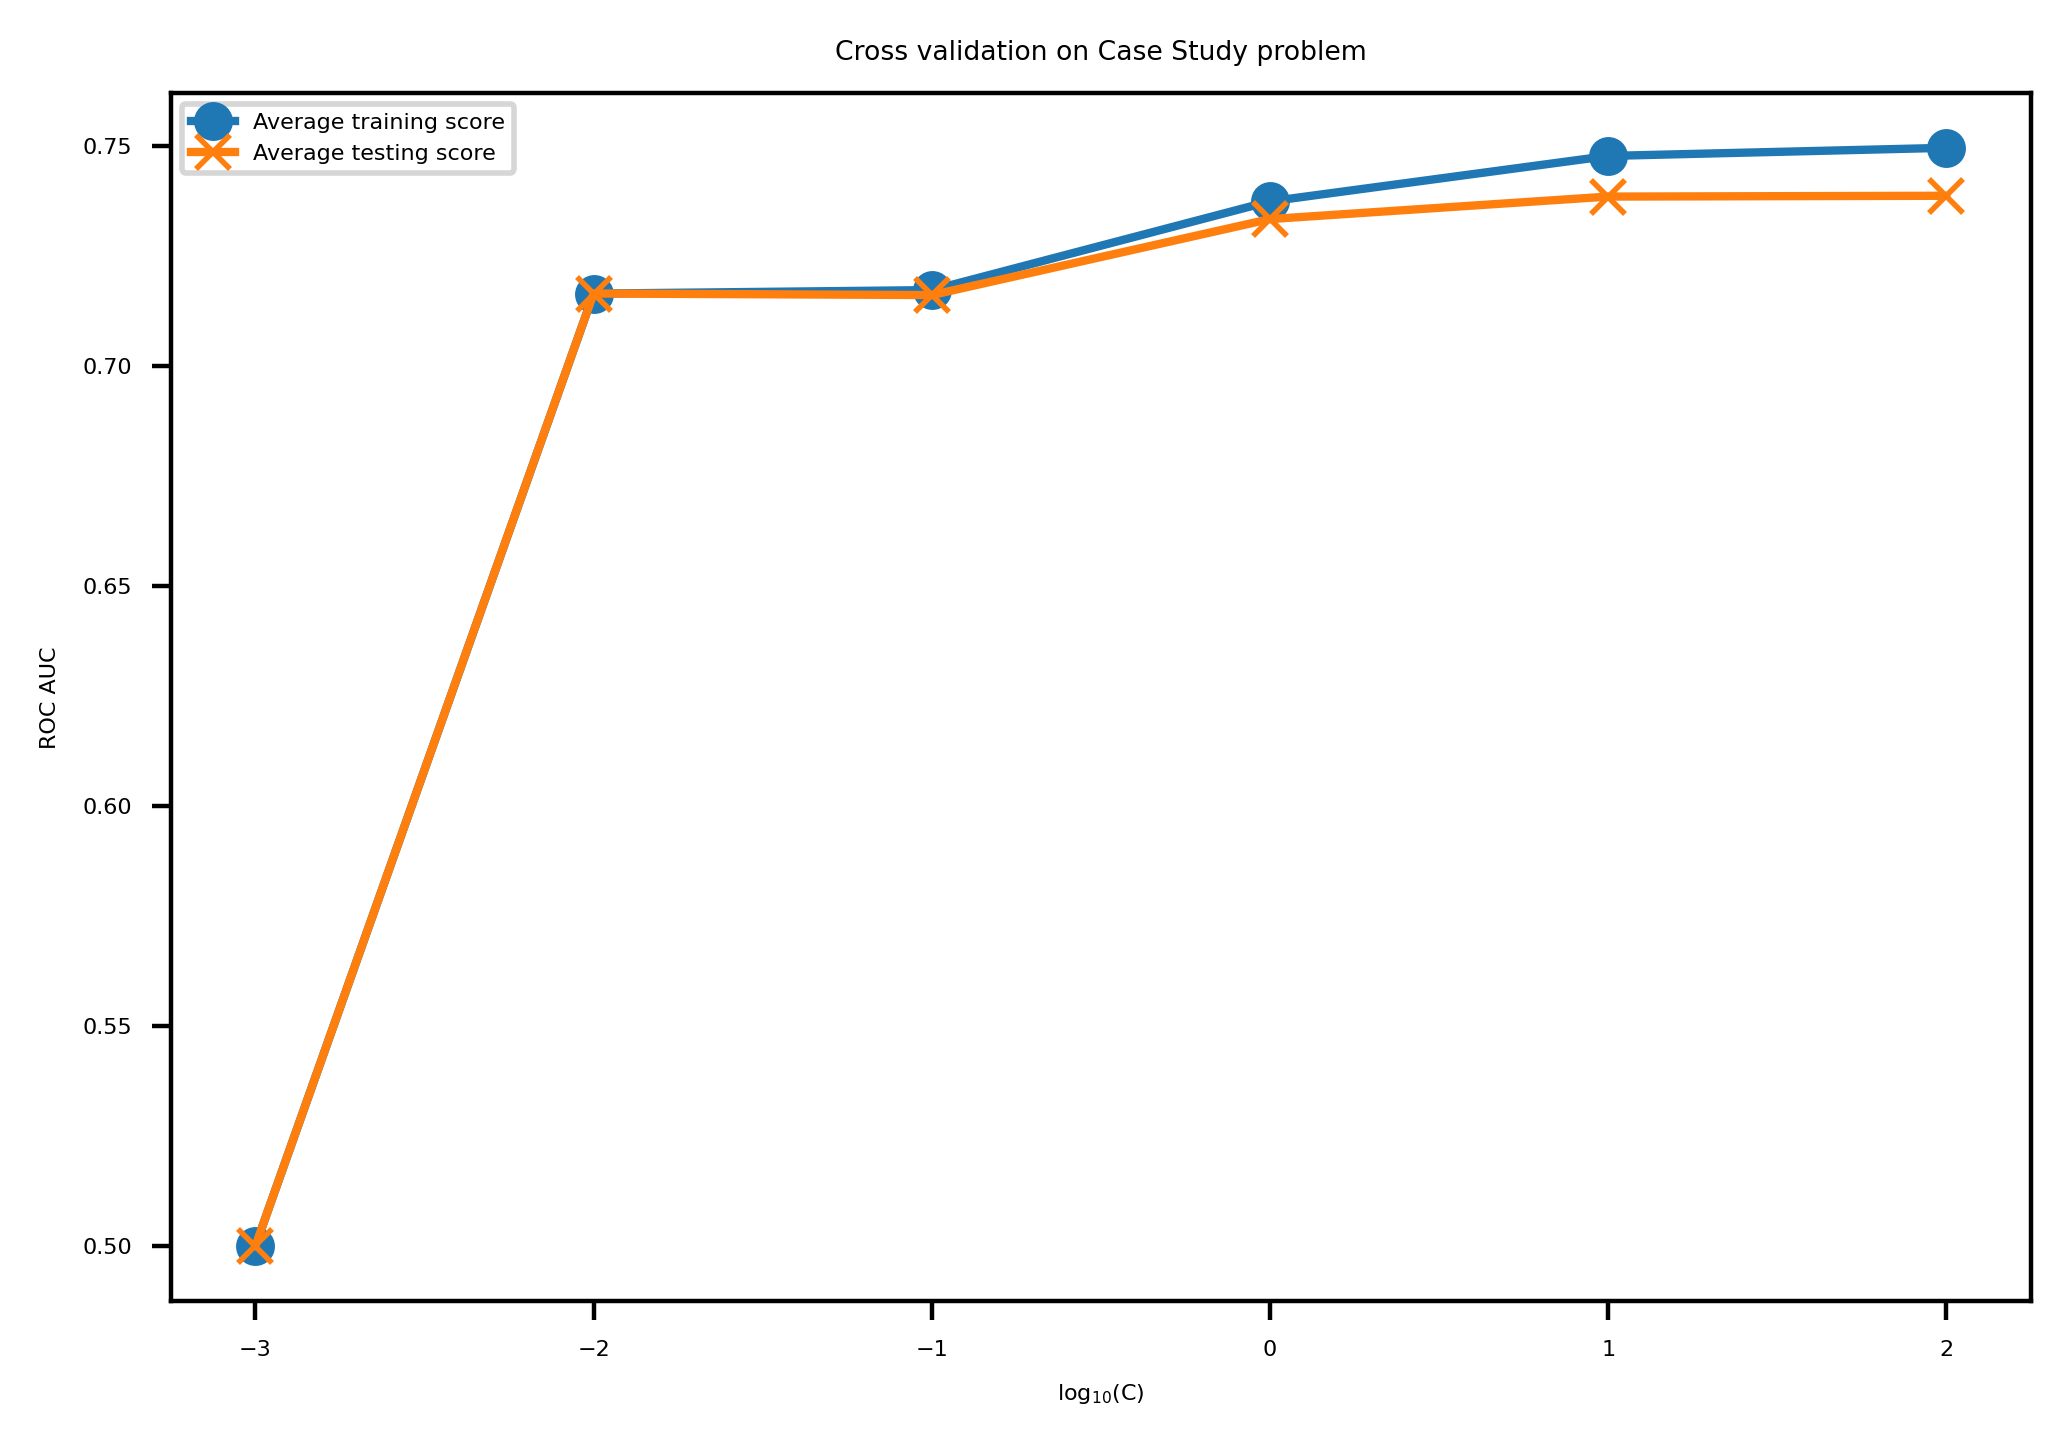

In [74]:
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation on Case Study problem')

In [75]:
np.mean(cv_test_roc_auc, axis=0)

array([0.73869089, 0.738508  , 0.73339567, 0.7161265 , 0.7164791 ,
       0.5       ])

Decision tree ROC AUC on training set 0.745

In [76]:
# Import the GridSearchCV class
from sklearn.model_selection import GridSearchCV
# Import graphviz to visualize decision trees
import graphviz
# Import the tree library
from sklearn import tree

In [77]:
# Make a train/test split
X = df[features].values
y = df["default payment next month"].values
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.2, random_state=24)
print(X_train.shape)

(21331, 17)


In [78]:
# Instantiate the decision tree class
dt = tree.DecisionTreeClassifier()
# Define a dictionary with the key being the hyperparameter name
params = {"max_depth": [1, 2, 4, 6, 8, 10, 12]}
# Instantiate the GridSearchCV class 
cv = GridSearchCV(dt, param_grid=params, scoring="roc_auc", n_jobs=None, refit=True, cv=4, verbose=1, pre_dispatch=None, error_score=np.nan, return_train_score=True)
# Perform a 4-fold cross-validation to search for the optimal maximum depth
cv.fit(X_train, y_train)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 4, 6, 8, 10, 12]},
             pre_dispatch=None, return_train_score=True, scoring='roc_auc',
             verbose=1)

In [79]:
# Create and examine a pandas DataFrame of cross-validation results
cv_results_df = pd.DataFrame(cv.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.013584,0.000184,0.001791,0.000132,1,{'max_depth': 1},0.639514,0.643398,0.651891,0.650753,0.646389,0.005136,7,0.648680,0.647384,0.644553,0.644934,0.646388,0.001712
1,0.024933,0.000302,0.001920,0.000123,2,{'max_depth': 2},0.695134,0.699022,0.713376,0.699510,0.701761,0.006917,5,0.704034,0.702700,0.698113,0.702535,0.701845,0.002232
2,0.047608,0.000406,0.001855,0.000043,4,{'max_depth': 4},0.732720,0.740116,0.746946,0.743731,0.740878,0.005294,2,0.756882,0.752256,0.749368,0.753055,0.752890,0.002682
3,0.069092,0.000172,0.001950,0.000108,6,{'max_depth': 6},0.744607,0.745998,0.751469,0.741491,0.745891,0.003611,1,0.782202,0.780125,0.775228,0.774776,0.778083,0.003171
4,0.089306,0.000546,0.002113,0.000144,8,{'max_depth': 8},0.726498,0.731578,0.749938,0.729892,0.734477,0.009112,3,0.811958,0.808245,0.803345,0.802004,0.806388,0.003967
5,0.108749,0.000615,0.002107,0.000111,10,{'max_depth': 10},0.709338,0.706161,0.717981,0.714219,0.711924,0.004524,4,0.848747,0.853784,0.841283,0.836056,0.844967,0.006801
6,0.125734,0.000721,0.002252,0.000064,12,{'max_depth': 12},0.673592,0.658620,0.673836,0.680070,0.671530,0.007893,6,0.889874,0.903506,0.885425,0.875508,0.888578,0.010066


In [80]:
# View the names of the remaining columns in the results DataFrame
cv_results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

Text(0, 0.5, 'ROC AUC')

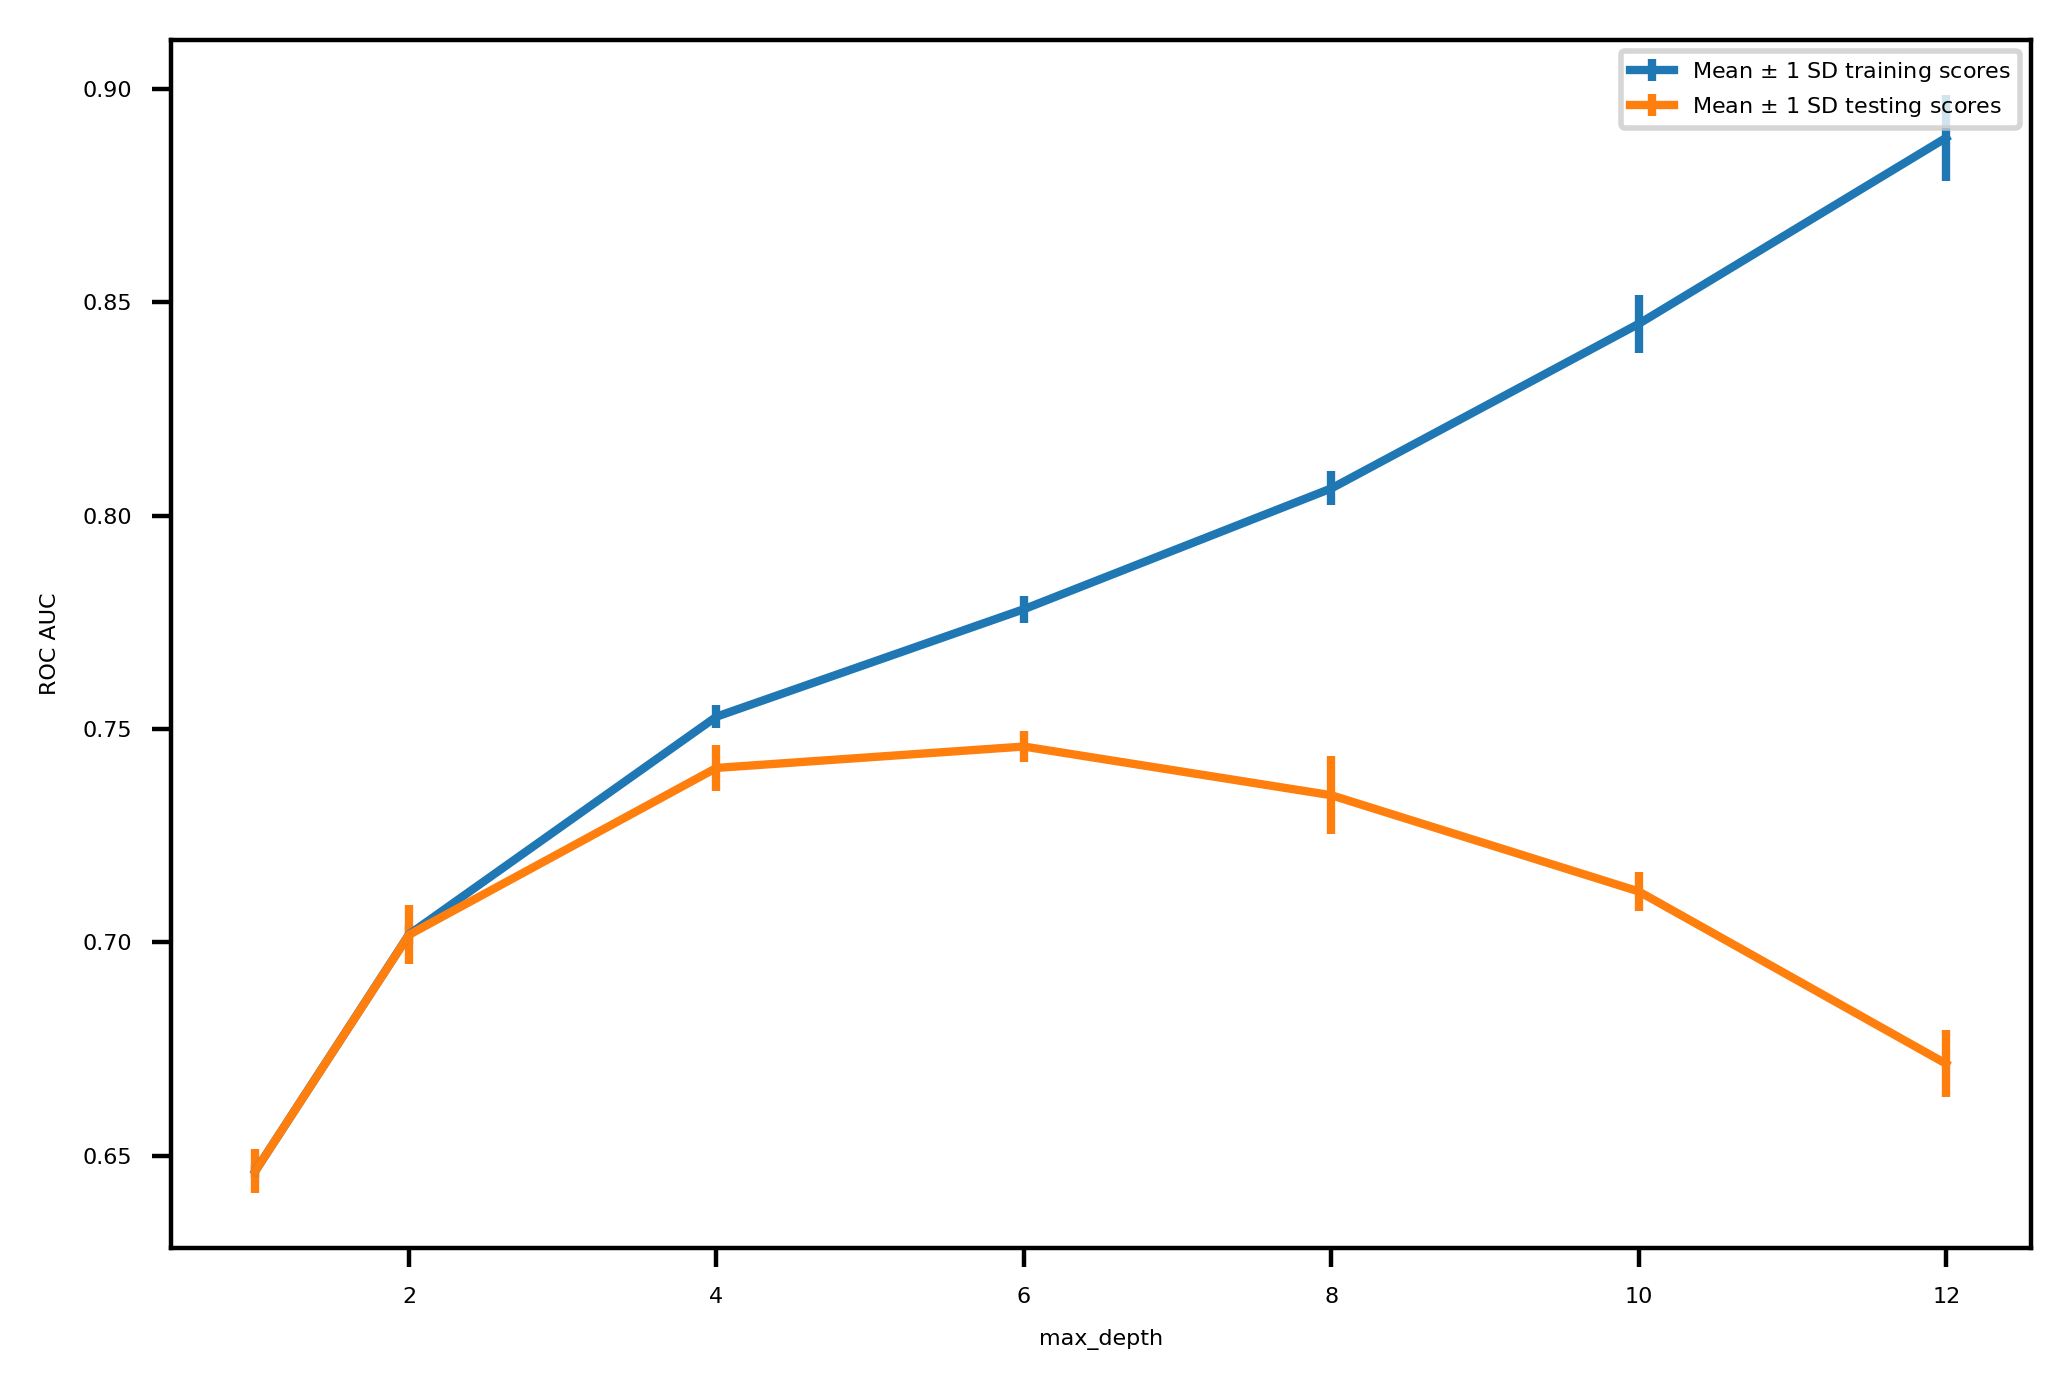

In [81]:
# Create an error bar plot of training and testing scores for each value of max_depth that was examined in cross-validation
ax = plt.axes()
ax.errorbar(cv_results_df["param_max_depth"], cv_results_df["mean_train_score"], yerr=cv_results_df["std_train_score"], label="Mean $\pm$ 1 SD training scores")
ax.errorbar(cv_results_df["param_max_depth"], cv_results_df["mean_test_score"], yerr=cv_results_df["std_test_score"], label="Mean $\pm$ 1 SD testing scores")
ax.legend()
plt.xlabel("max_depth")
plt.ylabel("ROC AUC")

In [82]:
cv_results_df.max()

mean_fit_time          0.125734
std_fit_time           0.000721
mean_score_time        0.002252
std_score_time         0.000144
param_max_depth       12.000000
split0_test_score      0.744607
split1_test_score      0.745998
split2_test_score      0.751469
split3_test_score      0.743731
mean_test_score        0.745891
std_test_score         0.009112
rank_test_score        7.000000
split0_train_score     0.889874
split1_train_score     0.903506
split2_train_score     0.885425
split3_train_score     0.875508
mean_train_score       0.888578
std_train_score        0.010066
dtype: float64

Random forest ROC AUC on training set 0.776

In [83]:
# Import the random forest classifier model class
from sklearn.ensemble import RandomForestClassifier
# Instantiate the class
rf = RandomForestClassifier(n_estimators=10, criterion="gini", max_depth=3, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="auto", max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=4, verbose=0, warm_start=False, class_weight=None)

In [84]:
# Create a parameter grid in order to search the numbers of trees ranging from 10 to 100
rf_params = {"max_depth":[3, 6, 9, 12], "n_estimators":[10, 50, 100, 200]}
# Instantiate a grid search cross-validation object for the random forest model
cv_rf = GridSearchCV(rf, param_grid=rf_params, scoring="roc_auc", refit=True, n_jobs=1, cv=4, verbose=2, error_score=np.nan, return_train_score=True)
# Fit cross-validation object
cv_rf.fit(X_train, y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.4s
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.7s
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.7s
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.7s
[CV] END ......................max_depth=3, n_es

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=4),
             n_jobs=1,
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 50, 100, 200]},
             return_train_score=True, scoring='roc_auc', verbose=2)

In [85]:
# Put the cross_validation results into a pandas DataFrame
cv_rf_results_df = pd.DataFrame(cv_rf.cv_results_)
cv_rf_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.076452,0.001039,0.005129,0.000624,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.739183,0.746599,0.772127,0.771322,0.757308,0.014656,15,0.767973,0.767158,0.760550,0.763683,0.764841,0.002955
1,0.365208,0.002274,0.014826,0.001768,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.748009,0.755878,0.779465,0.771250,0.763651,0.012379,12,0.775241,0.774025,0.765732,0.766947,0.770486,0.004191
2,0.720081,0.003031,0.024638,0.000211,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.747221,0.753924,0.779195,0.770937,0.762819,0.012811,13,0.774340,0.773598,0.766103,0.766914,0.770238,0.003750
3,1.447192,0.012779,0.051587,0.002676,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.747454,0.753057,0.777644,0.771729,0.762471,0.012550,14,0.774453,0.773534,0.766139,0.767404,0.770382,0.003653
4,0.125298,0.003116,0.005274,0.000076,6,10,"{'max_depth': 6, 'n_estimators': 10}",0.752905,0.758904,0.780036,0.774017,0.766466,0.010980,11,0.795911,0.796476,0.793695,0.796446,0.795632,0.001141
5,0.615714,0.002346,0.017526,0.001532,6,50,"{'max_depth': 6, 'n_estimators': 50}",0.760089,0.765251,0.788567,0.778669,0.773144,0.011193,8,0.807081,0.805109,0.799176,0.801229,0.803149,0.003113
6,1.232933,0.002860,0.035299,0.003182,6,100,"{'max_depth': 6, 'n_estimators': 100}",0.760964,0.765515,0.788793,0.778936,0.773552,0.011004,7,0.808194,0.806130,0.800846,0.803123,0.804573,0.002808
7,2.463821,0.005708,0.062916,0.004762,6,200,"{'max_depth': 6, 'n_estimators': 200}",0.761481,0.765319,0.787854,0.779745,0.773600,0.010682,6,0.808276,0.806853,0.800682,0.804006,0.804954,0.002906
8,0.172987,0.000753,0.006412,0.000434,9,10,"{'max_depth': 9, 'n_estimators': 10}",0.757853,0.755444,0.781544,0.773823,0.767166,0.010899,10,0.854161,0.856197,0.850317,0.852039,0.853178,0.002211
9,0.850555,0.001532,0.020870,0.001437,9,50,"{'max_depth': 9, 'n_estimators': 50}",0.763956,0.764420,0.786690,0.780255,0.773830,0.009908,4,0.867242,0.871380,0.868213,0.867390,0.868557,0.001672


In [86]:
# View the names of the remaining columns in the results DataFrame
cv_rf_results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [87]:
cv_rf_results_df.max()

mean_fit_time           4.207555
std_fit_time            0.013586
mean_score_time         0.089626
std_score_time          0.005264
param_max_depth        12.000000
param_n_estimators    200.000000
split0_test_score       0.765910
split1_test_score       0.767541
split2_test_score       0.790255
split3_test_score       0.783513
mean_test_score         0.776199
std_test_score          0.014656
rank_test_score        16.000000
split0_train_score      0.945018
split1_train_score      0.949378
split2_train_score      0.946415
split3_train_score      0.944689
mean_train_score        0.946375
std_train_score         0.004263
dtype: float64

In [89]:
xx_rf, yy_rf = np.meshgrid(range(5), range(5))

In [90]:
cm_rf = plt.cm.jet

Text(0, 0.5, 'Maximum depth')

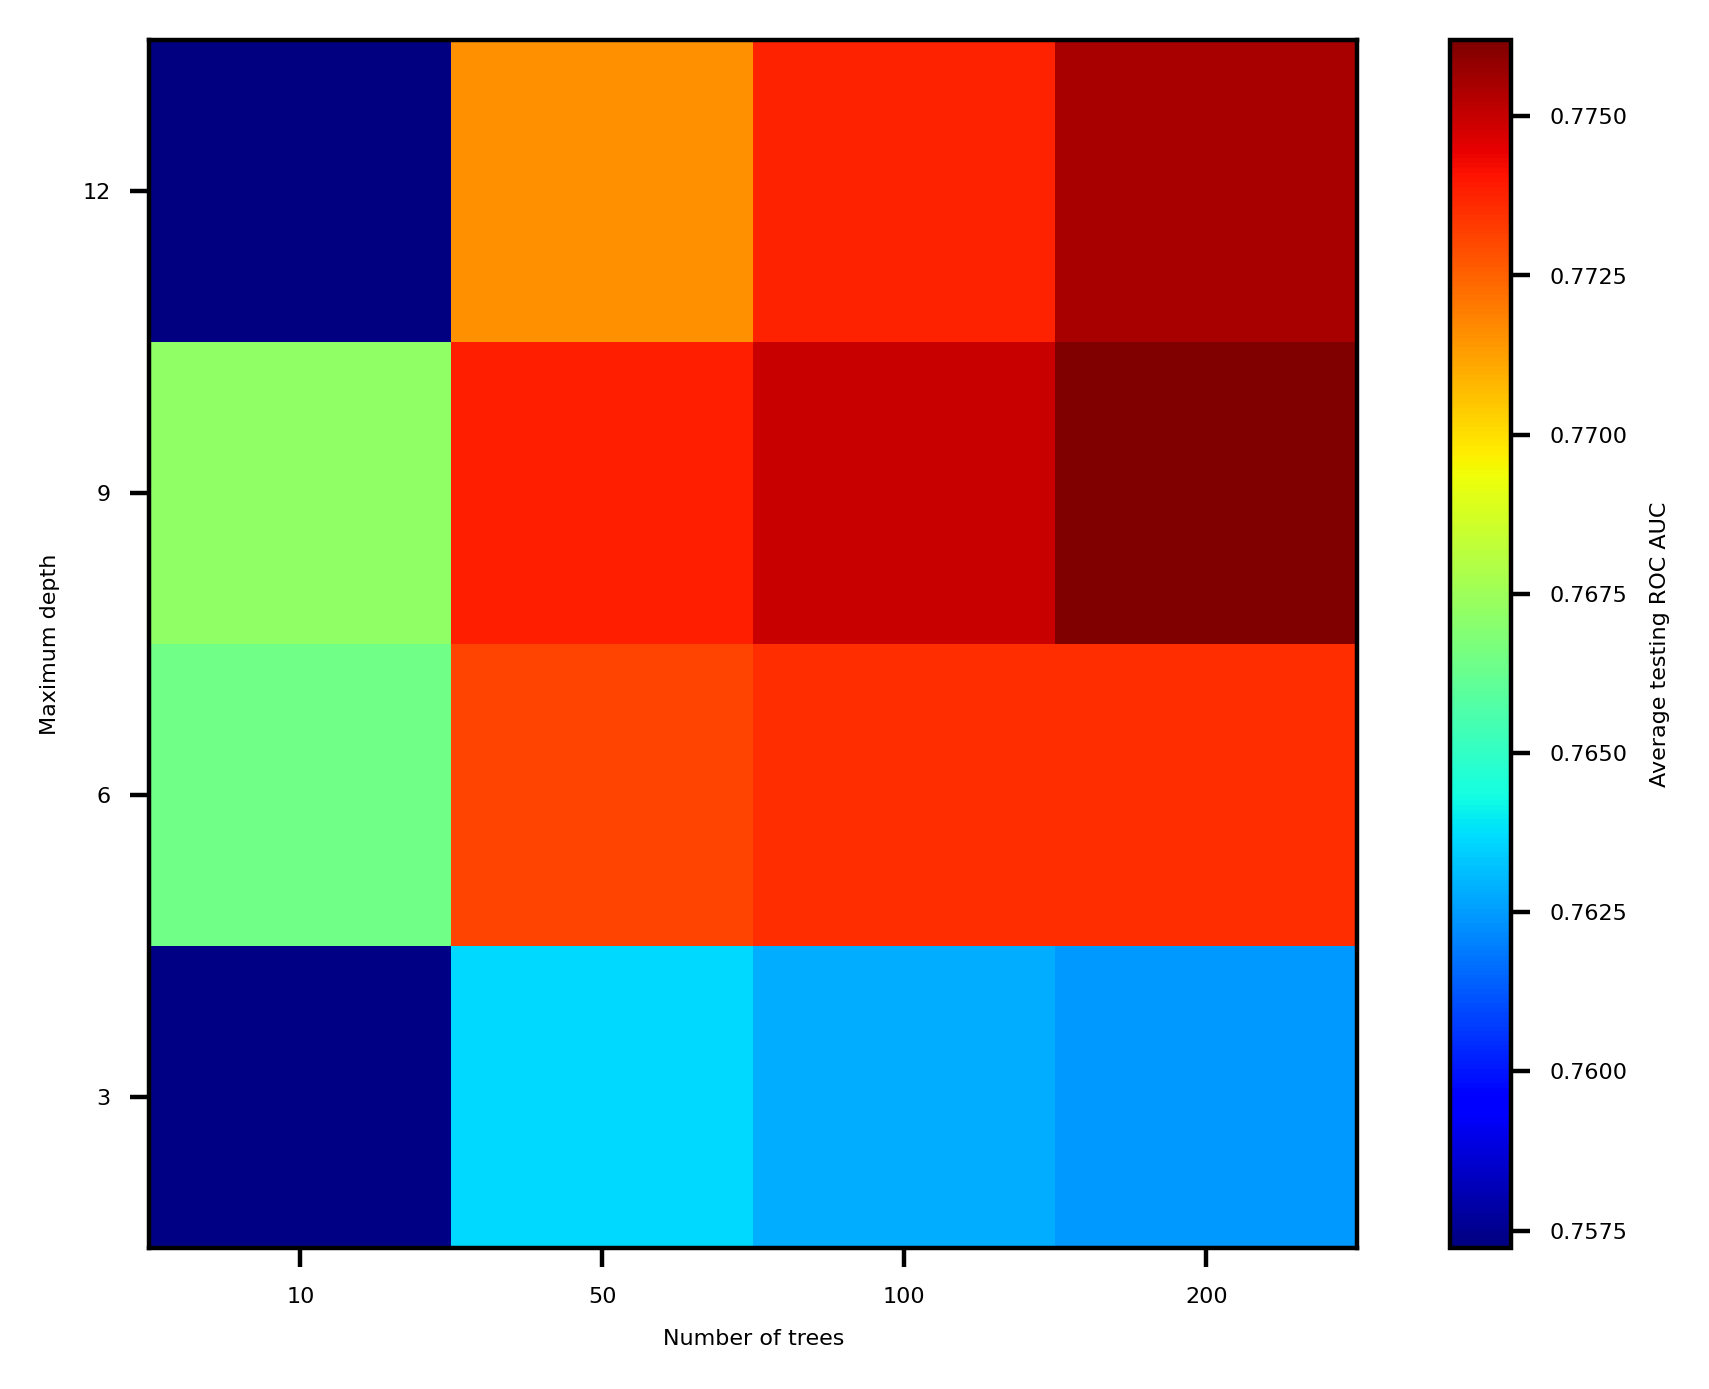

In [91]:
ax_rf = plt.axes()
pcolor_graph = ax_rf.pcolormesh(xx_rf, yy_rf, cv_rf_results_df['mean_test_score'].values.reshape((4,4)), cmap=cm_rf)
plt.colorbar(pcolor_graph, label='Average testing ROC AUC')
ax_rf.set_aspect('equal')
ax_rf.set_xticks([0.5, 1.5, 2.5, 3.5])
ax_rf.set_yticks([0.5, 1.5, 2.5, 3.5])
ax_rf.set_xticklabels([str(tick_label) for tick_label in rf_params['n_estimators']])
ax_rf.set_yticklabels([str(tick_label) for tick_label in rf_params['max_depth']])
ax_rf.set_xlabel('Number of trees')
ax_rf.set_ylabel('Maximum depth')

In [92]:
cv_rf.best_params_

{'max_depth': 9, 'n_estimators': 200}

In [94]:
feat_imp_df_act = pd.DataFrame({
    'Feature name':features_response[:-1],
    'Importance':cv_rf.best_estimator_.feature_importances_
})

feat_imp_df_act.sort_values('Importance', ascending=False)

,Feature name,Importance
4,PAY_1,0.437439
0,LIMIT_BAL,0.059961
11,PAY_AMT1,0.059434
12,PAY_AMT2,0.045518
13,PAY_AMT3,0.043299
5,BILL_AMT1,0.042195
6,BILL_AMT2,0.041562
7,BILL_AMT3,0.037268
14,PAY_AMT4,0.034321
8,BILL_AMT4,0.034123


Dealing with missing data: building a multiclass classification model for imputation

In [96]:
# Load the original dataset
df_orig = pd.read_excel("Data/default_of_credit_card_clients__courseware_version_1_21_19.xls")

# Repeat all the data cleaning steps we took
df_zero_mask = df_orig == 0
feature_zero_mask = df_zero_mask.iloc[:,1:].all(axis=1)
df_clean = df_orig.loc[~feature_zero_mask,:].copy()
df_clean.shape

(29685, 25)

In [97]:
# Check the number of unique account IDs
df_clean["ID"].nunique()

29685

In [98]:
# Replace the undocumented value of EDUCATION and MARRIAGE
df_clean["EDUCATION"].replace(to_replace=[0,5,6], value=4, inplace=True)
df_clean["MARRIAGE"].replace(to_replace=0, value=3, inplace=True)

In [122]:
# Subset the samples from our cleaned dataset df_clean that have missing values for PAY_1
df_clean["PAY_1"].value_counts()

# Create a Boolean mask to identify the rows with missing values
missing_pay_1_mask = df_clean["PAY_1"] == "Not available"

# Make a copy of these rows in a new DataFrame
df_missing_pay_1 = df_clean.loc[missing_pay_1_mask,:].copy()

In [107]:
# Load the cleaned data 
df = pd.read_csv('Data/cleaned_data.csv')

features_for_imputation = df.columns.tolist()

# Make a list of column names we want to exclude
items_to_remove = ["ID", "SEX", "PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]

# Reassing the features_response variable with a list containing everything that's not in the list of strings we wish to remove
features_for_imputation = [item for item in features_response if item not in items_to_remove]
features_for_imputation

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [111]:
# Make a training and testing split of the imputation model data
X_impute_train, X_impute_test, y_impute_train, y_impute_test = train_test_split(df[features_for_imputation].values, df["PAY_1"].values, test_size=0.2, random_state=24)

# Select a grid of hyperparameters to search
rf_impute_params = {"max_depth":[3, 6, 9, 12], "n_estimators":[10, 50, 100, 200]}

# Instantiate the GridSearchCV
cv_rf_impute = GridSearchCV(rf, param_grid=rf_impute_params, scoring="accuracy", n_jobs=-1, refit=True, cv=4, verbose=2, error_score=np.nan, return_train_score=True)

# Run the grid search
cv_rf_impute.fit(X_impute_train, y_impute_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=4),
             n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 50, 100, 200]},
             return_train_score=True, scoring='accuracy', verbose=2)

In [112]:
# Observe the hyperparameters from the best model of cross-validation
cv_rf_impute.best_params_

{'max_depth': 12, 'n_estimators': 200}

In [113]:
# See what the accuracy score of the best model is
cv_rf_impute.best_score_

0.7402373282238617

In [114]:
# To check that the cross-validation accuracy generalizes to the test set, we need to make predictions on the test set
y_impute_predict = cv_rf_impute.predict(X_impute_test)

# Impute the accuracy_score class and see the accuracy of testing predictions
from sklearn import metrics
metrics.accuracy_score(y_impute_test, y_impute_predict)

0.7419838739921245

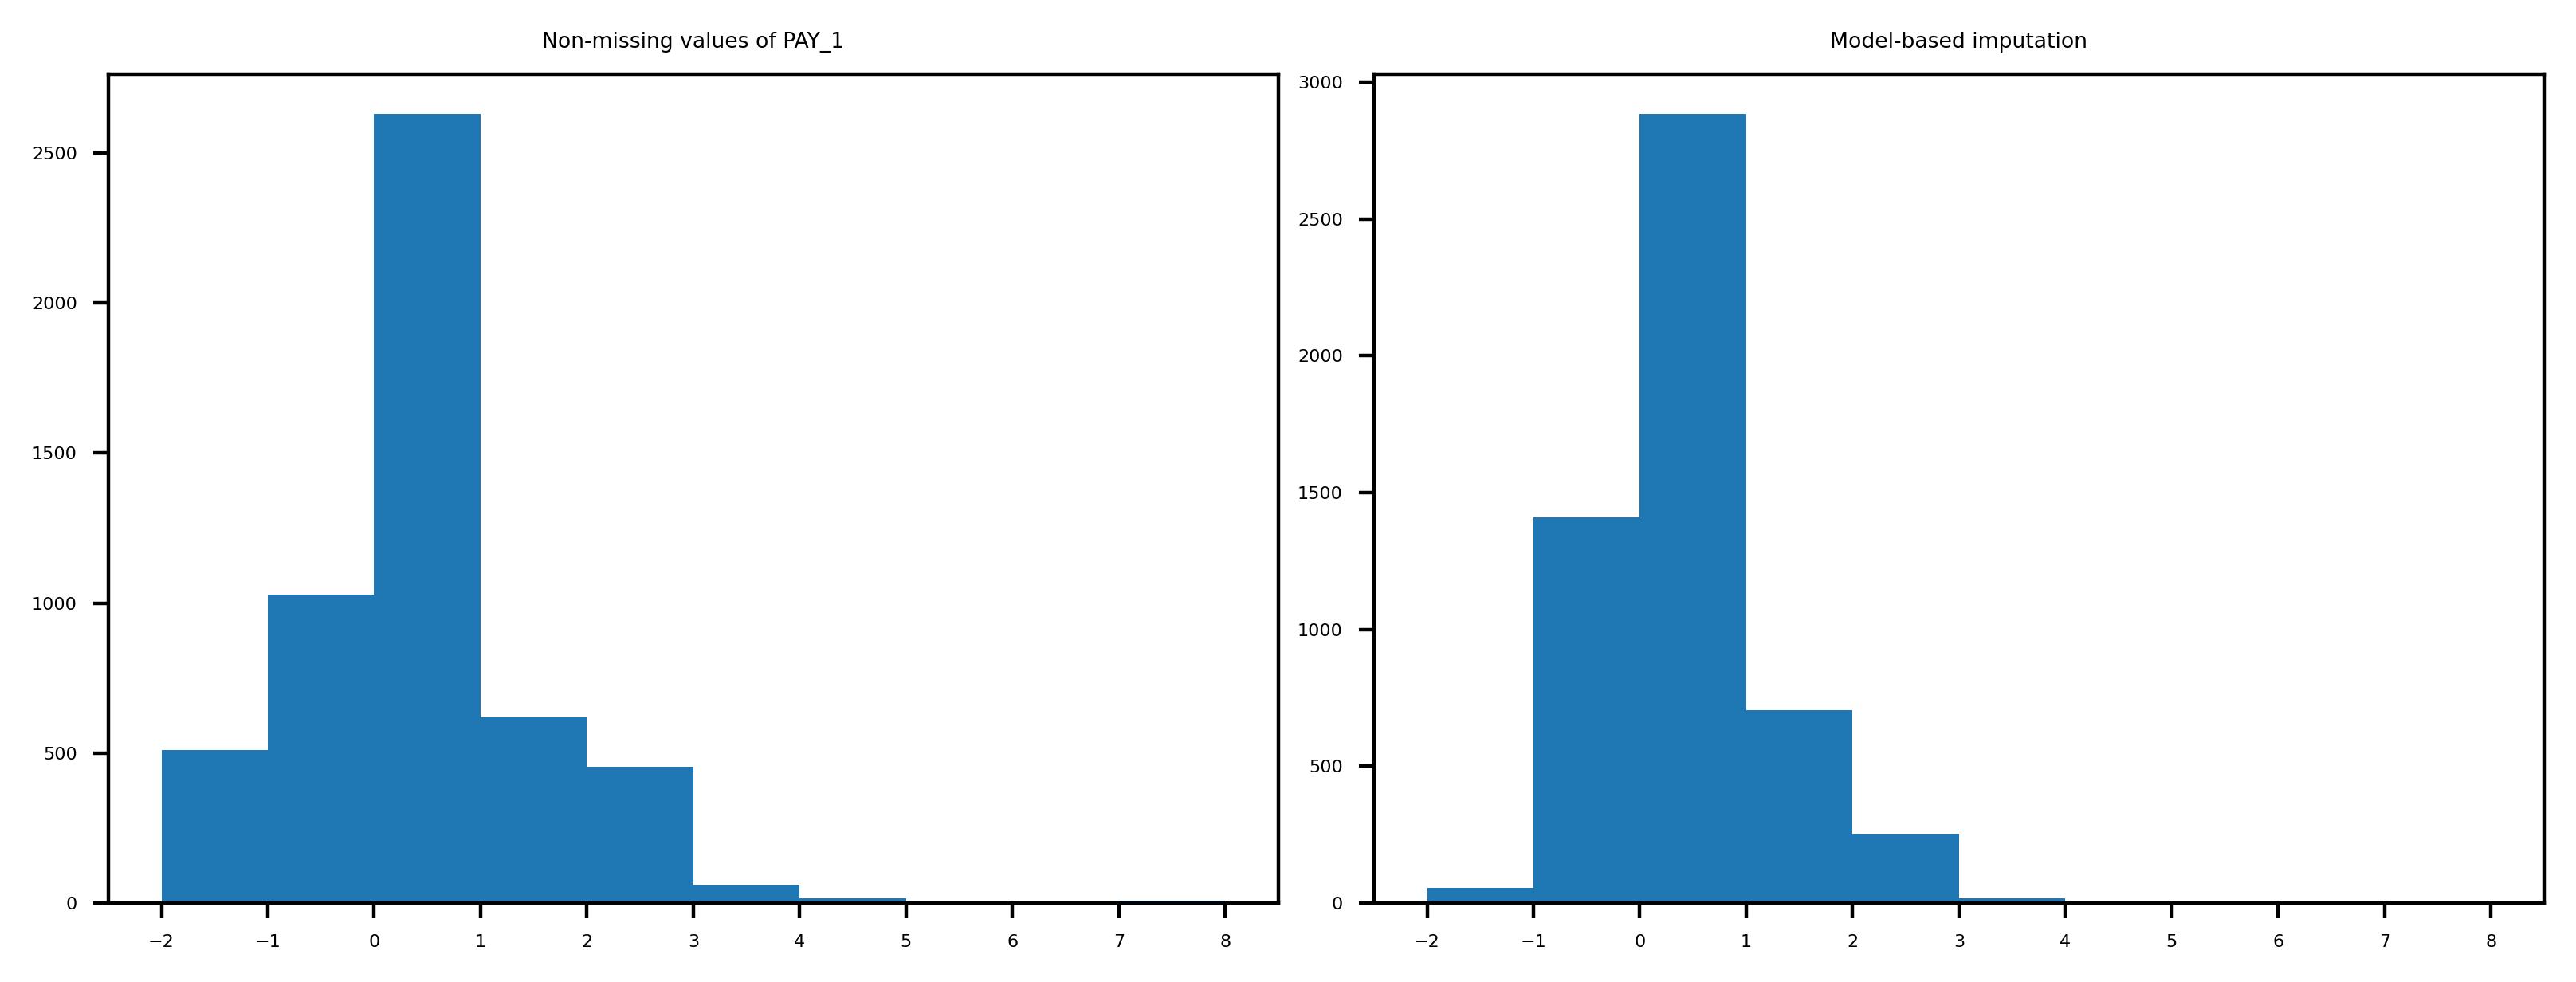

In [118]:
# Visualize model predictions
fig, axs = plt.subplots(1, 2, figsize=(8,3))
bin_edges = np.arange(-2,9)
axs[0].hist(y_impute_test, bins=bin_edges)
axs[0].set_xticks(bin_edges)
axs[0].set_title("Non-missing values of PAY_1")

axs[1].hist(y_impute_predict, bins=bin_edges)
axs[1].set_xticks(bin_edges)
axs[1].set_title("Model-based imputation")
plt.tight_layout()

In [119]:
# Collect all the values with known PAY_1 to train the final version of the imputation model
X_impute_all = df[features_for_imputation].values
y_impute_all = df["PAY_1"].values

In [120]:
# Define a random forest model with the optimal hyperparameters for imputation
rf_impute = RandomForestClassifier(n_estimators=200, max_depth=12)

# Fit the imputation model on all available data
rf_impute.fit(X_impute_all, y_impute_all)

RandomForestClassifier(max_depth=12, n_estimators=200)

In [123]:
# Make a copy of the DataFrame with missing PAY_1
df_fill_pay_1_model = df_missing_pay_1.copy()

# Examine the values of PAY_1
df_fill_pay_1_model["PAY_1"].head()

17    Not available
28    Not available
29    Not available
54    Not available
60    Not available
Name: PAY_1, dtype: object

In [125]:
# Replace these missing values with imputation model predictions
df_fill_pay_1_model["PAY_1"] = rf_impute.predict(df_fill_pay_1_model[features_for_imputation].values)

# Examine the values of PAY_1
df_fill_pay_1_model["PAY_1"].head()

17    0
28   -1
29    0
54    0
60    0
Name: PAY_1, dtype: int64

In [126]:
# Make a quick examination of the predictions
df_fill_pay_1_model["PAY_1"].value_counts().sort_index()

-2      31
-1     764
 0    1659
 1     417
 2     139
 3       7
 4       1
 5       1
 6       1
 8       1
Name: PAY_1, dtype: int64

In [128]:
# Split the imputed data
X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = train_test_split(df_fill_pay_1_model[features_response[:-1]].values, df_fill_pay_1_model["default payment next month"].values, test_size=0.2, random_state=24)

# Combine with non-missing data
X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
X_test_all = np.concatenate((X_test, X_fill_pay_1_test), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
y_test_all = np.concatenate((y_test, y_fill_pay_1_test), axis=0)

In [130]:
rf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=9,
min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,
random_state=4, verbose=1, warm_start=False, class_weight=None)
# Fit the random forest model
rf.fit(X_train_all, y_train_all)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    5.0s finished


RandomForestClassifier(max_depth=9, n_estimators=200, random_state=4, verbose=1)

In [131]:
# Calculate ROC AUC
y_test_all_predict_proba = rf.predict_proba(X_test_all)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_all, y_test_all_predict_proba[:,1])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


0.7730583423438793

Financial analysis.
For credit accounts that are at a high risk of default, the client is designing a new program to provide individualized counseling for the account holder, to encourage them to pay their bill on time or provide alternative payment options if that will not be possible. The cost per attempted counseling session is NT$7500 and expected success rate of a session is 70%. The potential benefits of successful counseling are that the amount of an account's monthly bill will be realized as savings, if it was going to default but instead didn't, as a result of counseling. Currently, the monthly bills for accounts that default are reported as losses.

If we can help them narrow down the list of people who will be contacted for counseling, we can help save them money by avoiding unnecessary and expensive contacts. The client lets us know that our analysis can help them request a budget for the counseling program, if we can give them an idea of how many counseling sessions it would be wirthwhile to offer.

In [132]:
# Create a range of thresholds to calculate expected costs and benefits of counseling
thresholds = np.linspace(0, 1, 101)

# Capture the average bill amount as the potential savings per default 
savings_per_default = np.mean(X_test_all[:,5])
savings_per_default

51601.7433479286

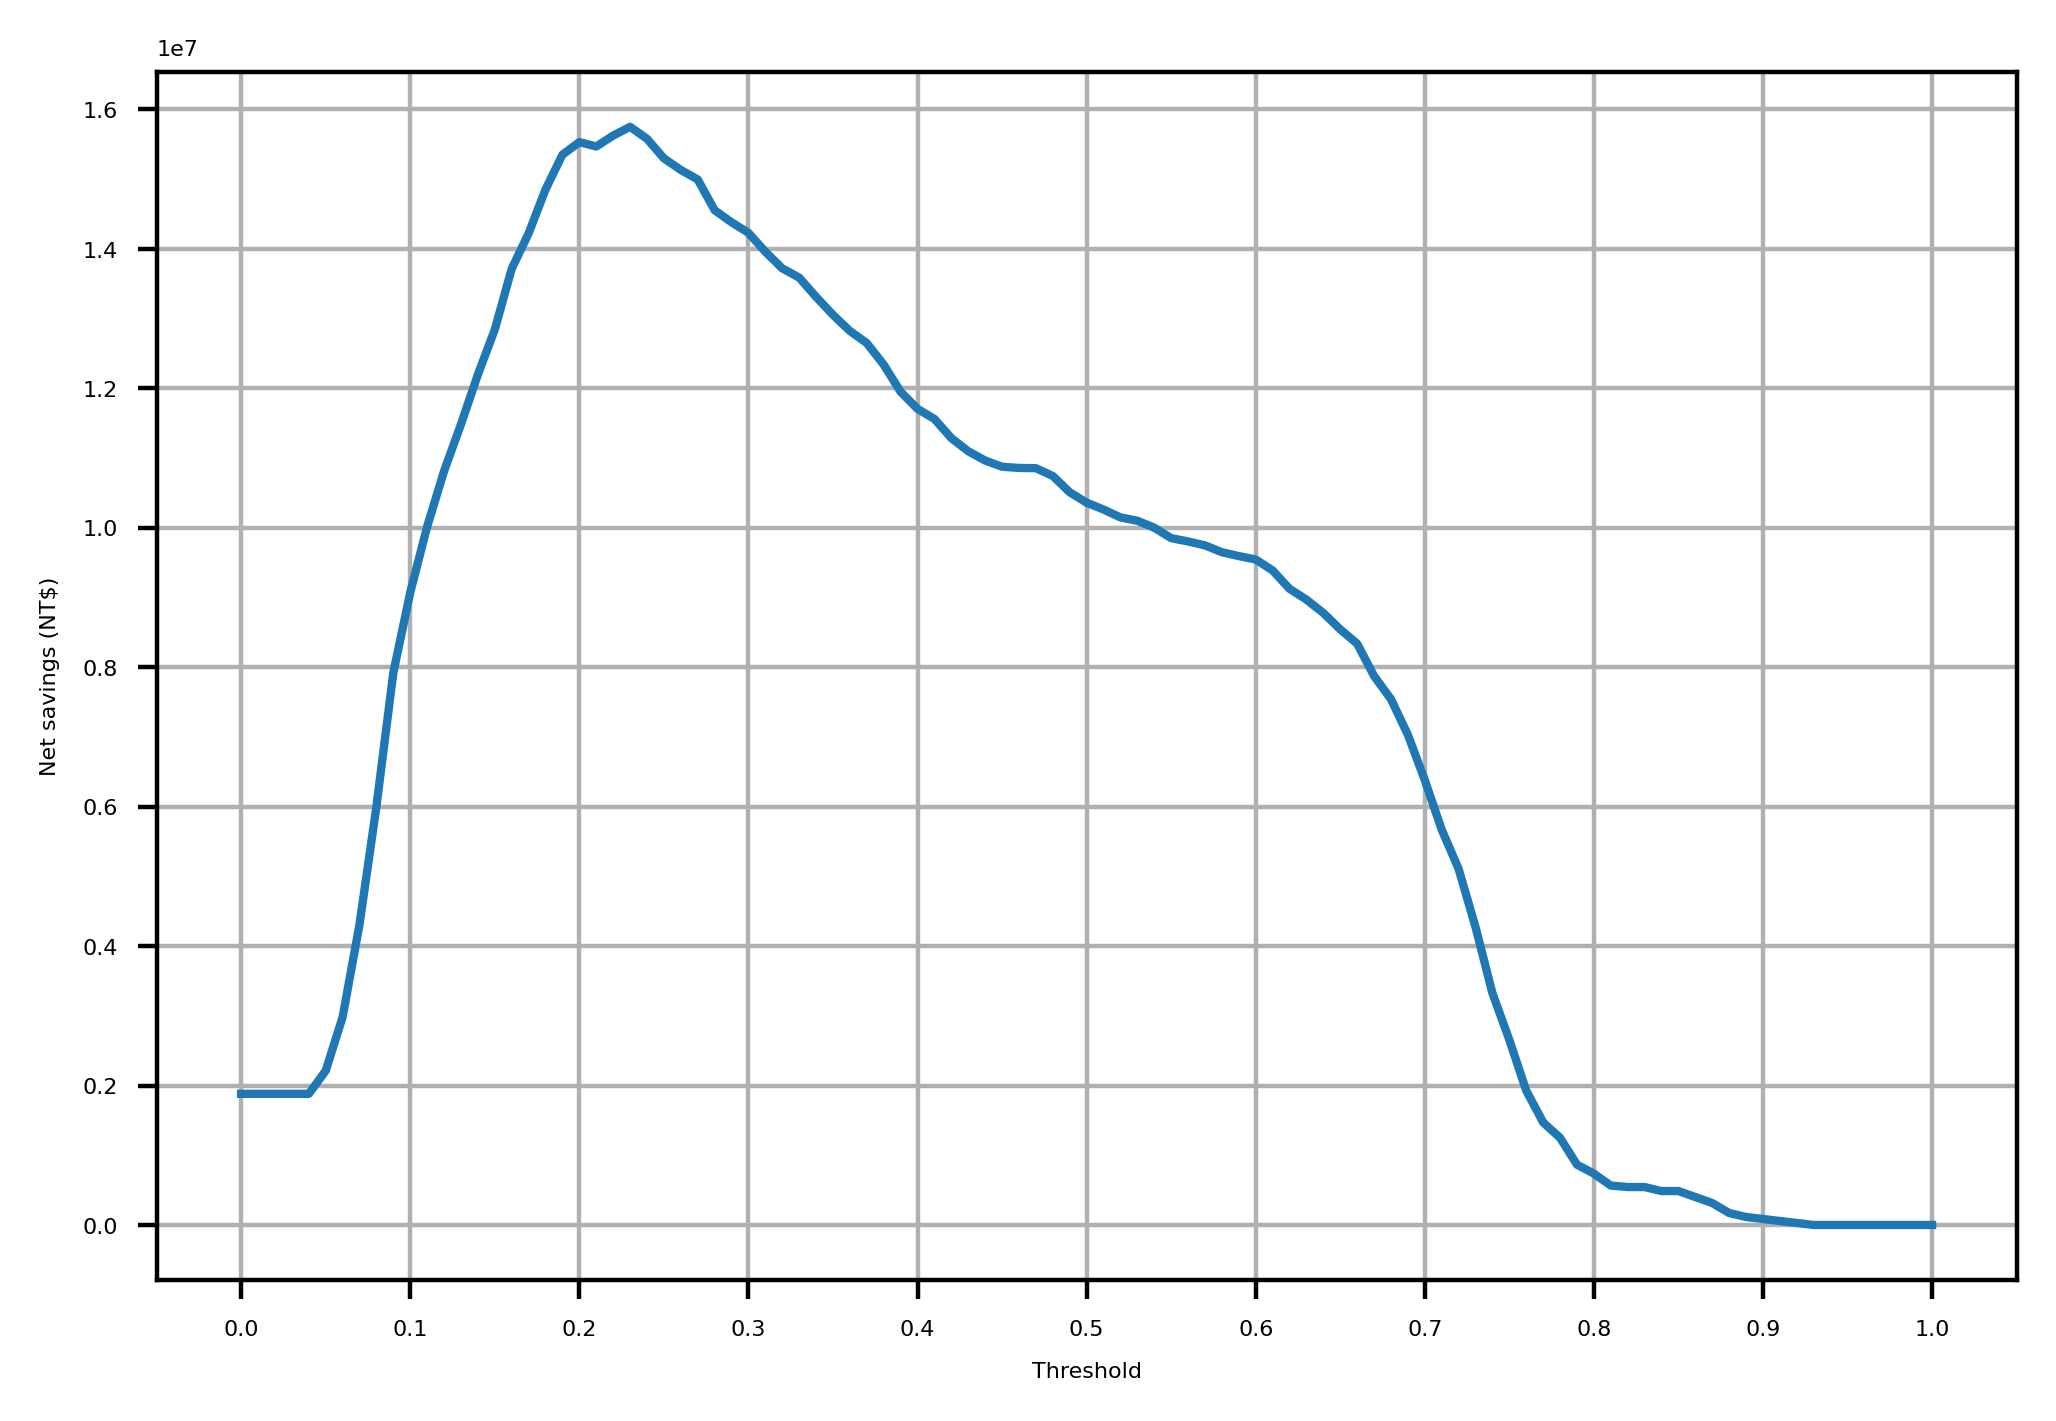

In [133]:
# Store the cost of counseling in a variable to use for analysis
cost_per_counseling = 7500

# Store the effectivness rate the client gave us for use in analysis
effectivness = 0.70

# Create empty arrays to store analysis results
n_pos_pred = np.empty_like(thresholds)
cost_of_all_counselings = np.empty_like(thresholds)
n_true_pos = np.empty_like(thresholds)
savings_off_all_counselings = np.empty_like(thresholds) 
savings_based_on_balances = np.empty_like(thresholds)

counter = 0
for threshold in thresholds:
    # Determine which accounts get positive predictions, at this threshold
    pos_pred =y_test_all_predict_proba[:,1]>threshold
    # Calculate the number of positive predictions
    n_pos_pred[counter] = sum(pos_pred)
    # Calculate the cost of all counseling, at this threshold
    cost_of_all_counselings[counter] = n_pos_pred[counter]*cost_per_counseling
    # Determine which accounts are true positives, based on the array of positive predictions and the response variable
    true_pos = pos_pred & y_test_all.astype(bool)
    # Calculate the number of true positives as the sum of true positive array
    n_true_pos[counter] = sum(true_pos)
    # Calculate the anticipated savings at this threshold using the number of true positives, the savings per prevented default, and the effectivness rate of counseling
    savings_off_all_counselings[counter] = n_true_pos[counter]*savings_per_default*effectivness
    # Increment the counter 
    counter += 1
# Calculate net savings for all the thresholds by substracting the savings and cost arrays
net_savings = savings_off_all_counselings - cost_of_all_counselings

# Plot the net savings against the thresholds as follows
mpl.rcParams["figure.dpi"] = 400
plt.plot(thresholds, net_savings)
plt.xlabel("Threshold")
plt.ylabel("Net savings (NT$)")
plt.xticks(np.linspace(0,1,11))
plt.grid(True)

In [134]:
# Find the index of the largest element of the net savings array
max_savings_ix = np.argmax(net_savings)
# Display the threshold that results in the greatest net savings
thresholds[max_savings_ix]

0.23

In [135]:
# Display the greatest possible net savings
net_savings[max_savings_ix]

15749203.325564161

Deriving financial insights

In [136]:
# Calculate the cost of all defaults if there were no counseling program
cost_of_defaults = sum(y_test_all) * savings_per_default
cost_of_defaults

66308240.202088244

In [137]:
# Calculate by what percent can the cost of defaults be decreased by the counseling program
net_savings[max_savings_ix]/cost_of_defaults

0.23751502494358417

In [138]:
# Calculate net savings per account at the optimal threshold
net_savings[max_savings_ix]/len(y_test_all)

2652.274052806359

Text(0, 0.5, 'Net savings per account (NT$)')

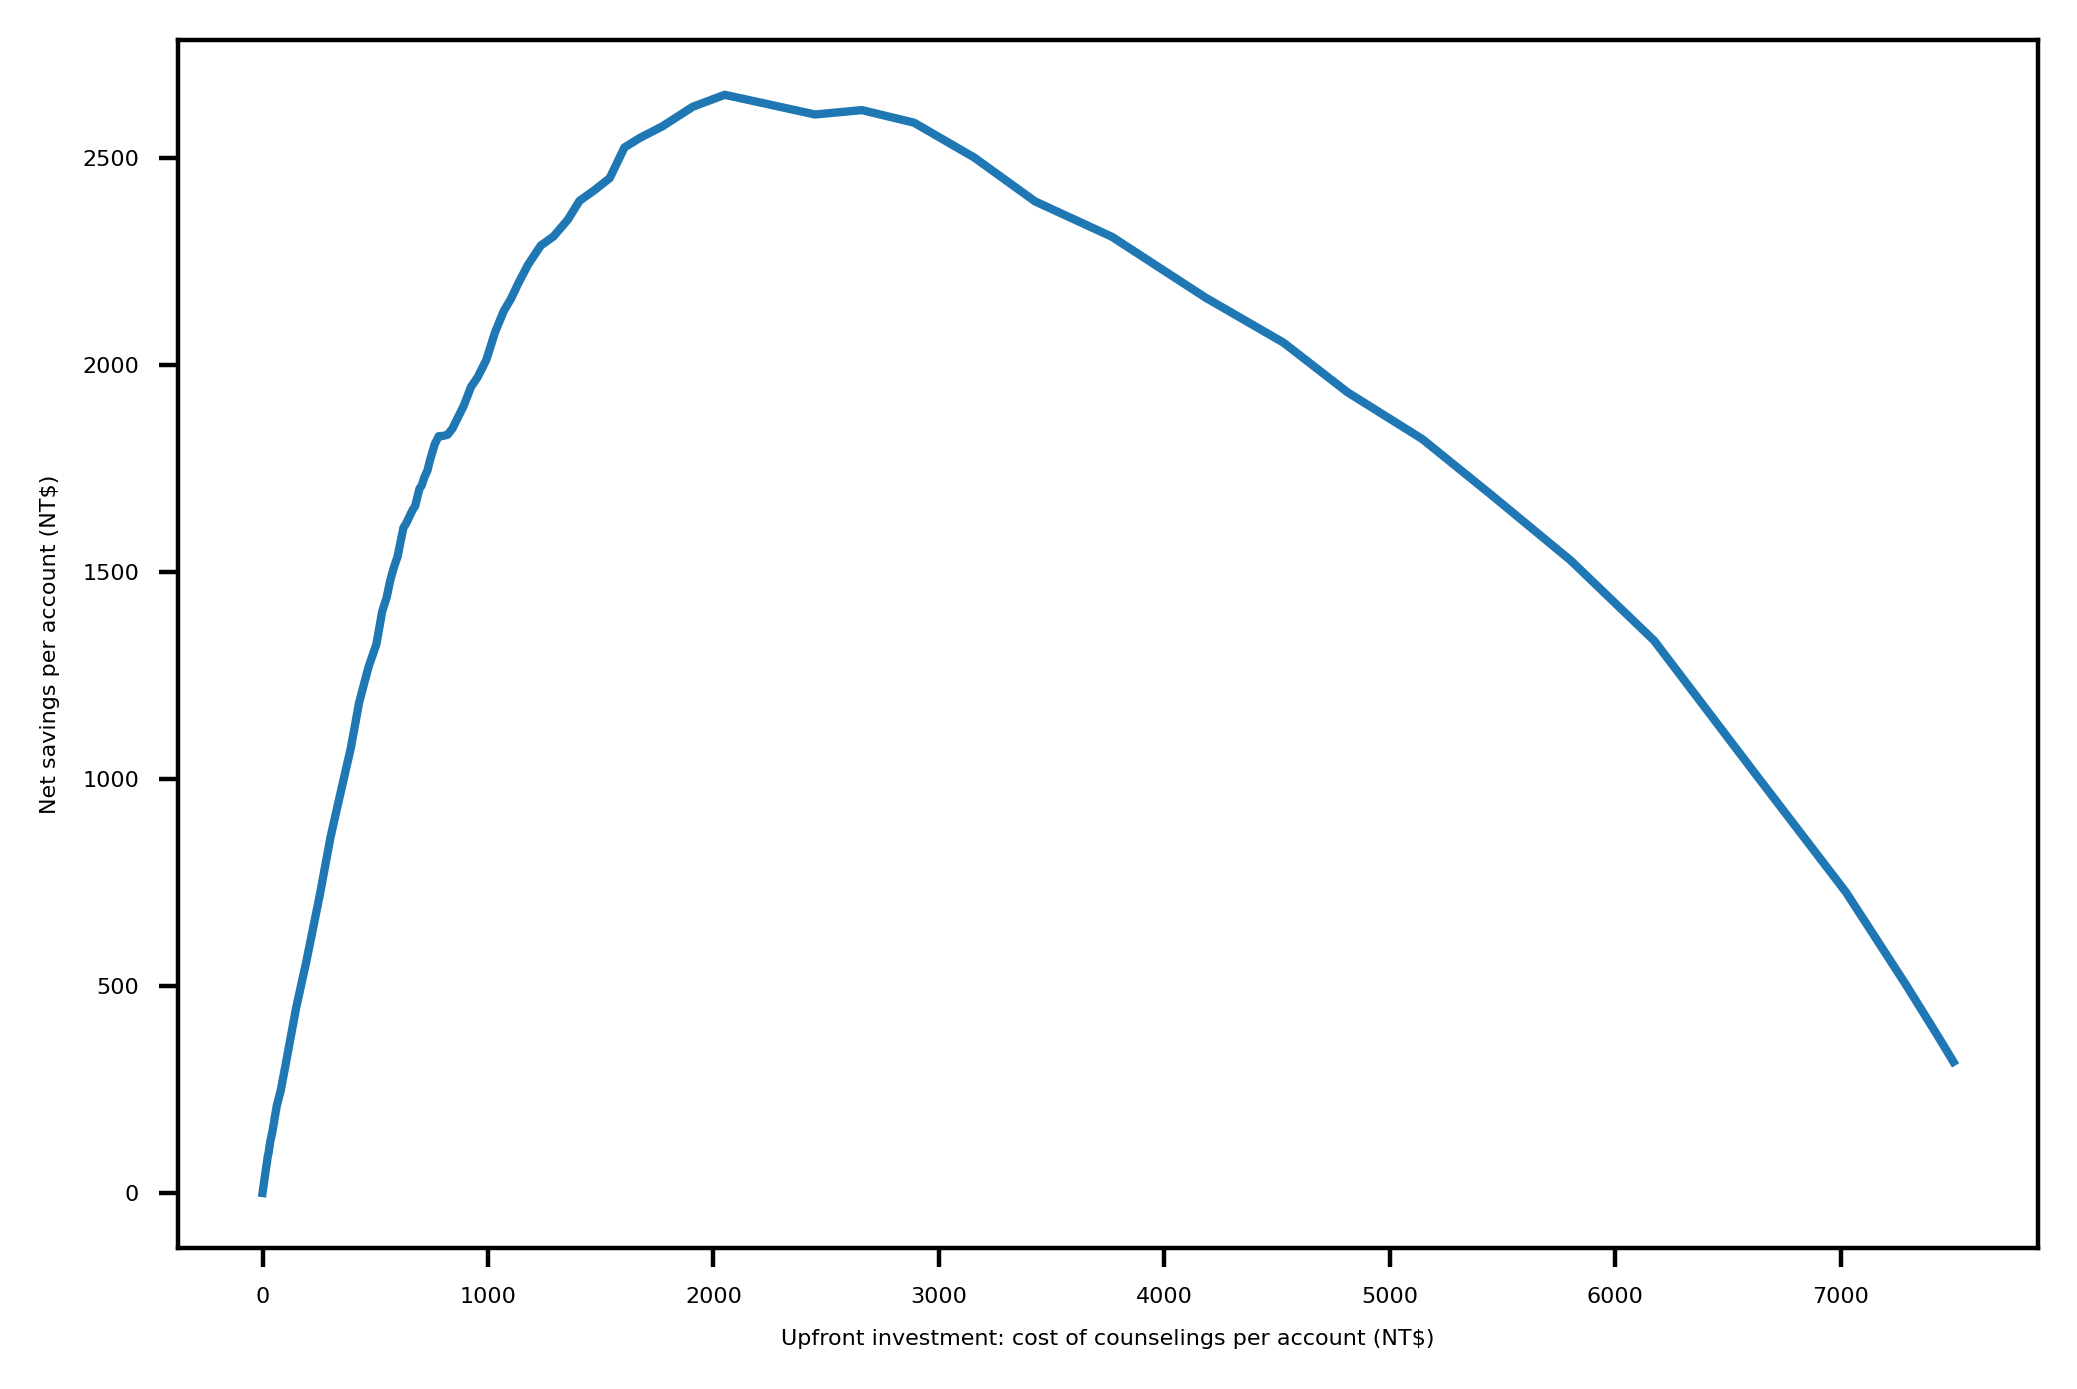

In [139]:
# Plot the net savings per account against the cost of counseling per account for each threshold
plt.plot(cost_of_all_counselings/len(y_test_all), net_savings/len(y_test_all))
plt.xlabel('Upfront investment: cost of counselings per account (NT$)')
plt.ylabel('Net savings per account (NT$)')

Text(0.5, 0, 'Threshold')

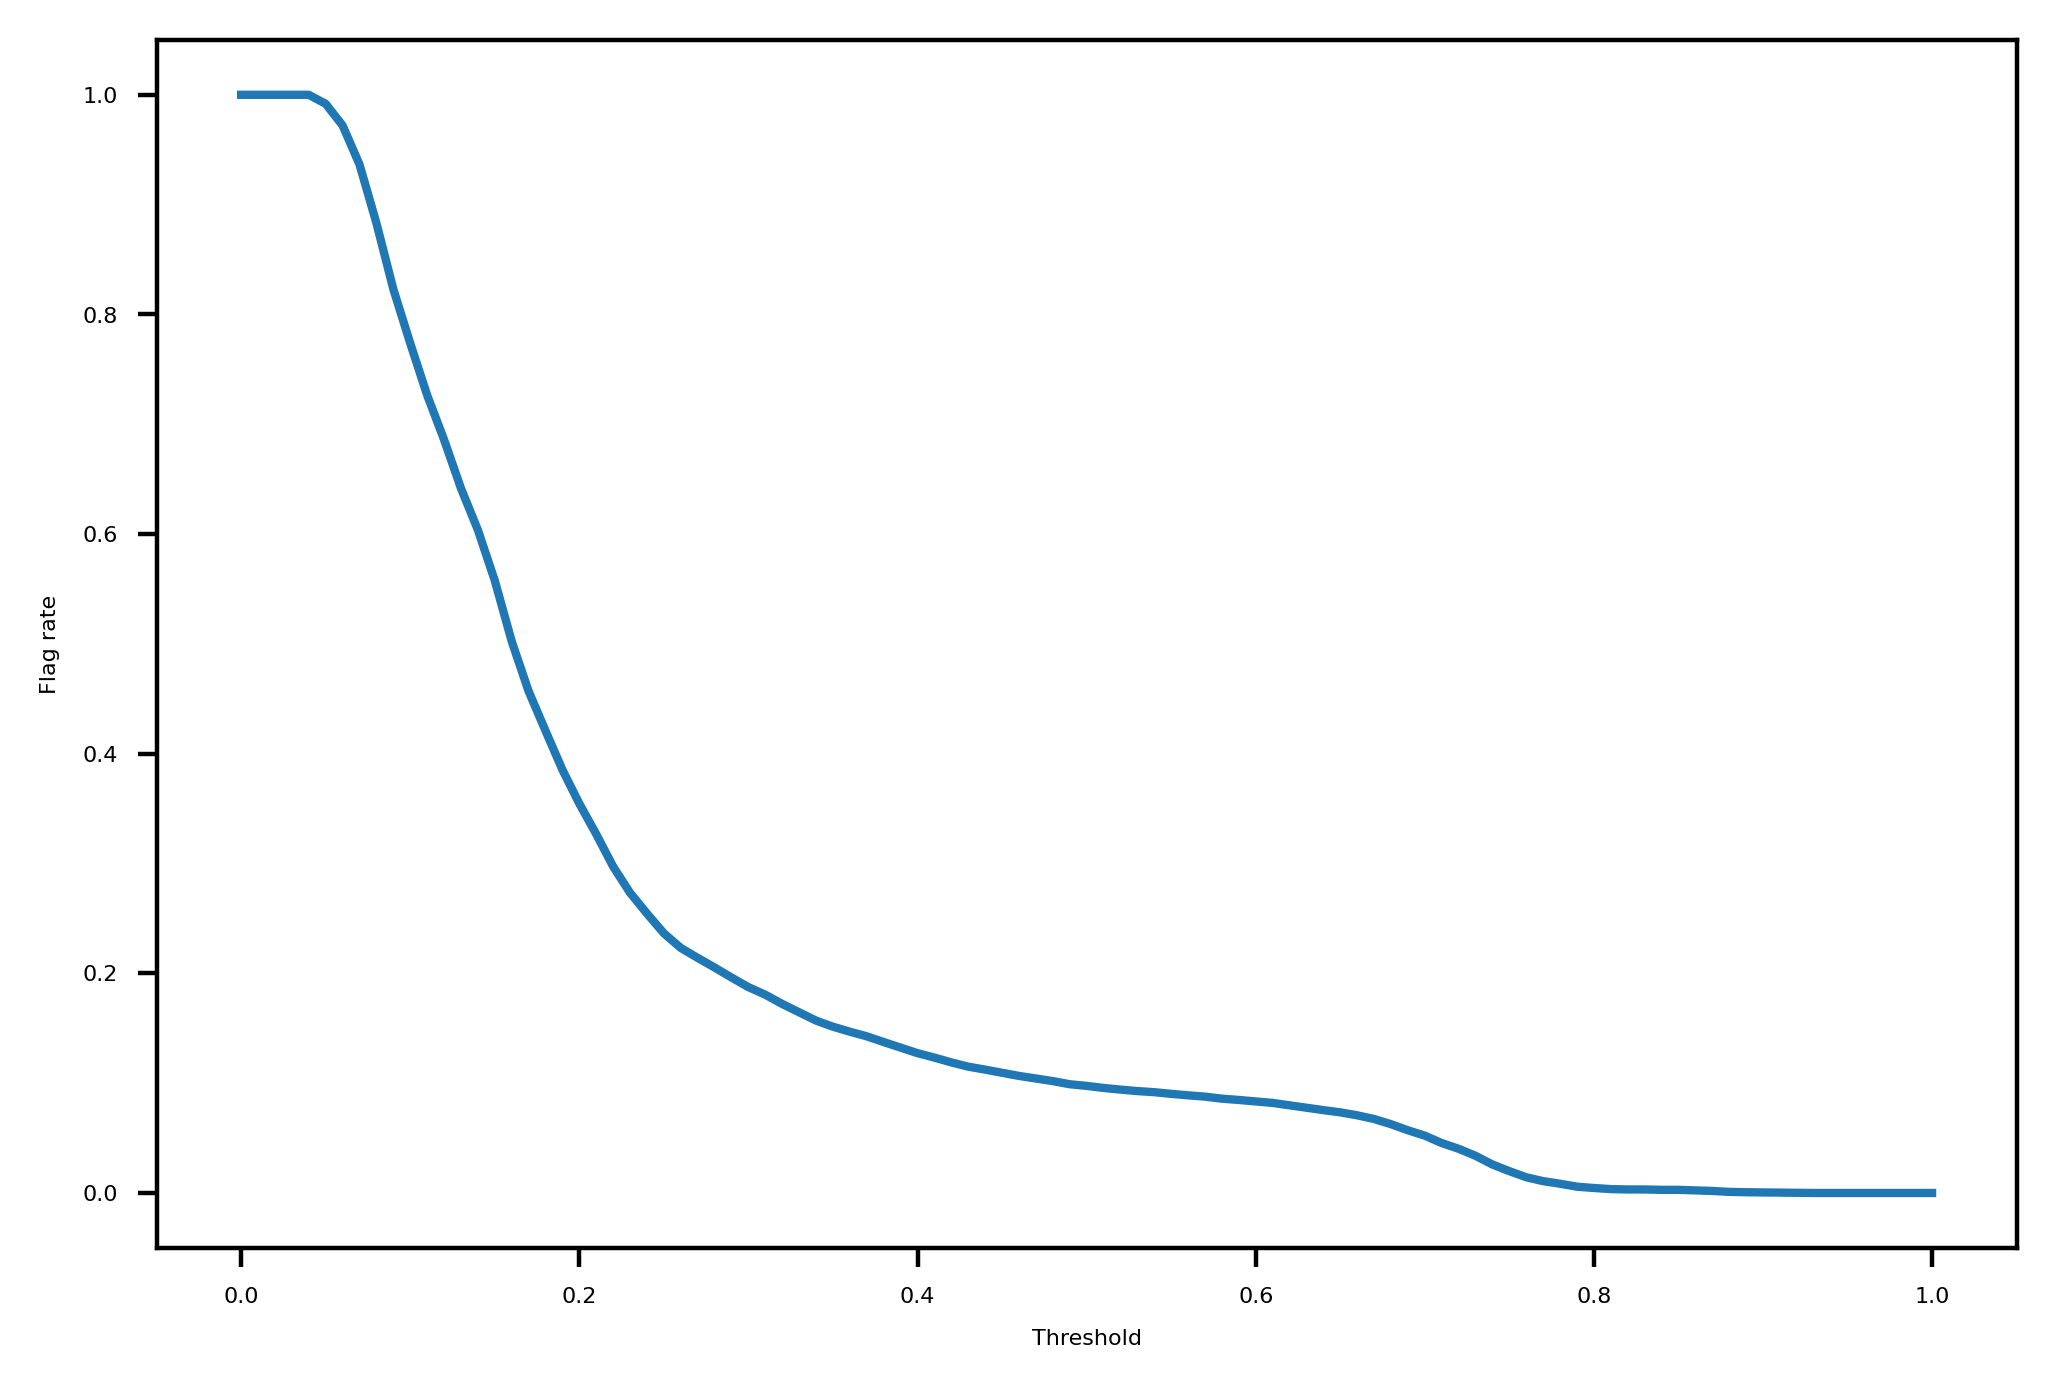

In [140]:
# Plot the fraction of accounts predicted as positive ("flag rate") at each threshold
plt.plot(thresholds, n_pos_pred/len(y_test_all))
plt.ylabel('Flag rate')
plt.xlabel('Threshold')

<ipython-input-141-9fb917e54da2>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(n_true_pos/sum(y_test_all), np.divide(n_true_pos, n_pos_pred))


Text(0, 0.5, 'Precision')

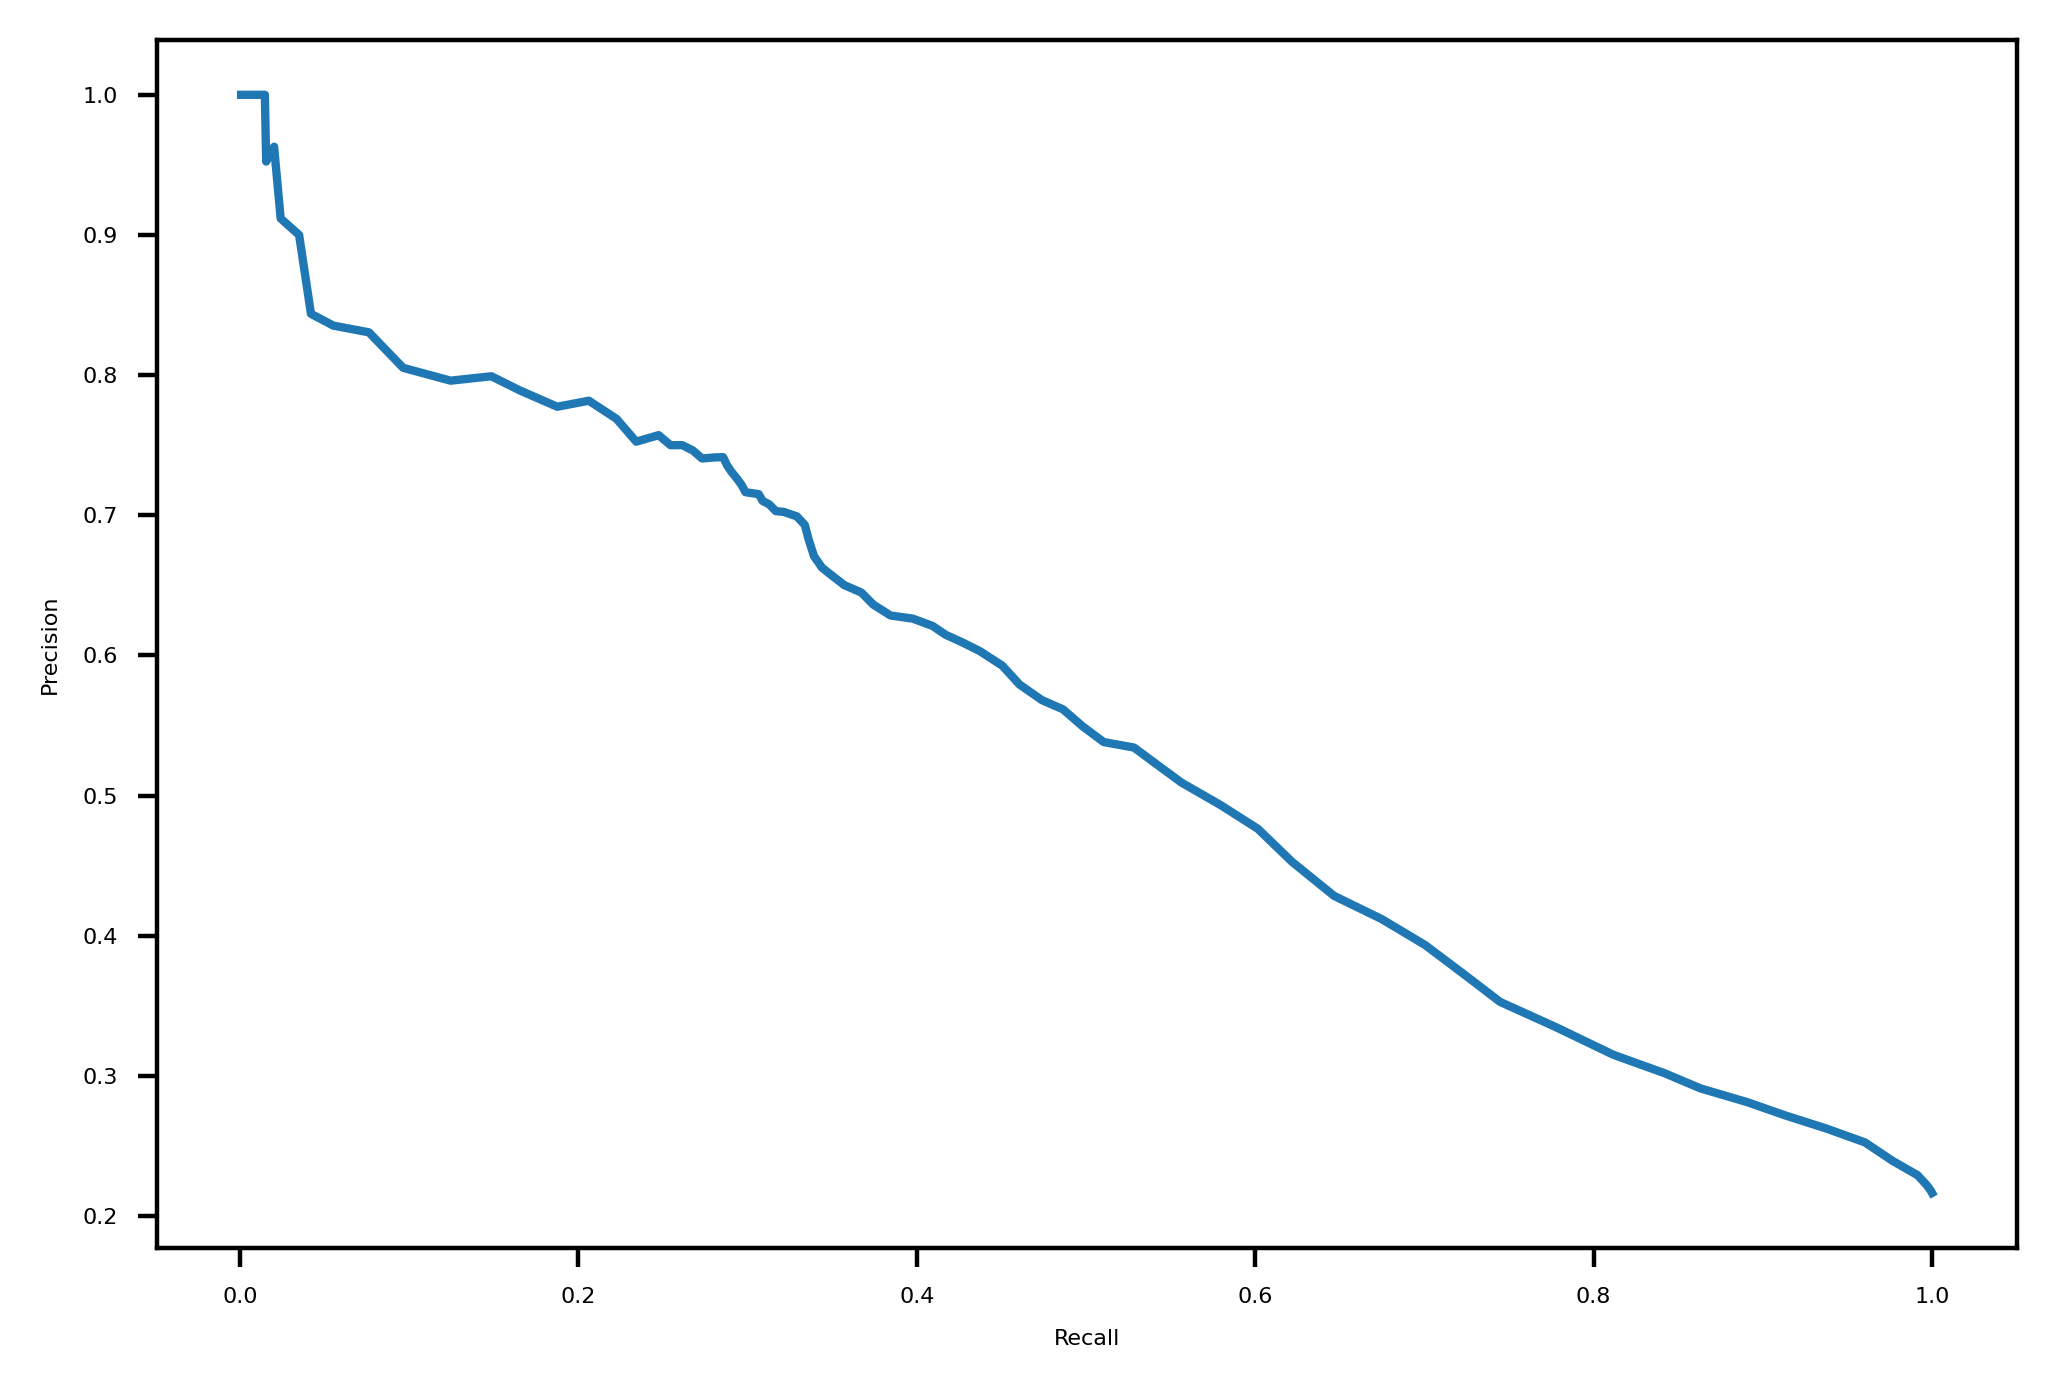

In [141]:
# Plot a precision-recall curve for the testing data
plt.plot(n_true_pos/sum(y_test_all), np.divide(n_true_pos, n_pos_pred))
plt.xlabel('Recall')
plt.ylabel('Precision')

<ipython-input-142-d0f1650b45f2>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(thresholds, np.divide(n_true_pos, n_pos_pred), label='Precision')


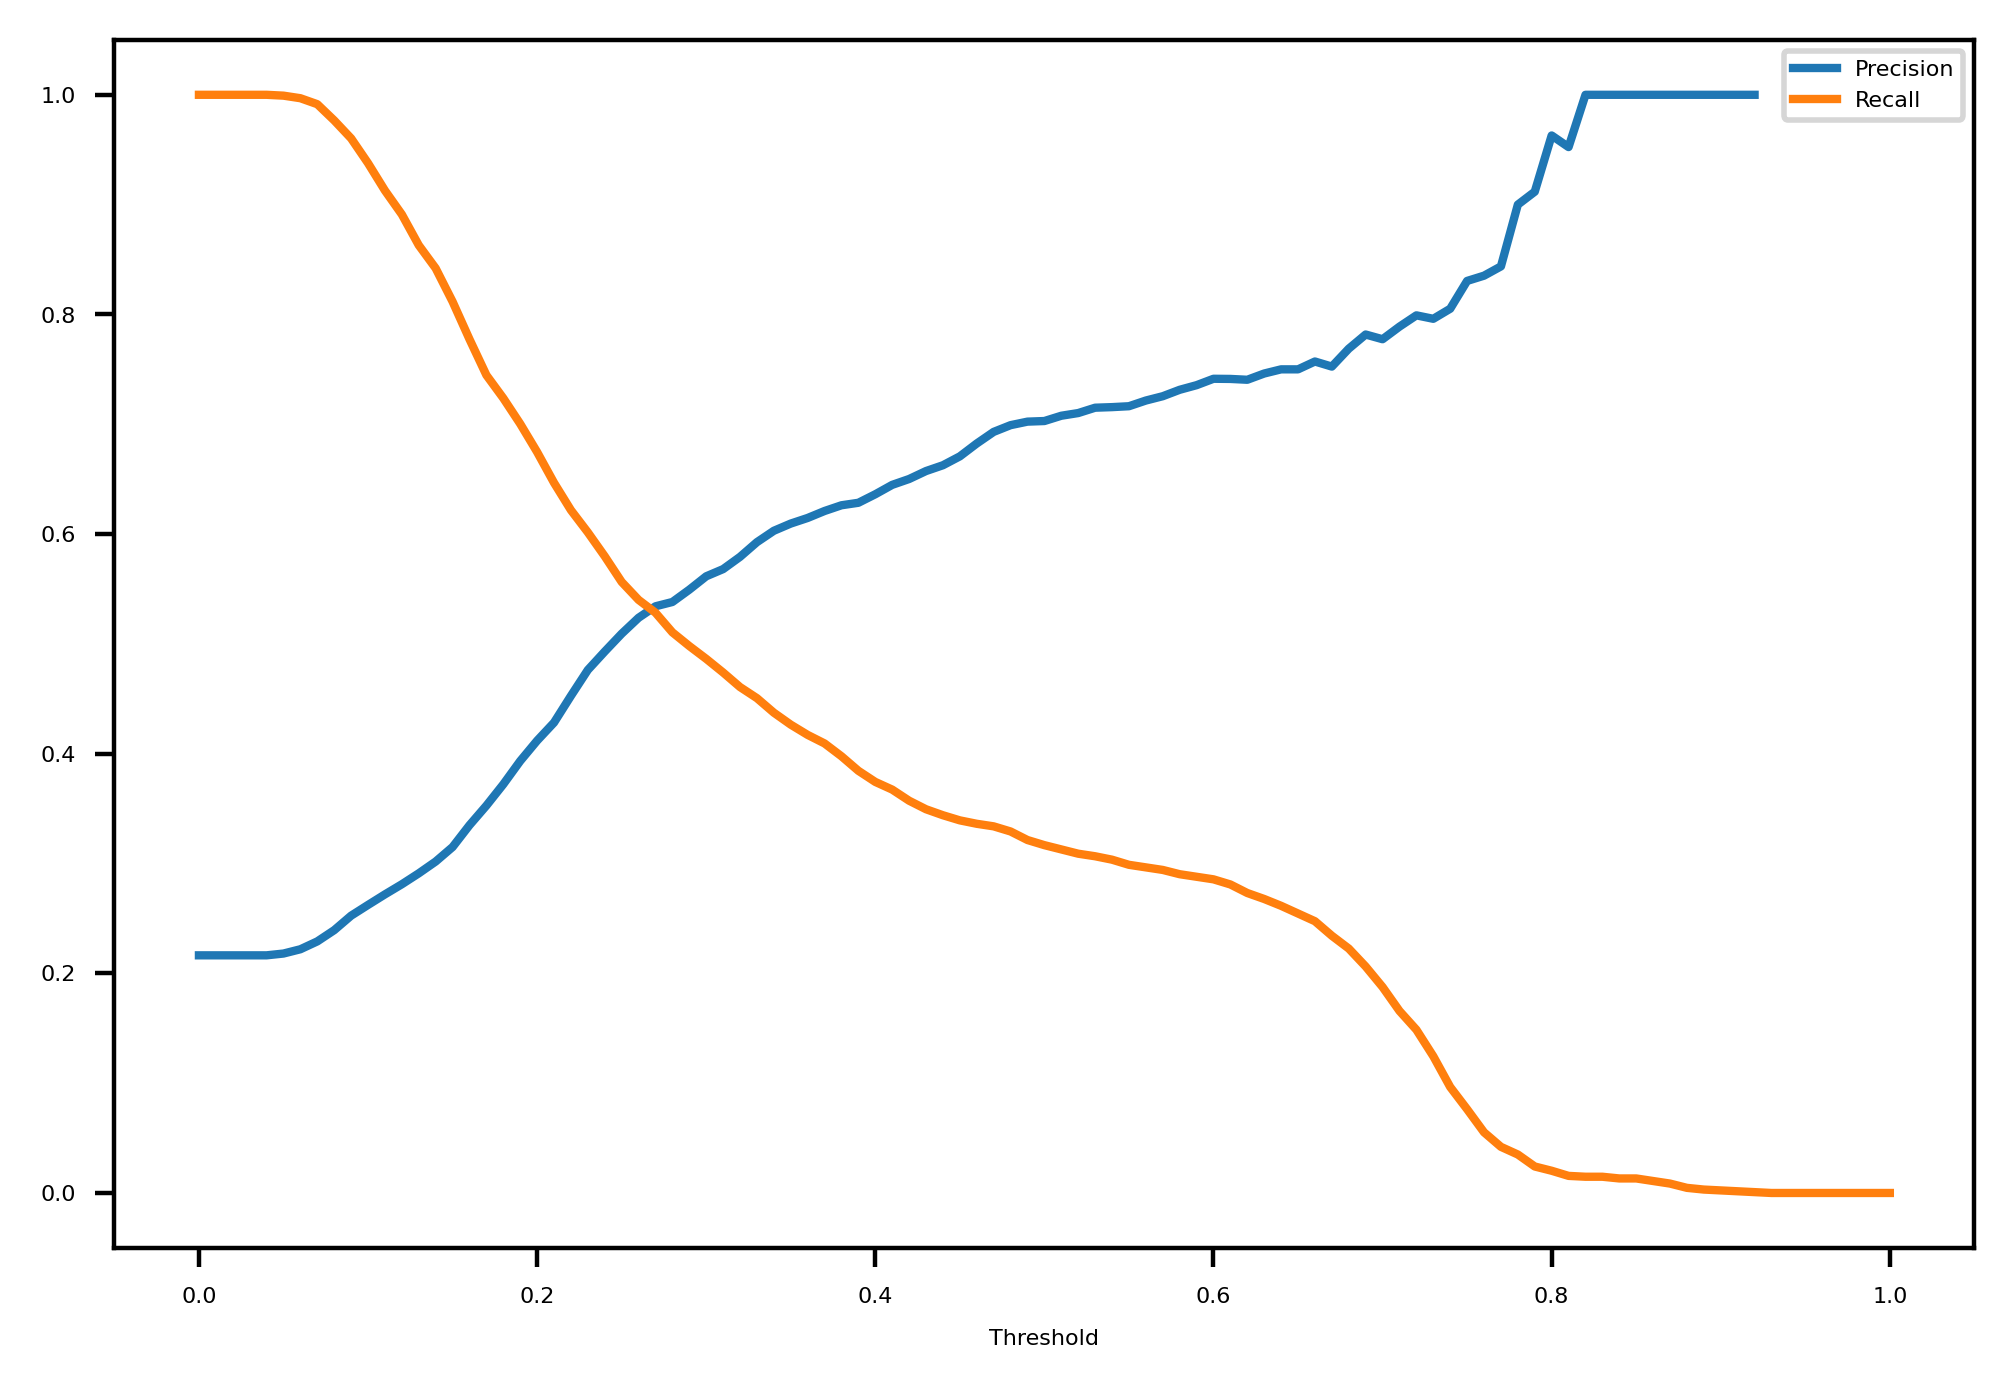

In [142]:
# Plot precision and recall separately on the y-axis against threshold on the x-axis
plt.plot(thresholds, np.divide(n_true_pos, n_pos_pred), label='Precision')
plt.plot(thresholds, n_true_pos/sum(y_test_all), label='Recall')
plt.xlabel('Threshold')
plt.legend()

Text(0, 0.5, 'Number of accounts')

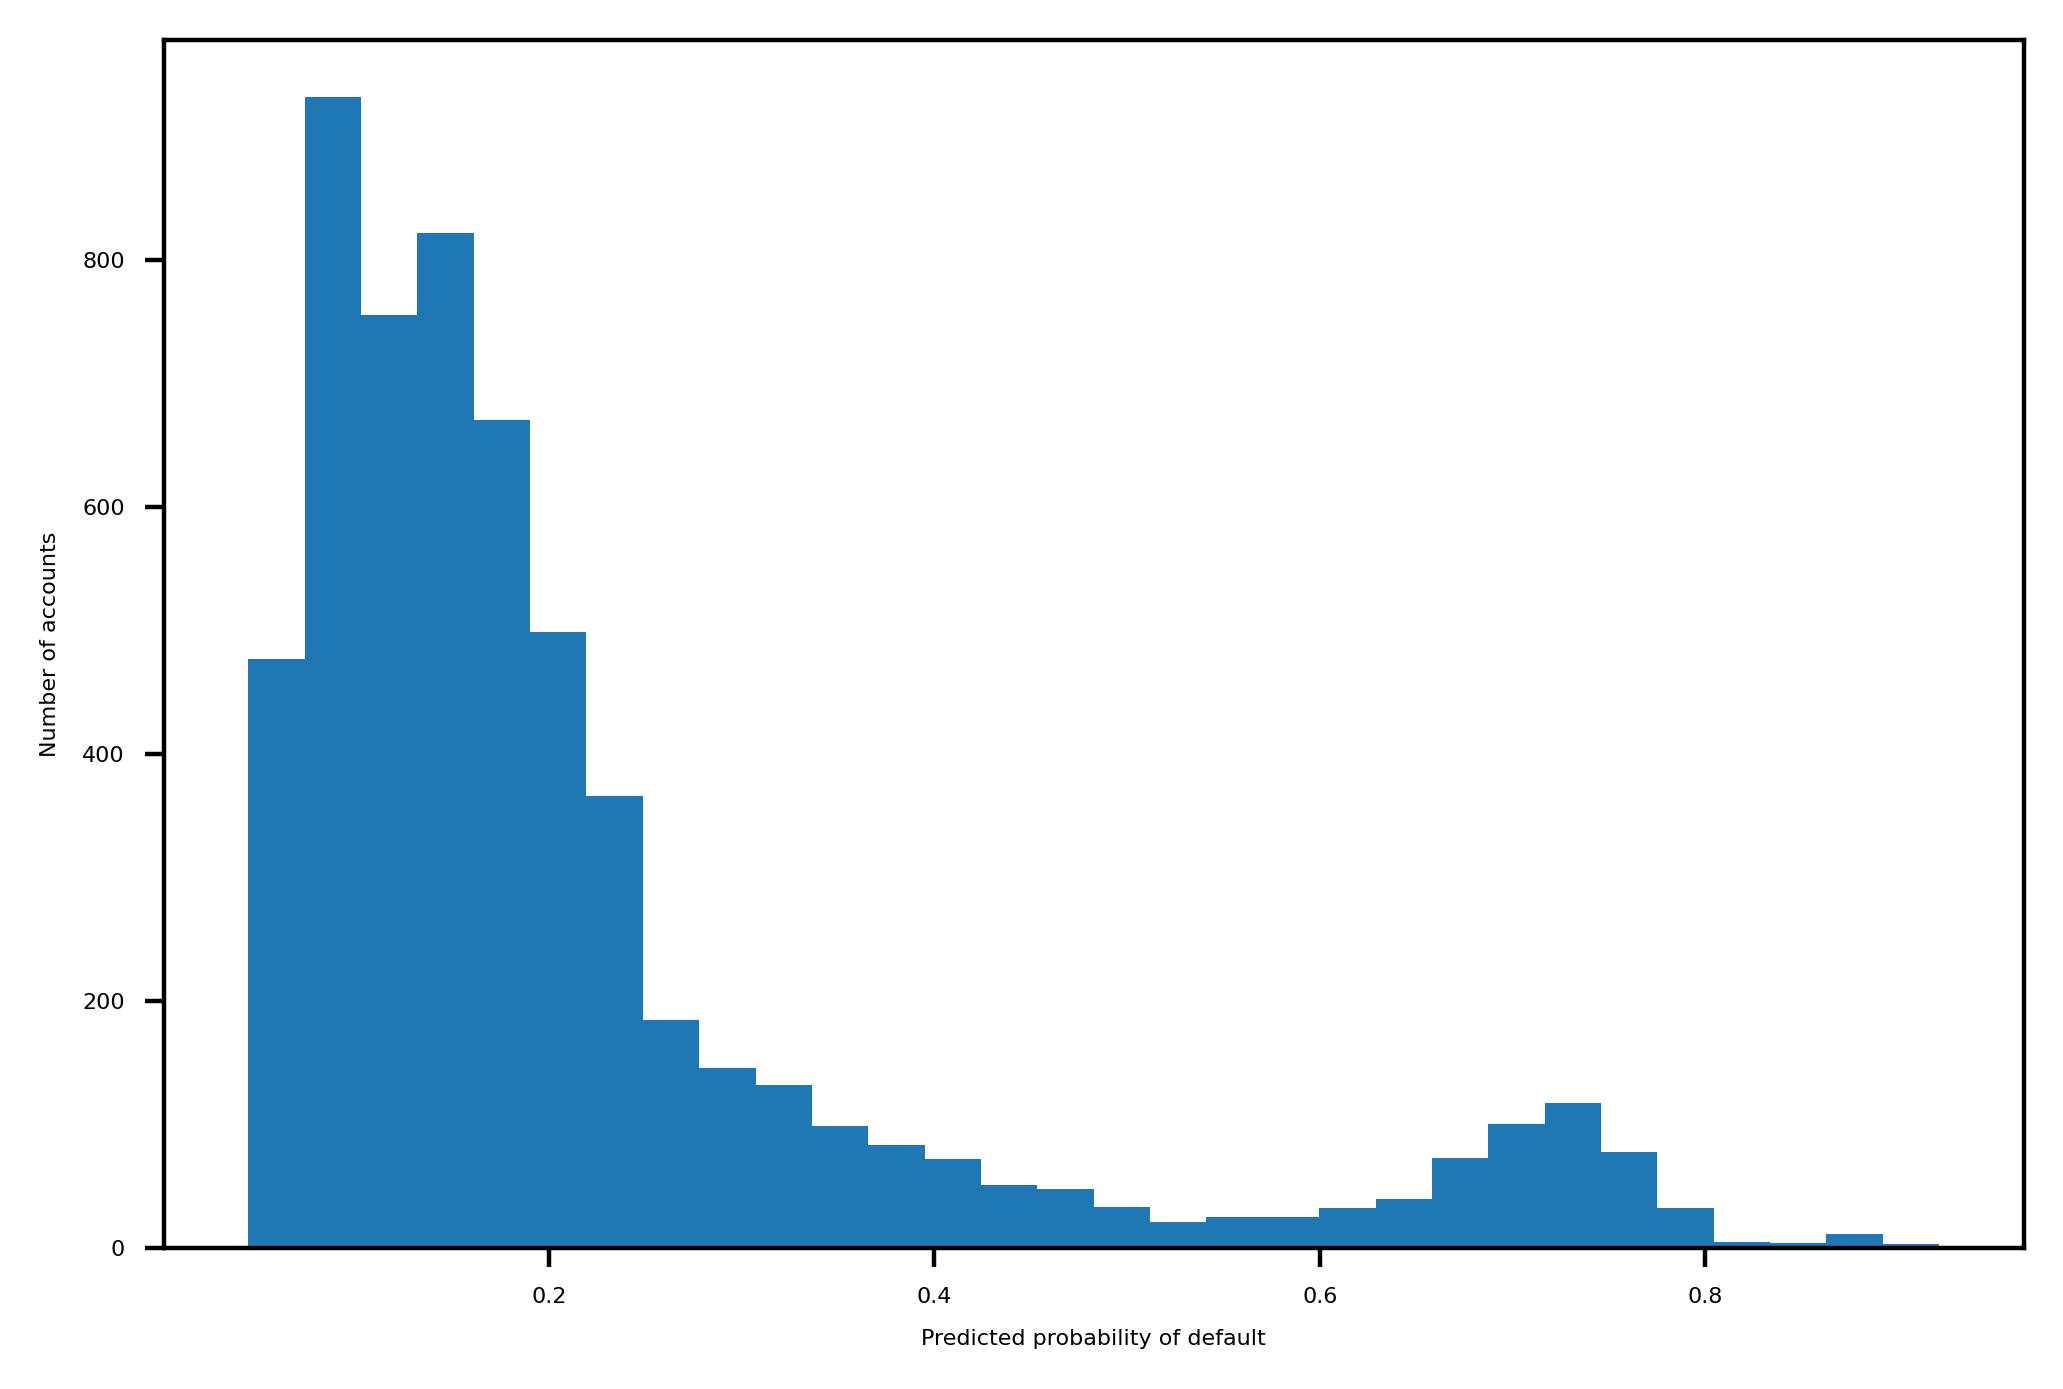

In [143]:
# Histogram of predicted probabilities of default
plt.hist(y_test_all_predict_proba[:,1], bins=30)
plt.xlabel('Predicted probability of default')
plt.ylabel('Number of accounts')